In [ ]:
import numpy as np
import pandas as pd
import sqlite3
import math
from datetime import datetime, timedelta
import scipy as sc
import pytz
import joblib
import os
import time

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error

from keras.models import Sequential
from keras.layers import LSTM, Dropout, Dense
from keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.metrics import MeanAbsoluteError
from keras.models import load_model
import tensorflow as tf

import keras
from keras import layers

import torch
import torch.nn as nn
from torch.nn.init import uniform_

from IPython.display import Image
import joblib
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots

import matplotlib.pyplot as plt
pd.options.plotting.backend = "plotly"
import seaborn as sns

import pickle
import matplotlib as mpl

tf.random.set_seed(13)
mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

import warnings
warnings.filterwarnings('ignore')

In [ ]:
# Cтарая LSTM модель c future engineering (географическое расположение + время в число)

class Temp:
    def __init__(self):
        self.past_history = 720
        self.future_target = 72
        self.STEP = 6
        self.BATCH_SIZE = 256
        self.BUFFER_SIZE = 10000
        self.TRAIN_SPLIT = 300000
        self.EVALUATION_INTERVAL = 400
        self.EPOCHS = 20
        self.data_mean = np.array([744.41406611, 6.006443, 87.24904045, 224.61552684])
        self.data_std  = np.array([216.24356615, 11.74853683, 112.89627056, 152.0149743])

    def multivariate_data(self, dataset, target, start_index, end_index, history_size,
                          target_size, step, single_step=False):
      data = []
      labels = []

      start_index = start_index + history_size
      if end_index is None:
        end_index = len(dataset) - target_size

      for i in range(start_index, end_index):
        indices = range(i - history_size, i, step)
        data.append(dataset[indices])

        if single_step:
          labels.append(target[i + target_size])
        else:
          labels.append(target[i:i + target_size])

      return np.array(data), np.array(labels)

    def transform(self):

        # df=pd.read_csv('/kaggle/input/weather/tes_osnova.csv')
        # ss=pd.read_csv('/kaggle/input/weather/sunrise_sunset_2026_update.csv').iloc[:,1:]

        df=pd.read_csv('./data/tes_osnova.csv')
        ss=pd.read_csv('./data/sunrise_sunset_2026_update.csv').iloc[:,1:]

        ss['date'] = ss['date'] + ' 00:00:00'
        df = df.merge(ss, left_on='dt', right_on='date', how='left').drop('date',axis=1)
        df = df[['dt','diff_rise_set','temp','new_feature_1','new_feature_2']]
        df['dt']=pd.to_datetime(df['dt'])
        df.set_index('dt', inplace=True)

        if df.index.duplicated().any():
            print("Обнаружены дубликаты!")
            df = df[~df.index.duplicated(keep='first')]

        new_index = pd.date_range(start=df.index.min(), end=df.index.max(), freq='10T')
        features = df.reindex(new_index)
        features = features.interpolate(method='linear')
        features.reset_index(inplace=True)
        features.rename(columns={'index': 'dt'}, inplace=True)
        features=features[features['dt']<'2024-01-01 00:00:00'].dropna()
        features=features[-900000:].reset_index(drop=True)
        features=features.round(3)
        features.set_index('dt', inplace=True)

        if np.any(np.isnan(features)) or np.any(np.isinf(features)):
            print("Данные содержат NaN или бесконечные значения!")

        print('TRAIN_SPLIT period :', features[:self.TRAIN_SPLIT].index.min(),features[:self.TRAIN_SPLIT].index.max())

        dataset = features.values

        if np.any(self.data_std == 0):
            print("Стандартное отклонение равно нулю!")

        dataset = (dataset-self.data_mean) / self.data_std

        self.x_train, self.y_train = self.multivariate_data(dataset,
                                                                   dataset[:, 1],
                                                                   0,
                                                                   self.TRAIN_SPLIT,
                                                                   self.past_history,
                                                                   self.future_target,
                                                                   self.STEP)

        self.x_val, self.y_val = self.multivariate_data(dataset,
                                                               dataset[:, 1],
                                                               self.TRAIN_SPLIT,
                                                               None,
                                                               self.past_history,
                                                               self.future_target,
                                                               self.STEP)

        print ('x_train :', self.x_train[0].shape)
        print ('y_train :', self.y_train[0].shape)

        print ('x_val :', self.x_val[0].shape)
        print ('y_val :', self.y_val[0].shape)

    def fit(self):
        os.makedirs('./models', exist_ok=True)
        os.makedirs('./report', exist_ok=True)

        train_data = tf.data.Dataset.from_tensor_slices(
            (self.x_train,
             self.y_train)).cache().shuffle(self.BUFFER_SIZE).batch(self.BATCH_SIZE).repeat()

        val_data = tf.data.Dataset.from_tensor_slices(
            (self.x_val,
             self.y_val)).batch(self.BATCH_SIZE).repeat()

        model = tf.keras.models.Sequential()
        model.add(tf.keras.layers.LSTM(32, return_sequences=True, input_shape=self.x_train.shape[-2:]))
        model.add(tf.keras.layers.LSTM(16, activation='relu'))
        model.add(tf.keras.layers.Dense(self.future_target)) # 72
        model.compile(optimizer=tf.keras.optimizers.RMSprop(clipvalue=1.0), loss='mae', metrics=[MeanAbsoluteError()])

        history = model.fit(train_data,
                    epochs=self.EPOCHS,
                    steps_per_epoch=self.EVALUATION_INTERVAL,
                    validation_data=val_data,
                    validation_steps=50)

        model.save('./model/lstm_temp.h5')
        # tf.keras.models.save_model(model, '/kaggle/working/models/lstm_temp.keras')

        history_df = pd.DataFrame(history.history)
        history_df['date'] = datetime.now()
        history_df['loading_id'] = history_df['date'].apply(lambda row: row.timestamp())

        if os.path.exists('./report/lstm_temp_history.csv'):
            history_df.to_csv('./report/lstm_temp_history.csv', mode='a', header=False, index=False)
        else:
            history_df.to_csv('./report/lstm_temp_history.csv', index=False)

    def plot_train_history(self, report):

        for load_id in sorted(report['loading_id'].unique(), reverse=True):
            history = report[report['loading_id']==load_id].reset_index(drop=True)
            loss = history['loss']
            val_loss = history['val_loss']

            fig = go.Figure()
            fig.add_trace(go.Scatter(x=(history.index)+1, y=loss, mode='lines', name='Тренировочные данные'))
            fig.add_trace(go.Scatter(x=(history.index)+1, y=val_loss, mode='lines', name='Валидационные данные'))
            fig.update_layout(title='Динамика потерь во время обучения модели',
                              xaxis_title='Эпоха',
                              yaxis_title='Потери',
                              height=500,
                              width=1000)
            fig.show()

    def multivariate_data2(self, dataset, target, history_size, target_size, step, single_step=False):
        data = []
        labels = []

        end_index = len(dataset) - target_size
        start_index = end_index - history_size
        if start_index < 0:
            raise ValueError("History size is too large for the given dataset.")
        indices = range(start_index, end_index, step)
        data.append(dataset[indices])
        if single_step:
            labels.append(target[end_index + target_size])
        else:
            labels.append(target[end_index:end_index + target_size])
        return np.array(data), np.array(labels)

    def predict(self, start, days, old_forecast = pd.DataFrame()):

        # df = pd.read_csv('/kaggle/input/weather/tes_osnova.csv')[['dt','temp']]
        # df=pd.read_csv('/kaggle/input/weather/test_realtime_2.csv')

        df = pd.read_csv('./data/tes_osnova.csv')[['dt','temp']]

        df=df.dropna(axis=1)
        df['dt'] = df['dt'].apply(lambda row: row.replace('+03:00',''))
        df = df[df['dt']<start].tail(1000)

        if days > 0:
            df = pd.concat([df, old_forecast]).reset_index(drop=True)
            start = (pd.to_datetime(df['dt']).max()).strftime("%Y-%m-%d %H:%M:%S")

        ss=pd.read_csv('./data/sunrise_sunset_2026_update.csv').iloc[:,1:]

        ss['date'] = ss['date'] + ' 00:00:00'

        ss2 = ss[ss['date'] >= start][['date','diff_rise_set', 'new_feature_1','new_feature_2']].head(3).copy()
        df = df.merge(ss, left_on='dt', right_on='date', how='left').drop('date',axis=1)
        df = df[['dt','diff_rise_set','temp','new_feature_1','new_feature_2']]
        df['dt']=pd.to_datetime(df['dt'])
        df.set_index('dt', inplace=True)

        new_index = pd.date_range(start=df.index.min(), end=df.index.max(), freq='10T')
        features = df.reindex(new_index)
        features = features.interpolate(method='linear')
        features.reset_index(inplace=True)
        features.rename(columns={'index': 'dt'}, inplace=True)
        features=features[features['dt'] < start].dropna()
        features.set_index('dt', inplace=True)

        last_12_values = features['temp'].tail(self.future_target).tolist()
        ss2['date'] = pd.to_datetime(ss2['date'])
        ss2.set_index('date', inplace=True)
        new_index = pd.date_range(start=ss2.index.min(), end=ss2.index.max(), freq='10T')
        features2 = ss2.reindex(new_index).interpolate(method='time')
        features2 = features2.head(self.future_target)
        features2.insert(1, 'temp', last_12_values)
        features = pd.concat([features,features2])
        dataset = features.values
        dataset = (dataset-self.data_mean) / self.data_std

        x_val, y_val = self.multivariate_data2(dataset,
                                                 dataset[:, 1],
                                                 self.past_history,
                                                 self.future_target,
                                                 self.STEP)

        val_data = tf.data.Dataset.from_tensor_slices((x_val, y_val)).batch(self.BATCH_SIZE)

        # model = tf.keras.models.load_model('lstm_temp.h5')
        # model = tf.keras.models.load_model('/kaggle/working/models/lstm_temp.keras')
        model = tf.keras.models.load_model('./model/lstm_temp.keras')

        predictions = model.predict(val_data)
        predictions = (predictions * self.data_std[1]  + self.data_mean[1]).flatten()

        num_groups = len(predictions) // 6
        averages = []
        for i in range(num_groups):
            group = predictions[i * 6 : (i + 1) * 6]
            average = np.round(np.max(group),2)
            averages.append(average)

        date_range = pd.date_range(start=pd.to_datetime(start), end=pd.to_datetime(start) + pd.Timedelta(hours=11), freq='H')
        forecast = pd.DataFrame({'dt':date_range.strftime("%Y-%m-%d %H:%M:%S"), 'temp':averages})
        return forecast

    def сhecking_weekly_forecast(self, dt_start, days):
        '''
        Проверка работы dl.
        Запускаем каждые через каждые 12 часов.
        Результат близок к факту.
        '''

        result, tmp = pd.DataFrame(), pd.DataFrame()
        for day in range(days*2):
            tmp = self.predict(dt_start, 0, tmp)
            dt_start = (pd.to_datetime(tmp['dt']).max()+ timedelta(hours=1)) .strftime("%Y-%m-%d %H:%M:%S")
            result = pd.concat([result, tmp])
        return result.reset_index(drop=True)

    def predict_days(self, dt_start, days):

        result, tmp = pd.DataFrame(), pd.DataFrame()
        for day in range(days*2+1):
            tmp = self.predict(dt_start, day, result)
            result = pd.concat([result, tmp])
            result = result.drop_duplicates(subset=['dt'], keep='first')

        return result.reset_index(drop=True)

    def main(self):
        self.transform()
        self.fit()
        # self.predict('2024-12-15 02:00:00', 1)
        return 'Successful!'

t = Temp()

В методе predict_days строится прогноз на основе ранее представленной модели. То есть по 10 минут следующие 12 часов.

Главная особенность - сделали 12 прогноз, а потом добавли к истории и снова предсказали следующие 12 часов.

Второй аргумент в методе - это количество дней прогноза. Расчет в 24 часах с отчетной даты.

In [ ]:
forecast = t.predict_days('2024-05-15 02:00:00', 7)
forecast.set_index('dt', inplace=True)
forecast

# fact=pd.read_csv('/kaggle/input/weather/test_realtime_2.csv')
# fact=pd.read_csv('/kaggle/input/weather/tes_osnova.csv')[['dt','temp']]

fact=pd.read_csv('./data/tes_osnova.csv')[['dt','temp']]

fact=fact[['dt','temp']]
fact['dt']=fact['dt'].apply(lambda row: row.replace('+03:00',''))
fact['dt']=pd.to_datetime(fact['dt'])
fact.set_index('dt', inplace=True)
fact=fact.loc[forecast.index.min():forecast.index.max()]

fig = go.Figure()
fig.add_trace(go.Scatter(x=forecast.index, y=forecast['temp'], mode='lines', name='Forecast'))
fig.add_trace(go.Scatter(x=fact.index, y=fact['temp'], mode='lines', name='Fact'))

fig.update_layout(title='Фактические и предсказанные значения температуры',
                  xaxis_title='Дата',
                  yaxis_title='Температура',
                  height=500,
                  width=1300)
fig.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 287ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 302ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 287ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 305ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 300ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 301ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 309ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 282ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 296ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 392ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 328ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 289ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 282ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 274ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 275ms/step


In [ ]:
dates = ['2024-01-15 12:00:00',
         '2024-02-15 12:00:00',
         '2024-03-15 12:00:00',
         '2024-04-15 12:00:00',
         '2024-05-15 12:00:00',
         '2024-06-15 12:00:00',
         '2024-07-15 12:00:00',
         '2024-08-15 12:00:00',
         '2024-09-15 12:00:00',
         '2024-10-15 12:00:00',
         '2024-11-15 12:00:00',
         '2024-12-15 12:00:00']

ts = pd.read_csv('./data/tes_osnova.csv')[['dt','temp']]
ts['dt']=ts['dt'].apply(lambda row: row.replace('+03:00',''))
ts['dt']=pd.to_datetime(ts['dt'])
ts.set_index('dt', inplace=True)

for date in dates:
    forecast = t.predict_days(date, 7)
    forecast.set_index('dt',inplace=True)

    fact=ts.loc[forecast.index.min():forecast.index.max()]

    fig = go.Figure()
    fig.add_trace(go.Scatter(x=forecast.index, y=forecast['temp'], mode='lines', name='Forecast'))
    fig.add_trace(go.Scatter(x=fact.index, y=fact['temp'], mode='lines', name='Fact'))

    fig.update_layout(title=f'Фактические и предсказанные значения температуры на {date}',
                      xaxis_title='Дата',
                      yaxis_title='Температура',
                      height=500,
                      width=1300)
    fig.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 343ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 292ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 285ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 283ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 288ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 421ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 491ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 286ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 308ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 281ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 303ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 289ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 286ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 289ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 282ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 299ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 295ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 434ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 446ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 296ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 281ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 278ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 999ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 316ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 325ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 311ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 327ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 335ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 326ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 704ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 297ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 330ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 420ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 288ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 292ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 297ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 332ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 321ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 299ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 289ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 453ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 437ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 299ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 297ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 297ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 308ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 303ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 308ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 301ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 307ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 284ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 275ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 411ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 454ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 287ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 277ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 297ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 296ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 302ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 295ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 280ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 288ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 285ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 284ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 288ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 412ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 393ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 303ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 296ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 299ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 278ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 579ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 657ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 316ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 333ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 315ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 317ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 300ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 310ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 313ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 299ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 337ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 438ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 315ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 306ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 296ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 307ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 294ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 291ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 293ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 305ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 296ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 835ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 526ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 290ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 298ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 290ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 288ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 287ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 312ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 296ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 311ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 425ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 296ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 298ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 306ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 279ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 283ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 315ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 287ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 614ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 596ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 460ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 313ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 318ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 339ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 571ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 351ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 654ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 334ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 561ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 312ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 435ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 491ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 547ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 349ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 318ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 469ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 734ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 319ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 319ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 479ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 492ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 422ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 295ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 303ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 441ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 353ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 374ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 450ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 315ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 344ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 380ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 338ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 392ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 293ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 312ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 452ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 599ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 276ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 292ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 317ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 285ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 303ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 299ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 293ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 313ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 297ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 435ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 282ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 337ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 398ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 337ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 325ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 324ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 314ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 438ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 753ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 311ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 312ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 535ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 383ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 314ms/step


Ниже немного переделанная модель LSTM.
Особенность:
 - Прогноз сразу по часам также с доп признаками в качестве времени суток
 - Предсказывается следующие 168 часов
 - Обновленная и более сложная архитектура LSTM модели

In [ ]:
class Temp2Hours:
    def __init__(self):

        self.past_history = 504 # 2 недели × 7 дней × 24 часа
        self.future_target = 168 # 7 дней × 24 часа
        self.STEP = 6
        self.BATCH_SIZE = 256
        self.BUFFER_SIZE = 10000
        self.TRAIN_SPLIT = 300000
        self.EVALUATION_INTERVAL = 200
        self.EPOCHS = 10
        self.data_mean = np.array([744.41406611, 6.006443, 87.24904045, 224.61552684])
        self.data_std  = np.array([216.24356615, 11.74853683, 112.89627056, 152.0149743])

    def multivariate_data(self, dataset, target, start_index, end_index, history_size,
                          target_size, step, single_step=False):
      data = []
      labels = []

      start_index = start_index + history_size
      if end_index is None:
        end_index = len(dataset) - target_size

      for i in range(start_index, end_index):
        indices = range(i - history_size, i, step)
        data.append(dataset[indices])

        if single_step:
          labels.append(target[i + target_size])
        else:
          labels.append(target[i:i + target_size])

      return np.array(data), np.array(labels)

    def transform(self):

        df=pd.read_csv('/kaggle/input/weather/tes_osnova.csv')
        ss=pd.read_csv('/kaggle/input/weather/sunrise_sunset_2026_update.csv').iloc[:,1:]

        ss['date'] = ss['date'] + ' 00:00:00'
        df = df.merge(ss, left_on='dt', right_on='date', how='left').drop('date',axis=1)
        df = df[['dt','diff_rise_set','temp','new_feature_1','new_feature_2']]
        df['dt']=pd.to_datetime(df['dt'])

        if df.index.duplicated().any():
            print("Обнаружены дубликаты!")
            df = df[~df['dt'].duplicated(keep='first')]

        features = df
        features = features.interpolate(method='linear')
        features=features[features['dt']<'2024-01-01 00:00:00'].dropna()
        features=features[-900000:].reset_index(drop=True)
        features=features.round(3)
        features.set_index('dt', inplace=True)

        if np.any(np.isnan(features)) or np.any(np.isinf(features)):
            print("Данные содержат NaN или бесконечные значения!")

        print('TRAIN_SPLIT period :', features[:self.TRAIN_SPLIT].index.min(),features[:self.TRAIN_SPLIT].index.max())

        dataset = features.values

        if np.any(self.data_std == 0):
            print("Стандартное отклонение равно нулю!")

        dataset = (dataset-self.data_mean) / self.data_std

        self.x_train, self.y_train = self.multivariate_data(dataset,
                                                                   dataset[:, 1],
                                                                   0,
                                                                   self.TRAIN_SPLIT,
                                                                   self.past_history,
                                                                   self.future_target,
                                                                   self.STEP)

        self.x_val, self.y_val = self.multivariate_data(dataset,
                                                               dataset[:, 1],
                                                               self.TRAIN_SPLIT,
                                                               None,
                                                               self.past_history,
                                                               self.future_target,
                                                               self.STEP)

        print ('x_train :', self.x_train[0].shape)
        print ('y_train :', self.y_train[0].shape)

        print ('x_val :', self.x_val[0].shape)
        print ('y_val :', self.y_val[0].shape)
        del dataset, features

    def fit(self):
        os.makedirs('./models', exist_ok=True)
        os.makedirs('./report', exist_ok=True)

        train_data = tf.data.Dataset.from_tensor_slices(
            (self.x_train,
             self.y_train)).cache().shuffle(self.BUFFER_SIZE).batch(self.BATCH_SIZE).repeat()

        val_data = tf.data.Dataset.from_tensor_slices(
            (self.x_val,
             self.y_val)).batch(self.BATCH_SIZE).repeat()

        model = tf.keras.Sequential([
            tf.keras.layers.LSTM(256, return_sequences=True,
                                 input_shape=self.x_train.shape[-2:],
                                 kernel_regularizer='l2'),
            tf.keras.layers.LayerNormalization(),

            tf.keras.layers.LSTM(128, return_sequences=False,
                                recurrent_dropout=0.2),
            tf.keras.layers.LayerNormalization(),

            tf.keras.layers.Dense(192, activation='swish'),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Dropout(0.4),

            tf.keras.layers.Dense(128, activation='swish'),
            tf.keras.layers.BatchNormalization(),

            tf.keras.layers.Dense(self.future_target)
        ])

        optimizer = tf.keras.optimizers.AdamW(
            learning_rate=0.0005,
            weight_decay=1e-4,
            global_clipnorm=1.0
        )

        model.compile(
            optimizer=optimizer,
            loss=tf.keras.losses.Huber(delta=1.0), # Менее чувствительна к выбросам, чем MAE
            metrics=[MeanAbsoluteError()]
        )

        callbacks = [
            tf.keras.callbacks.EarlyStopping(
                monitor='val_loss',
                patience=12,
                restore_best_weights=True
            ),
            tf.keras.callbacks.ReduceLROnPlateau(
                monitor='val_loss',
                factor=0.6,
                patience=5,
                min_lr=1e-6
            )
        ]
        history = model.fit(
            train_data,
            epochs=50,  # Увеличиваем при использовании EarlyStopping
            steps_per_epoch=self.EVALUATION_INTERVAL,
            validation_data=val_data,
            validation_steps=50,
            callbacks=callbacks
        )

        # model.save('./models/lstm_temp.h5')
        tf.keras.models.save_model(model, './model/lstm_temp_week.keras')

        history_df = pd.DataFrame(history.history)
        history_df['date'] = datetime.now()
        history_df['loading_id'] = history_df['date'].apply(lambda row: row.timestamp())

        if os.path.exists('./report/lstm_temp_week_history.csv'):
            history_df.to_csv('./report/lstm_temp_week_history.csv', mode='a', header=False, index=False)
        else:
            history_df.to_csv('./report/lstm_temp_week_history.csv', index=False)

    def plot_train_history(self, report):

        for load_id in sorted(report['loading_id'].unique(), reverse=True):
            history = report[report['loading_id']==load_id].reset_index(drop=True)
            loss = history['loss']
            val_loss = history['val_loss']

            fig = go.Figure()
            fig.add_trace(go.Scatter(x=(history.index)+1, y=loss, mode='lines', name='Тренировочные данные'))
            fig.add_trace(go.Scatter(x=(history.index)+1, y=val_loss, mode='lines', name='Валидационные данные'))
            fig.update_layout(title='Динамика потерь во время обучения модели',
                              xaxis_title='Эпоха',
                              yaxis_title='Потери',
                              height=500,
                              width=1000)
            fig.show()

    def multivariate_data2(self, dataset, target, history_size, target_size, step, single_step=False):
        data = []
        labels = []

        end_index = len(dataset) - target_size
        start_index = end_index - history_size
        if start_index < 0:
            raise ValueError("History size is too large for the given dataset.")
        indices = range(start_index, end_index, step)
        data.append(dataset[indices])
        if single_step:
            labels.append(target[end_index + target_size])
        else:
            labels.append(target[end_index:end_index + target_size])
        return np.array(data), np.array(labels)

    def predict(self, start):

        df = pd.read_csv('./data/tes_osnova.csv')[['dt','temp']]
        # df=pd.read_csv('./data/test_realtime_2.csv')

        df=df.dropna(axis=1)
        df['dt'] = df['dt'].apply(lambda row: row.replace('+03:00',''))
        df = df[df['dt']<start].tail(1000)

        ss=pd.read_csv('./data/sunrise_sunset_2026_update.csv').iloc[:,1:]
        ss['date'] = ss['date'] + ' 00:00:00'

        ss2 = ss[ss['date'] >= start][['date','diff_rise_set', 'new_feature_1','new_feature_2']].head(self.future_target).copy()
        df = df.merge(ss, left_on='dt', right_on='date', how='left').drop('date',axis=1)
        df = df[['dt','diff_rise_set','temp','new_feature_1','new_feature_2']]
        df['dt']=pd.to_datetime(df['dt'])
        df.set_index('dt', inplace=True)
        features = df.interpolate(method='linear')
        features.reset_index(inplace=True)
        features.rename(columns={'index': 'dt'}, inplace=True)
        features=features[features['dt'] < start].dropna()
        features.set_index('dt', inplace=True)

        last_12_values = features['temp'].tail(self.future_target).tolist()
        ss2['date'] = pd.to_datetime(ss2['date'])
        ss2.set_index('date', inplace=True)

        new_index = pd.date_range(start=ss2.index.min(), end=ss2.index.max(), freq='10T')
        features2 = ss2.reindex(new_index).interpolate(method='time')

        features2 = features2.head(self.future_target)
        features2.insert(1, 'temp', last_12_values)
        features = pd.concat([features,features2])

        dataset = features.values
        dataset = (dataset-self.data_mean) / self.data_std

        x_val, y_val = self.multivariate_data2(dataset,
                                                 dataset[:, 1],
                                                 self.past_history,
                                                 self.future_target,
                                                 self.STEP)

        val_data = tf.data.Dataset.from_tensor_slices((x_val, y_val)).batch(self.BATCH_SIZE)

        # model = tf.keras.models.load_model('lstm_temp.h5')
        # model = tf.keras.models.load_model('/kaggle/working/models/lstm_temp_week.keras')
        model = tf.keras.models.load_model('./model/lstm_temp_week.keras')

        predictions = model.predict(val_data)
        predictions = (predictions * self.data_std[1]  + self.data_mean[1]).flatten()

        date_range = pd.date_range(start=pd.to_datetime(start), end=pd.to_datetime(start) + pd.Timedelta(hours=self.future_target-1), freq='H')
        forecast = pd.DataFrame({'dt':date_range.strftime("%Y-%m-%d %H:%M:%S"), 'temp':predictions})
        return forecast

    def сhecking_weekly_forecast(self, dt_start, days):
        '''
        Проверка работы dl.
        Запускаем каждые через каждые 12 часов.
        '''

        result, tmp = pd.DataFrame(), pd.DataFrame()
        for day in range(days*2):
            tmp = self.predict(dt_start, 0, tmp)
            dt_start = (pd.to_datetime(tmp['dt']).max()+ timedelta(hours=1)) .strftime("%Y-%m-%d %H:%M:%S")
            result = pd.concat([result, tmp])
        return result.reset_index(drop=True)

    def main(self):
        self.transform()
        self.fit()
        # self.predict('2024-12-15 02:00:00', 1)
        return 'Successful!'

th = Temp2Hours()
# forecast = t.main()

In [ ]:
dates = ['2024-01-15 12:00:00',
         '2024-02-15 12:00:00',
         '2024-03-15 12:00:00',
         '2024-04-15 12:00:00',
         '2024-05-15 12:00:00',
         '2024-06-15 12:00:00',
         '2024-07-15 12:00:00',
         '2024-08-15 12:00:00',
         '2024-09-15 12:00:00',
         '2024-10-15 12:00:00',
         '2024-11-15 12:00:00',
         '2024-12-15 12:00:00']

ts = pd.read_csv('./data/tes_osnova.csv')[['dt','temp']]
ts['dt']=ts['dt'].apply(lambda row: row.replace('+03:00',''))
ts['dt']=pd.to_datetime(ts['dt'])
ts.set_index('dt', inplace=True)

for date in dates:
    forecast = th.predict(date)
    forecast.set_index('dt',inplace=True)

    fact=ts.loc[forecast.index.min():forecast.index.max()]

    fig = go.Figure()
    fig.add_trace(go.Scatter(x=forecast.index, y=forecast['temp'], mode='lines', name='Forecast'))
    fig.add_trace(go.Scatter(x=fact.index, y=fact['temp'], mode='lines', name='Fact'))

    fig.update_layout(title=f'Фактические и предсказанные значения температуры на {date}',
                      xaxis_title='Дата',
                      yaxis_title='Температура',
                      height=500,
                      width=1300)
    fig.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 667ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 633ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 619ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 608ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 598ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 604ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 883ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 676ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 663ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 614ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 628ms/step


Ниже представлена простая модель на основе трансформера.

Цель спрогнозировать на неделю вперед 4 значения за день. Для начала берется максимальное минимальное значение. При удачно эксперименте следует попробовать промежуточные значения с усреднением нескольких часов предсказывать.

Важно: тестовый вариант!

Особенности реализации модели:
 - Предсказание только последнего элемента
 - Маска гарантирует использование только исторических данных

Отличия от оригинального Transformer:
 - Нет декодера (только encoder-часть)
 - Упрощенный выходной слой
 - Специальная обработка временных рядов

Оптимизации:

Маска кэшируется для одинаковых длин последовательностей

Компактная архитектура с 1 слоем по умолчанию

Этот класс реализует типичный Transformer для задач прогнозирования временных рядов, где важно учитывать долгосрочные зависимости в данных.

| epoch   1 |    53/  269 batches | lr 0.000500 | 195.89 ms | loss 1.37551 | ppl     3.96
| epoch   1 |   106/  269 batches | lr 0.000500 | 191.47 ms | loss 0.21881 | ppl     1.24
| epoch   1 |   159/  269 batches | lr 0.000500 | 200.71 ms | loss 0.33844 | ppl     1.40
| epoch   1 |   212/  269 batches | lr 0.000500 | 199.21 ms | loss 0.21496 | ppl     1.24
| epoch   1 |   265/  269 batches | lr 0.000500 | 198.75 ms | loss 0.96784 | ppl     2.63
-----------------------------------------------------------------------------------------
| Epoch   1 | Time: 131.30s | Val Loss: 2.87808 | Val PPL:    17.78
-----------------------------------------------------------------------------------------
Forecast - red | Fact - blue | Error - green


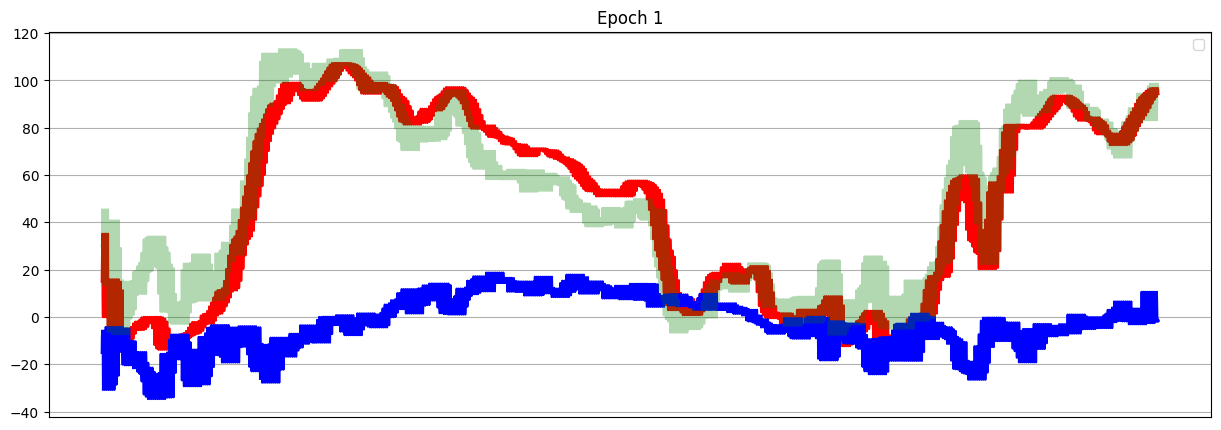

| epoch   2 |    53/  269 batches | lr 0.000490 | 207.98 ms | loss 0.50320 | ppl     1.65
| epoch   2 |   106/  269 batches | lr 0.000490 | 200.79 ms | loss 0.07978 | ppl     1.08
| epoch   2 |   159/  269 batches | lr 0.000490 | 200.91 ms | loss 0.36964 | ppl     1.45
| epoch   2 |   212/  269 batches | lr 0.000490 | 181.22 ms | loss 0.48019 | ppl     1.62
| epoch   2 |   265/  269 batches | lr 0.000490 | 202.96 ms | loss 0.36948 | ppl     1.45
-----------------------------------------------------------------------------------------
| Epoch   2 | Time: 134.03s | Val Loss: 0.12424 | Val PPL:     1.13
-----------------------------------------------------------------------------------------
Forecast - red | Fact - blue | Error - green


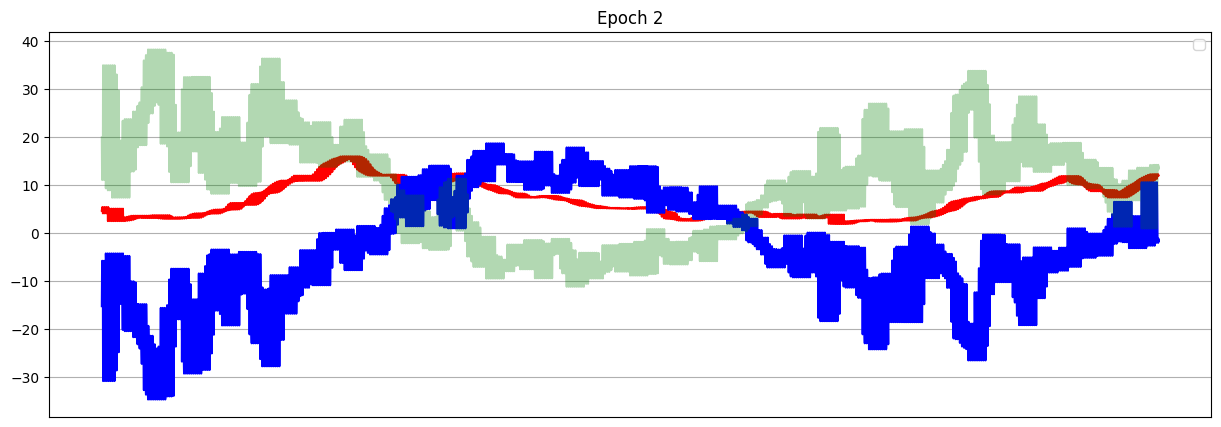

| epoch   3 |    53/  269 batches | lr 0.000480 | 197.83 ms | loss 0.19080 | ppl     1.21
| epoch   3 |   106/  269 batches | lr 0.000480 | 192.63 ms | loss 0.28171 | ppl     1.33
| epoch   3 |   159/  269 batches | lr 0.000480 | 200.71 ms | loss 0.15840 | ppl     1.17
| epoch   3 |   212/  269 batches | lr 0.000480 | 203.14 ms | loss 0.16289 | ppl     1.18
| epoch   3 |   265/  269 batches | lr 0.000480 | 204.41 ms | loss 0.18429 | ppl     1.20
-----------------------------------------------------------------------------------------
| Epoch   3 | Time: 132.14s | Val Loss: 0.05992 | Val PPL:     1.06
-----------------------------------------------------------------------------------------
Forecast - red | Fact - blue | Error - green


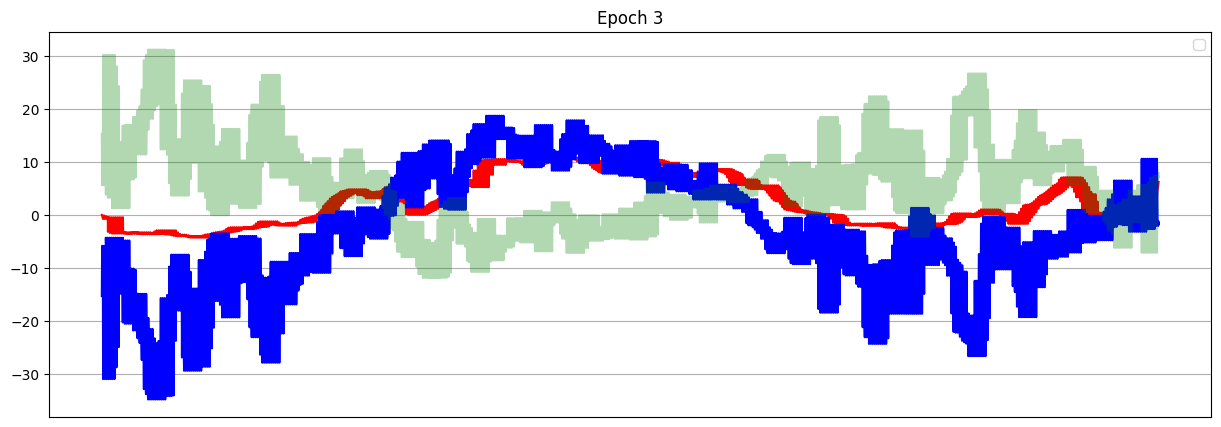

| epoch   4 |    53/  269 batches | lr 0.000471 | 208.67 ms | loss 0.11282 | ppl     1.12
| epoch   4 |   106/  269 batches | lr 0.000471 | 204.98 ms | loss 0.17829 | ppl     1.20
| epoch   4 |   159/  269 batches | lr 0.000471 | 206.48 ms | loss 0.09095 | ppl     1.10
| epoch   4 |   212/  269 batches | lr 0.000471 | 200.06 ms | loss 0.14683 | ppl     1.16
| epoch   4 |   265/  269 batches | lr 0.000471 | 193.31 ms | loss 0.07683 | ppl     1.08
-----------------------------------------------------------------------------------------
| Epoch   4 | Time: 133.51s | Val Loss: 0.09194 | Val PPL:     1.10
-----------------------------------------------------------------------------------------
| epoch   5 |    53/  269 batches | lr 0.000461 | 197.72 ms | loss 0.13046 | ppl     1.14
| epoch   5 |   106/  269 batches | lr 0.000461 | 207.19 ms | loss 0.08315 | ppl     1.09
| epoch   5 |   159/  269 batches | lr 0.000461 | 205.21 ms | loss 0.06307 | ppl     1.07
| epoch   5 |   212/  269 batche

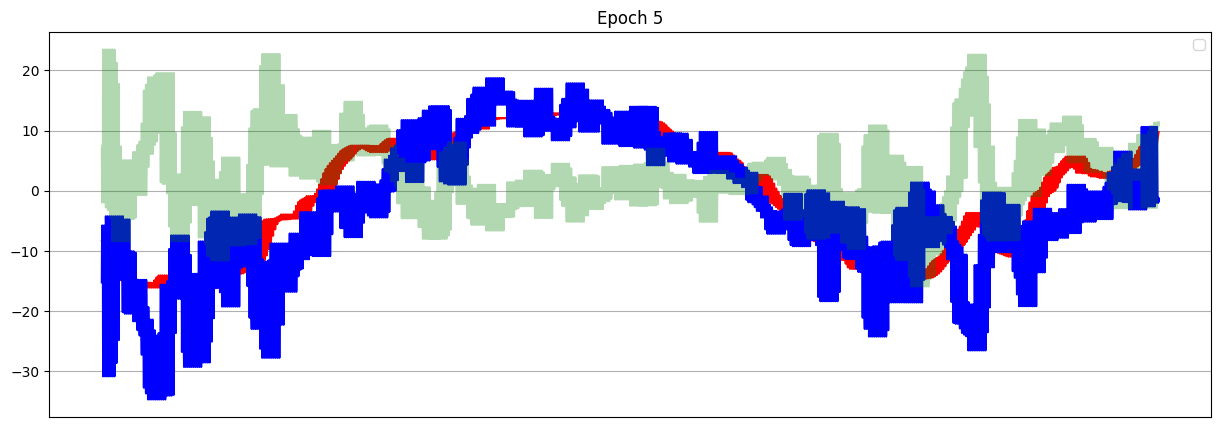

| epoch   6 |    53/  269 batches | lr 0.000452 | 210.02 ms | loss 0.05195 | ppl     1.05
| epoch   6 |   106/  269 batches | lr 0.000452 | 207.35 ms | loss 0.07245 | ppl     1.08
| epoch   6 |   159/  269 batches | lr 0.000452 | 209.41 ms | loss 0.03687 | ppl     1.04
| epoch   6 |   212/  269 batches | lr 0.000452 | 202.77 ms | loss 0.05779 | ppl     1.06
| epoch   6 |   265/  269 batches | lr 0.000452 | 193.12 ms | loss 0.07124 | ppl     1.07
-----------------------------------------------------------------------------------------
| Epoch   6 | Time: 134.47s | Val Loss: 0.05771 | Val PPL:     1.06
-----------------------------------------------------------------------------------------
| epoch   7 |    53/  269 batches | lr 0.000443 | 195.59 ms | loss 0.05769 | ppl     1.06
| epoch   7 |   106/  269 batches | lr 0.000443 | 208.78 ms | loss 0.06319 | ppl     1.07
| epoch   7 |   159/  269 batches | lr 0.000443 | 210.00 ms | loss 0.04446 | ppl     1.05
| epoch   7 |   212/  269 batche

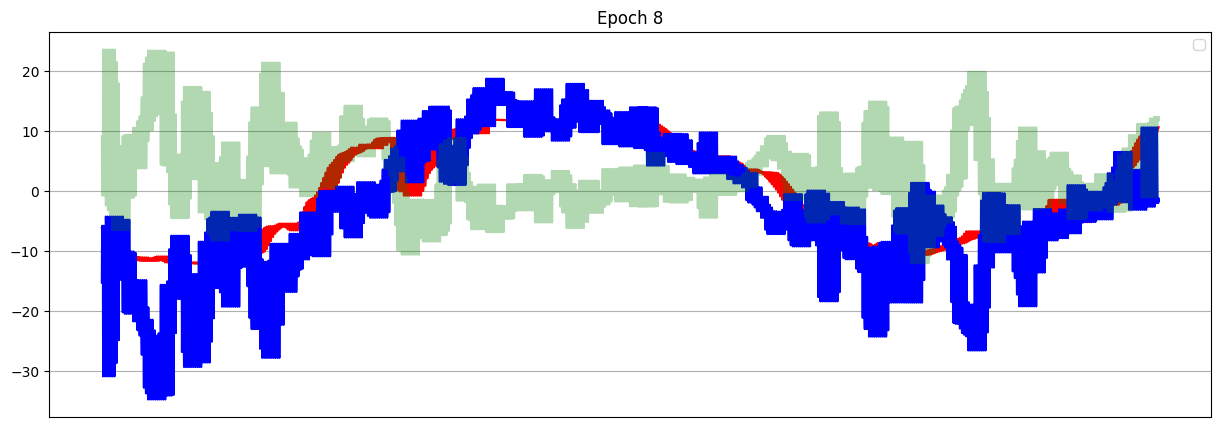

| epoch   9 |    53/  269 batches | lr 0.000425 | 201.13 ms | loss 0.05728 | ppl     1.06
| epoch   9 |   106/  269 batches | lr 0.000425 | 191.89 ms | loss 0.04816 | ppl     1.05
| epoch   9 |   159/  269 batches | lr 0.000425 | 203.77 ms | loss 0.06141 | ppl     1.06
| epoch   9 |   212/  269 batches | lr 0.000425 | 201.98 ms | loss 0.05058 | ppl     1.05
| epoch   9 |   265/  269 batches | lr 0.000425 | 203.67 ms | loss 0.05768 | ppl     1.06
-----------------------------------------------------------------------------------------
| Epoch   9 | Time: 132.33s | Val Loss: 0.05922 | Val PPL:     1.06
-----------------------------------------------------------------------------------------
| epoch  10 |    53/  269 batches | lr 0.000417 | 209.13 ms | loss 0.04245 | ppl     1.04
| epoch  10 |   106/  269 batches | lr 0.000417 | 203.64 ms | loss 0.07285 | ppl     1.08
| epoch  10 |   159/  269 batches | lr 0.000417 | 198.30 ms | loss 0.05110 | ppl     1.05
| epoch  10 |   212/  269 batche

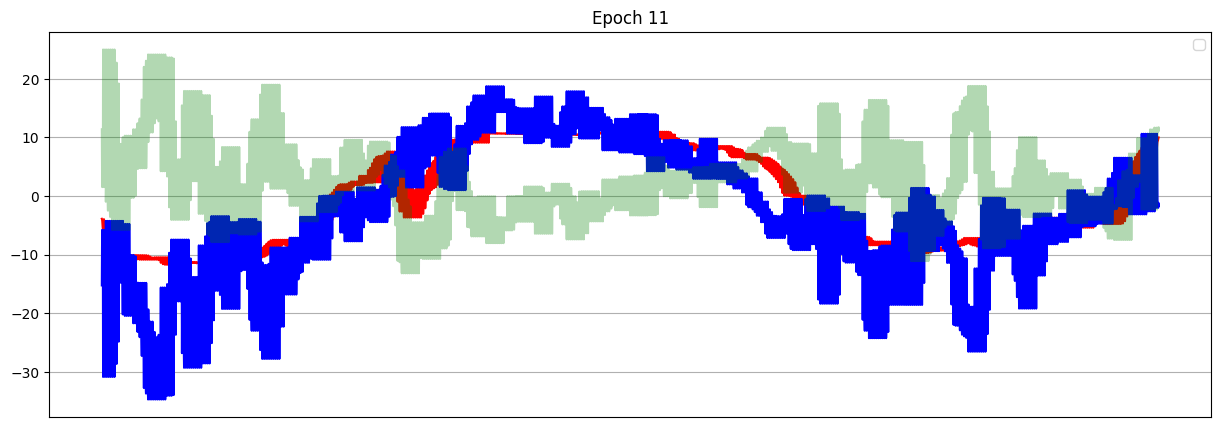

| epoch  12 |    53/  269 batches | lr 0.000400 | 208.80 ms | loss 0.04354 | ppl     1.04
| epoch  12 |   106/  269 batches | lr 0.000400 | 203.55 ms | loss 0.05225 | ppl     1.05
| epoch  12 |   159/  269 batches | lr 0.000400 | 189.63 ms | loss 0.05459 | ppl     1.06
| epoch  12 |   212/  269 batches | lr 0.000400 | 205.42 ms | loss 0.05911 | ppl     1.06
| epoch  12 |   265/  269 batches | lr 0.000400 | 206.79 ms | loss 0.03970 | ppl     1.04
-----------------------------------------------------------------------------------------
| Epoch  12 | Time: 132.63s | Val Loss: 0.10682 | Val PPL:     1.11
-----------------------------------------------------------------------------------------
| epoch  13 |    53/  269 batches | lr 0.000392 | 211.01 ms | loss 0.06198 | ppl     1.06
| epoch  13 |   106/  269 batches | lr 0.000392 | 205.50 ms | loss 0.05574 | ppl     1.06
| epoch  13 |   159/  269 batches | lr 0.000392 | 204.49 ms | loss 0.03486 | ppl     1.04
| epoch  13 |   212/  269 batche

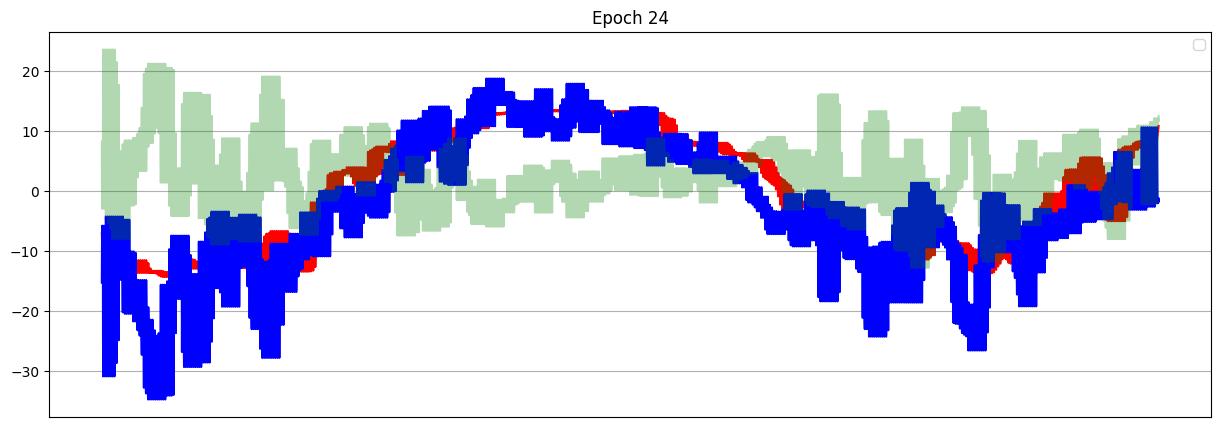

| epoch  25 |    53/  269 batches | lr 0.000308 | 240.14 ms | loss 0.02794 | ppl     1.03
| epoch  25 |   106/  269 batches | lr 0.000308 | 227.81 ms | loss 0.03605 | ppl     1.04
| epoch  25 |   159/  269 batches | lr 0.000308 | 234.91 ms | loss 0.02889 | ppl     1.03
| epoch  25 |   212/  269 batches | lr 0.000308 | 227.89 ms | loss 0.03851 | ppl     1.04
| epoch  25 |   265/  269 batches | lr 0.000308 | 233.18 ms | loss 0.03567 | ppl     1.04
-----------------------------------------------------------------------------------------
| Epoch  25 | Time: 140.73s | Val Loss: 0.04273 | Val PPL:     1.04
-----------------------------------------------------------------------------------------
| epoch  26 |    53/  269 batches | lr 0.000302 | 241.02 ms | loss 0.02587 | ppl     1.03
| epoch  26 |   106/  269 batches | lr 0.000302 | 231.81 ms | loss 0.03532 | ppl     1.04
| epoch  26 |   159/  269 batches | lr 0.000302 | 234.70 ms | loss 0.02643 | ppl     1.03
| epoch  26 |   212/  269 batche

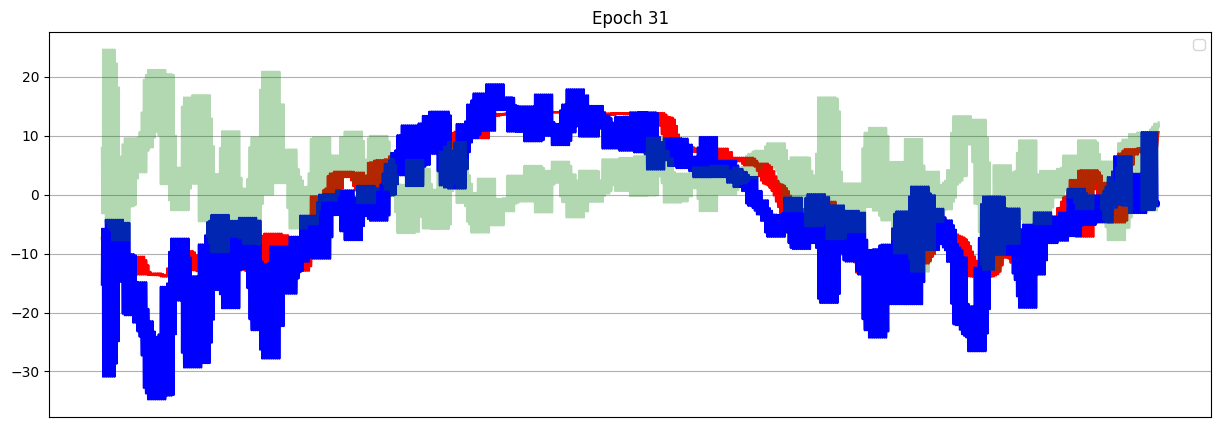

| epoch  32 |    53/  269 batches | lr 0.000267 | 255.42 ms | loss 0.02547 | ppl     1.03
| epoch  32 |   106/  269 batches | lr 0.000267 | 246.21 ms | loss 0.03053 | ppl     1.03
| epoch  32 |   159/  269 batches | lr 0.000267 | 251.78 ms | loss 0.02435 | ppl     1.02
| epoch  32 |   212/  269 batches | lr 0.000267 | 252.70 ms | loss 0.03253 | ppl     1.03
| epoch  32 |   265/  269 batches | lr 0.000267 | 251.53 ms | loss 0.02974 | ppl     1.03
-----------------------------------------------------------------------------------------
| Epoch  32 | Time: 145.14s | Val Loss: 0.03894 | Val PPL:     1.04
-----------------------------------------------------------------------------------------
| epoch  33 |    53/  269 batches | lr 0.000262 | 262.40 ms | loss 0.02421 | ppl     1.02
| epoch  33 |   106/  269 batches | lr 0.000262 | 247.23 ms | loss 0.02868 | ppl     1.03
| epoch  33 |   159/  269 batches | lr 0.000262 | 254.38 ms | loss 0.02518 | ppl     1.03
| epoch  33 |   212/  269 batche

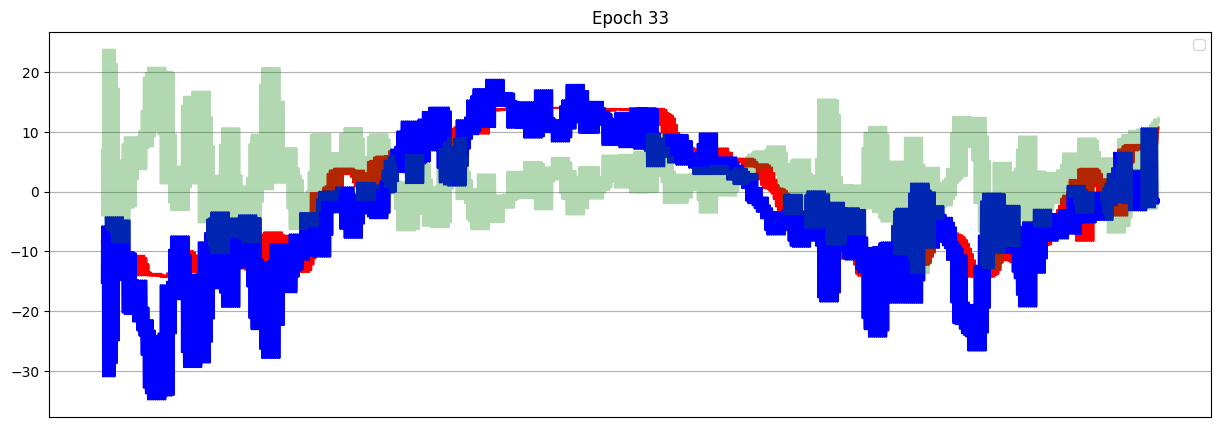

| epoch  34 |    53/  269 batches | lr 0.000257 | 263.99 ms | loss 0.02480 | ppl     1.03
| epoch  34 |   106/  269 batches | lr 0.000257 | 246.76 ms | loss 0.02891 | ppl     1.03
| epoch  34 |   159/  269 batches | lr 0.000257 | 252.99 ms | loss 0.02342 | ppl     1.02
| epoch  34 |   212/  269 batches | lr 0.000257 | 253.43 ms | loss 0.03318 | ppl     1.03
| epoch  34 |   265/  269 batches | lr 0.000257 | 254.35 ms | loss 0.02967 | ppl     1.03
-----------------------------------------------------------------------------------------
| Epoch  34 | Time: 145.94s | Val Loss: 0.03614 | Val PPL:     1.04
-----------------------------------------------------------------------------------------
| epoch  35 |    53/  269 batches | lr 0.000252 | 258.63 ms | loss 0.02361 | ppl     1.02
| epoch  35 |   106/  269 batches | lr 0.000252 | 249.62 ms | loss 0.02740 | ppl     1.03
| epoch  35 |   159/  269 batches | lr 0.000252 | 260.08 ms | loss 0.02494 | ppl     1.03
| epoch  35 |   212/  269 batche

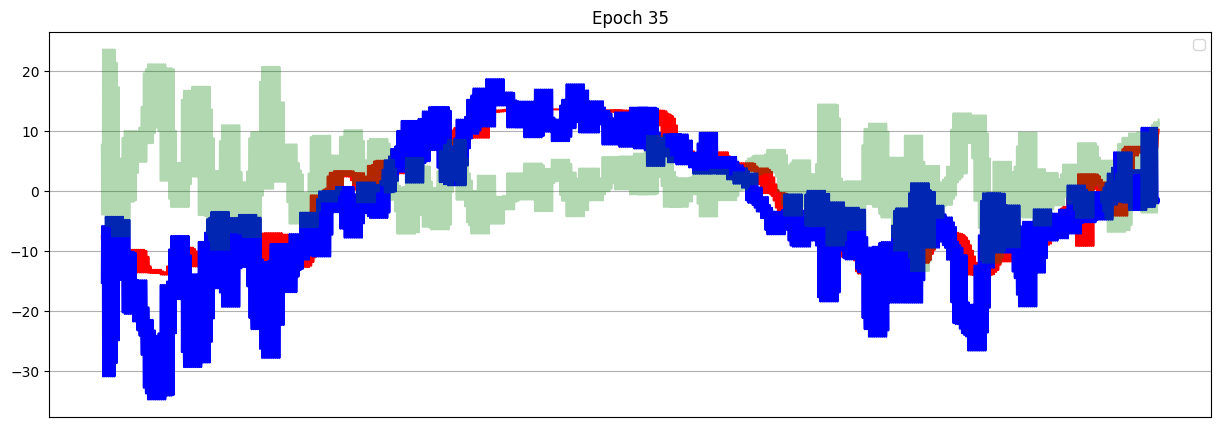

| epoch  36 |    53/  269 batches | lr 0.000247 | 267.97 ms | loss 0.02434 | ppl     1.02
| epoch  36 |   106/  269 batches | lr 0.000247 | 250.17 ms | loss 0.02805 | ppl     1.03
| epoch  36 |   159/  269 batches | lr 0.000247 | 261.83 ms | loss 0.02247 | ppl     1.02
| epoch  36 |   212/  269 batches | lr 0.000247 | 259.43 ms | loss 0.03306 | ppl     1.03
| epoch  36 |   265/  269 batches | lr 0.000247 | 264.86 ms | loss 0.02976 | ppl     1.03
-----------------------------------------------------------------------------------------
| Epoch  36 | Time: 148.32s | Val Loss: 0.03458 | Val PPL:     1.04
-----------------------------------------------------------------------------------------
| epoch  37 |    53/  269 batches | lr 0.000242 | 276.59 ms | loss 0.02282 | ppl     1.02
| epoch  37 |   106/  269 batches | lr 0.000242 | 254.94 ms | loss 0.02643 | ppl     1.03
| epoch  37 |   159/  269 batches | lr 0.000242 | 268.58 ms | loss 0.02366 | ppl     1.02
| epoch  37 |   212/  269 batche

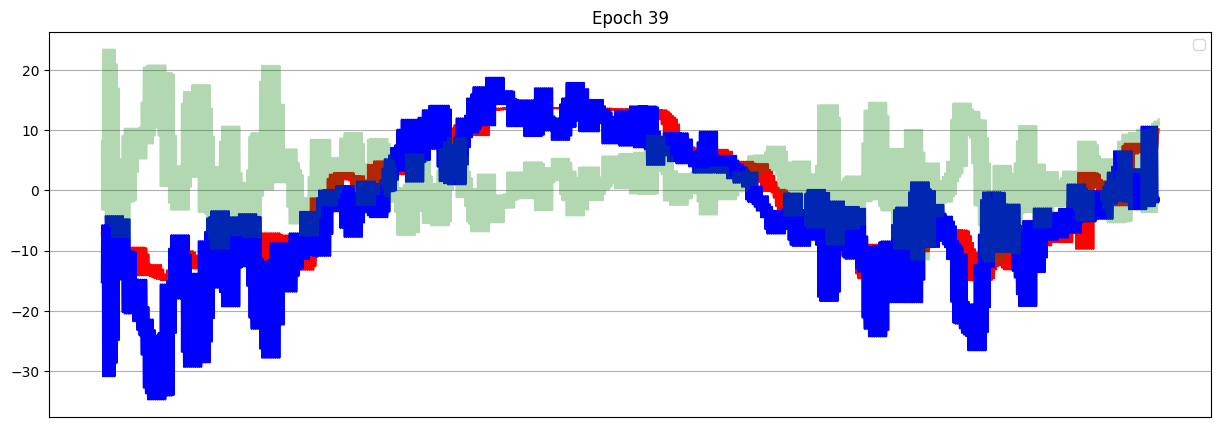

| epoch  40 |    53/  269 batches | lr 0.000227 | 283.74 ms | loss 0.02187 | ppl     1.02
| epoch  40 |   106/  269 batches | lr 0.000227 | 268.99 ms | loss 0.02578 | ppl     1.03
| epoch  40 |   159/  269 batches | lr 0.000227 | 298.28 ms | loss 0.02161 | ppl     1.02
| epoch  40 |   212/  269 batches | lr 0.000227 | 275.66 ms | loss 0.03278 | ppl     1.03
| epoch  40 |   265/  269 batches | lr 0.000227 | 278.21 ms | loss 0.02774 | ppl     1.03
-----------------------------------------------------------------------------------------
| Epoch  40 | Time: 153.46s | Val Loss: 0.03474 | Val PPL:     1.04
-----------------------------------------------------------------------------------------
| epoch  41 |    53/  269 batches | lr 0.000223 | 287.37 ms | loss 0.02114 | ppl     1.02
| epoch  41 |   106/  269 batches | lr 0.000223 | 269.90 ms | loss 0.02592 | ppl     1.03
| epoch  41 |   159/  269 batches | lr 0.000223 | 295.39 ms | loss 0.02109 | ppl     1.02
| epoch  41 |   212/  269 batche

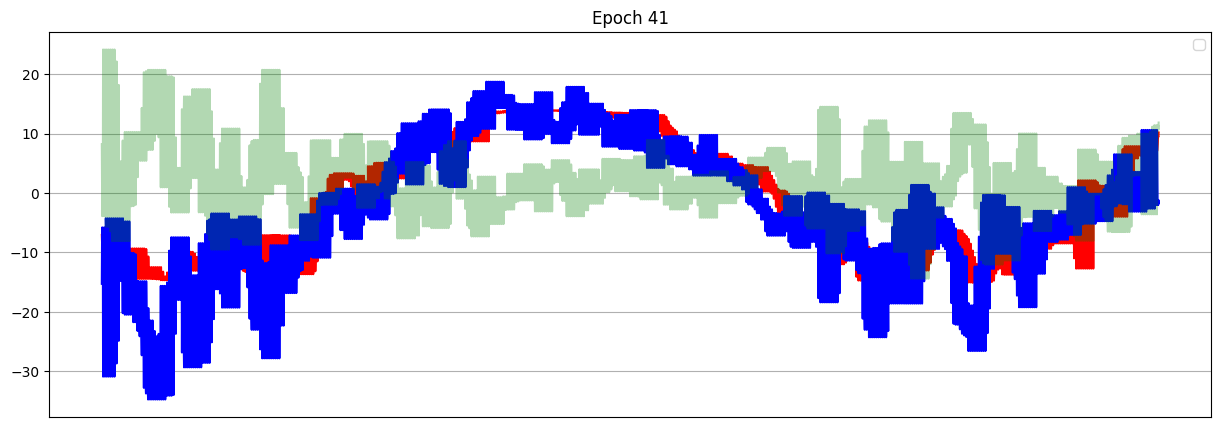

| epoch  42 |    53/  269 batches | lr 0.000218 | 303.57 ms | loss 0.02099 | ppl     1.02
| epoch  42 |   106/  269 batches | lr 0.000218 | 276.22 ms | loss 0.02535 | ppl     1.03
| epoch  42 |   159/  269 batches | lr 0.000218 | 287.19 ms | loss 0.02073 | ppl     1.02
| epoch  42 |   212/  269 batches | lr 0.000218 | 279.26 ms | loss 0.03407 | ppl     1.03
| epoch  42 |   265/  269 batches | lr 0.000218 | 275.87 ms | loss 0.02874 | ppl     1.03
-----------------------------------------------------------------------------------------
| Epoch  42 | Time: 154.24s | Val Loss: 0.03266 | Val PPL:     1.03
-----------------------------------------------------------------------------------------
| epoch  43 |    53/  269 batches | lr 0.000214 | 301.82 ms | loss 0.02058 | ppl     1.02
| epoch  43 |   106/  269 batches | lr 0.000214 | 276.00 ms | loss 0.02483 | ppl     1.03
| epoch  43 |   159/  269 batches | lr 0.000214 | 289.18 ms | loss 0.02053 | ppl     1.02
| epoch  43 |   212/  269 batche

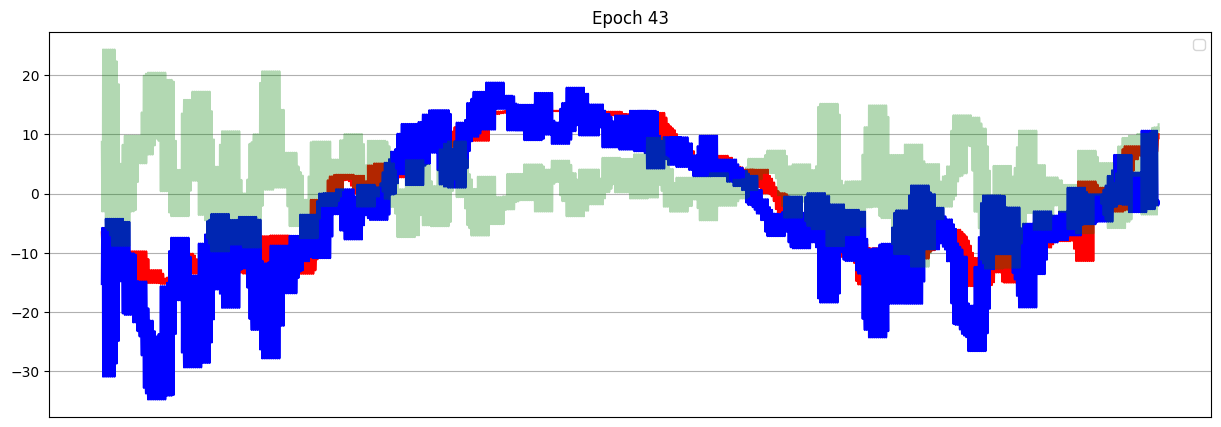

| epoch  44 |    53/  269 batches | lr 0.000210 | 284.73 ms | loss 0.01951 | ppl     1.02
| epoch  44 |   106/  269 batches | lr 0.000210 | 271.61 ms | loss 0.02383 | ppl     1.02
| epoch  44 |   159/  269 batches | lr 0.000210 | 287.40 ms | loss 0.02071 | ppl     1.02
| epoch  44 |   212/  269 batches | lr 0.000210 | 280.48 ms | loss 0.03249 | ppl     1.03
| epoch  44 |   265/  269 batches | lr 0.000210 | 288.58 ms | loss 0.02827 | ppl     1.03
-----------------------------------------------------------------------------------------
| Epoch  44 | Time: 153.70s | Val Loss: 0.03163 | Val PPL:     1.03
-----------------------------------------------------------------------------------------
| epoch  45 |    53/  269 batches | lr 0.000206 | 281.97 ms | loss 0.01973 | ppl     1.02
| epoch  45 |   106/  269 batches | lr 0.000206 | 269.37 ms | loss 0.02389 | ppl     1.02
| epoch  45 |   159/  269 batches | lr 0.000206 | 285.83 ms | loss 0.02027 | ppl     1.02
| epoch  45 |   212/  269 batche

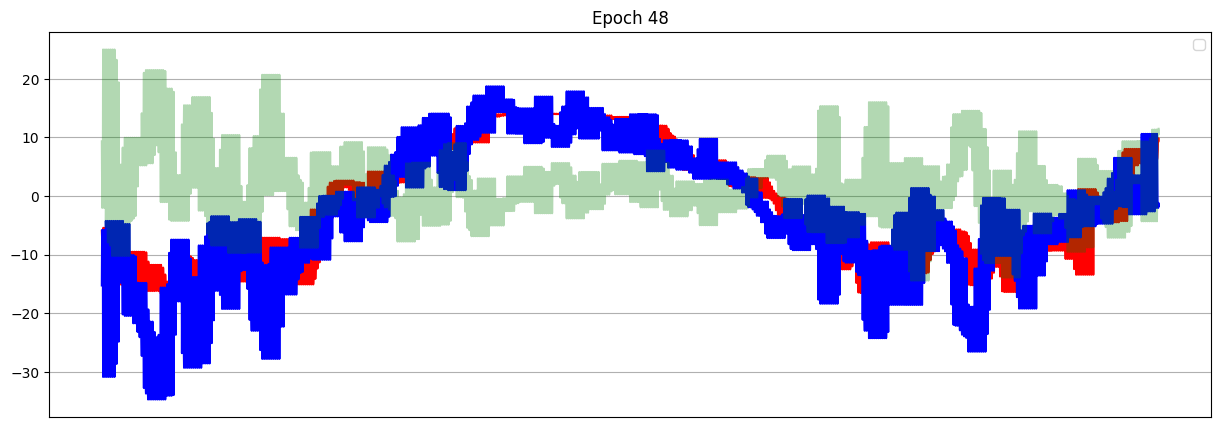

| epoch  49 |    53/  269 batches | lr 0.000190 | 287.77 ms | loss 0.01821 | ppl     1.02
| epoch  49 |   106/  269 batches | lr 0.000190 | 289.63 ms | loss 0.02380 | ppl     1.02
| epoch  49 |   159/  269 batches | lr 0.000190 | 291.85 ms | loss 0.01998 | ppl     1.02
| epoch  49 |   212/  269 batches | lr 0.000190 | 286.20 ms | loss 0.03000 | ppl     1.03
| epoch  49 |   265/  269 batches | lr 0.000190 | 281.44 ms | loss 0.02785 | ppl     1.03
-----------------------------------------------------------------------------------------
| Epoch  49 | Time: 155.01s | Val Loss: 0.03129 | Val PPL:     1.03
-----------------------------------------------------------------------------------------
| epoch  50 |    53/  269 batches | lr 0.000186 | 312.17 ms | loss 0.01860 | ppl     1.02
| epoch  50 |   106/  269 batches | lr 0.000186 | 277.88 ms | loss 0.02265 | ppl     1.02
| epoch  50 |   159/  269 batches | lr 0.000186 | 291.86 ms | loss 0.01963 | ppl     1.02
| epoch  50 |   212/  269 batche

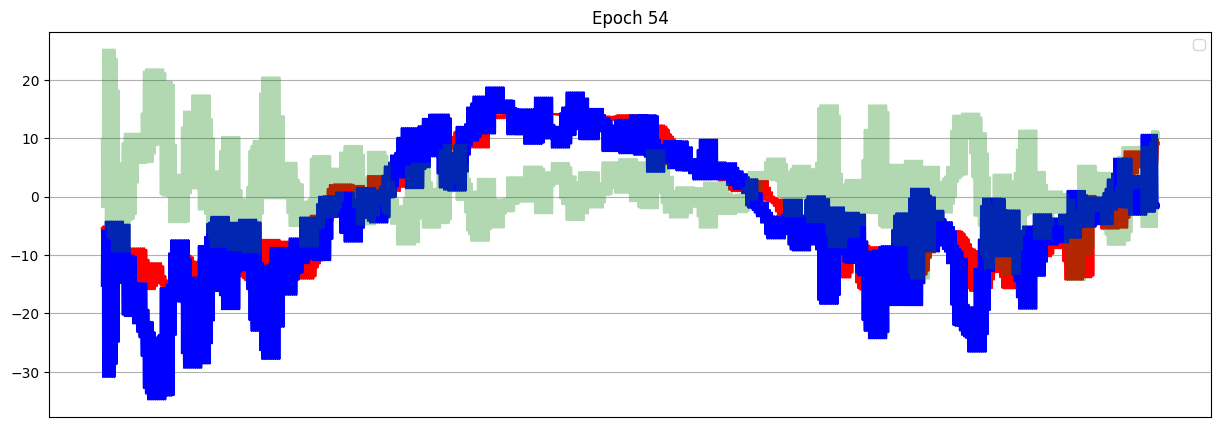

| epoch  55 |    53/  269 batches | lr 0.000168 | 294.03 ms | loss 0.01876 | ppl     1.02
| epoch  55 |   106/  269 batches | lr 0.000168 | 280.09 ms | loss 0.02332 | ppl     1.02
| epoch  55 |   159/  269 batches | lr 0.000168 | 301.32 ms | loss 0.01972 | ppl     1.02
| epoch  55 |   212/  269 batches | lr 0.000168 | 308.80 ms | loss 0.02968 | ppl     1.03
| epoch  55 |   265/  269 batches | lr 0.000168 | 282.42 ms | loss 0.02771 | ppl     1.03
-----------------------------------------------------------------------------------------
| Epoch  55 | Time: 156.73s | Val Loss: 0.03129 | Val PPL:     1.03
-----------------------------------------------------------------------------------------
| epoch  56 |    53/  269 batches | lr 0.000165 | 297.46 ms | loss 0.01773 | ppl     1.02
| epoch  56 |   106/  269 batches | lr 0.000165 | 299.15 ms | loss 0.02241 | ppl     1.02
| epoch  56 |   159/  269 batches | lr 0.000165 | 293.94 ms | loss 0.01881 | ppl     1.02
| epoch  56 |   212/  269 batche

In [ ]:
import torch
import torch.nn as nn
import math
import numpy as np
import pandas as pd
import time
from matplotlib import pyplot
from sklearn.preprocessing import MinMaxScaler
from torch.nn.init import uniform_

class Config:
    input_window = 100
    output_window = 5
    batch_size = 10
    feature_size = 250
    num_layers = 1
    dropout = 0.1
    lr = 0.0005
    epochs = 100
    calculate_loss_over_all_values = False

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
config = Config()

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super().__init__()
        position = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))
        pe = torch.zeros(max_len, 1, d_model)
        pe[:, 0, 0::2] = torch.sin(position * div_term)
        pe[:, 0, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe)

    def forward(self, x):
        return x + self.pe[:x.size(0)]

class TransAm(nn.Module):
    def __init__(self, feature_size=250, num_layers=1, dropout=0.1):
        super().__init__()
        self.model_type = 'Transformer'
        self.pos_encoder = PositionalEncoding(feature_size)
        self.encoder_layer = nn.TransformerEncoderLayer(
            d_model=feature_size, nhead=10, dropout=dropout, batch_first=False
        )
        self.transformer_encoder = nn.TransformerEncoder(
            self.encoder_layer, num_layers=num_layers
        )
        self.decoder = nn.Linear(feature_size, 1)
        self.init_weights()
        self.src_mask = None

    def init_weights(self):
        initrange = 0.1
        self.decoder.bias.data.zero_()
        uniform_(self.decoder.weight.data, -initrange, initrange)

    def forward(self, src):
        if self.src_mask is None or self.src_mask.size(0) != len(src):
            self.src_mask = self._generate_square_subsequent_mask(len(src)).to(src.device)

        src = self.pos_encoder(src)
        output = self.transformer_encoder(src, self.src_mask)
        return self.decoder(output)

    def _generate_square_subsequent_mask(self, sz):
        return torch.triu(torch.full((sz, sz), float('-inf')), diagonal=1)

def create_inout_sequences(input_data, window_size):
    L = len(input_data)
    sequences = []
    for i in range(L - window_size):
        seq = np.append(
            input_data[i:i+window_size][:-config.output_window],
            config.output_window * [0]
        )
        label = input_data[i:i+window_size]
        sequences.append((seq, label))
    return torch.FloatTensor(sequences)

def load_and_preprocess_data():
    df = pd.read_csv('./data/tes_osnova.csv')
    df.rename(columns={'dt': 'Date', 'temp': 'Temp'}, inplace=True)
    df['Date'] = pd.to_datetime(df['Date']).dt.date
    dates = df['Date'].unique()

    df = df.groupby('Date')['Temp'].min().reset_index()
    df = df.set_index('Date')

    scaler = MinMaxScaler(feature_range=(-1, 1))
    amplitude = scaler.fit_transform(df['Temp'].values.reshape(-1, 1)).flatten()

    train_data = amplitude[:2800]
    test_data = amplitude[2800:]

    train_sequence = create_inout_sequences(train_data, config.input_window)
    train_sequence = train_sequence[:-config.output_window]

    test_data = create_inout_sequences(test_data, config.input_window)
    test_data = test_data[:-config.output_window]

    return train_sequence.to(device), test_data.to(device), scaler


def get_batch(source, i):
    seq_len = min(config.batch_size, len(source) - 1 - i)
    data = source[i:i+seq_len]
    inputs = torch.stack([item[0] for item in data]).unsqueeze(-1)
    targets = torch.stack([item[1] for item in data]).unsqueeze(-1)
    return inputs.transpose(0, 1), targets.transpose(0, 1)

def train_epoch(model, train_data, optimizer, criterion, scheduler):
    model.train()
    total_loss = 0.
    log_interval = max(1, len(train_data) // config.batch_size // 5)
    start_time = time.time()

    for batch, i in enumerate(range(0, len(train_data) - 1, config.batch_size)):
        data, targets = get_batch(train_data, i)
        optimizer.zero_grad()

        output = model(data)
        loss = criterion(
            output[-config.output_window:],
            targets[-config.output_window:]
        ) if not config.calculate_loss_over_all_values else criterion(output, targets)

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 0.5)
        optimizer.step()

        total_loss += loss.item()

        if batch % log_interval == 0 and batch > 0:
            avg_loss = total_loss / log_interval
            elapsed = time.time() - start_time
            print(f'| epoch {epoch:3d} | {batch:5d}/{len(train_data)//config.batch_size:5d} batches | '
                  f'lr {scheduler.get_last_lr()[0]:02.6f} | {elapsed*1000/log_interval:5.2f} ms | '
                  f'loss {avg_loss:5.5f} | ppl {math.exp(avg_loss):8.2f}')
            total_loss = 0
            start_time = time.time()

def evaluate_model(model, data_source, criterion):
    model.eval()
    total_loss = 0.
    eval_batch_size = config.batch_size
    with torch.no_grad():
        for i in range(0, len(data_source) - 1, eval_batch_size):
            data, targets = get_batch(data_source, i)
            output = model(data)
            if config.calculate_loss_over_all_values:
                total_loss += len(data[0])* criterion(config.output, targets).cpu().item()
            else:
                total_loss += len(data[0])* criterion(output[-config.output_window:], targets[-config.output_window:]).cpu().item()
    return total_loss / len(data_source)

def plot_results(model, data_source, epoch, scaler):
    model.eval()
    predictions = []
    actuals = []

    with torch.no_grad():
        for i in range(0, min(500, len(data_source) - 1)):
            data, target = get_batch(data_source, i)
            output = model(data)
            predictions.append(output[-1].squeeze().cpu().numpy())
            actuals.append(target[-1].squeeze().cpu().numpy())

    if scaler is not None:
      predictions = scaler.inverse_transform(np.array(predictions).reshape(-1, 1)).flatten()
      actuals = scaler.inverse_transform(np.array(actuals).reshape(-1, 1)).flatten()

    print('Forecast - red | Fact - blue | Error - green')
    plt.figure(figsize=(15, 5))
    plt.plot(predictions, color="red")
    plt.plot(actuals, color="blue")
    plt.plot(np.array(predictions) - np.array(actuals), color="green", alpha=0.3)
    plt.grid(True)
    plt.legend()
    plt.title(f'Epoch {epoch}')
    plt.xticks([])
    plt.show()

train_data, val_data, scaler = load_and_preprocess_data()

model = TransAm(
    feature_size=config.feature_size,
    num_layers=config.num_layers,
    dropout=config.dropout
).to(device)

criterion = nn.MSELoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=config.lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1.0, gamma=0.98)

best_val_loss = float('inf')
best_model = None

for epoch in range(1, config.epochs + 1):
    epoch_start_time = time.time()
    train_epoch(model, train_data, optimizer, criterion, scheduler)

    val_loss = evaluate_model(model, val_data, criterion)

    print('-' * 89)
    print(f'| Epoch {epoch:3d} | Time: {time.time()-epoch_start_time:5.2f}s | '
          f'Val Loss: {val_loss:5.5f} | Val PPL: {math.exp(val_loss):8.2f}')
    print('-' * 89)

    if val_loss < best_val_loss:
        plot_results(model, val_data, epoch, scaler)
        best_val_loss = val_loss
        best_model = model.state_dict()
        torch.save({
            'epoch': epoch,
            'model_state_dict': best_model,
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': val_loss,
            'scaler_state': {
              'scale_': scaler.scale_,
              'min_': scaler.min_,
              'data_min_': scaler.data_min_,
              'data_max_': scaler.data_max_,
              'data_range_': scaler.data_range_}
        }, './model/best_model_min.pth')

    scheduler.step()

| epoch   1 |    53/  269 batches | lr 0.000500 | 212.83 ms | loss 0.76691 | ppl     2.15
| epoch   1 |   106/  269 batches | lr 0.000500 | 204.21 ms | loss 0.09065 | ppl     1.09
| epoch   1 |   159/  269 batches | lr 0.000500 | 205.34 ms | loss 0.18887 | ppl     1.21
| epoch   1 |   212/  269 batches | lr 0.000500 | 204.78 ms | loss 0.41716 | ppl     1.52
| epoch   1 |   265/  269 batches | lr 0.000500 | 203.42 ms | loss 1.04827 | ppl     2.85
-----------------------------------------------------------------------------------------
| Epoch   1 | Time: 135.02s | Val Loss: 0.30744 | Val PPL:     1.36
-----------------------------------------------------------------------------------------
Forecast - red | Fact - blue | Error - green


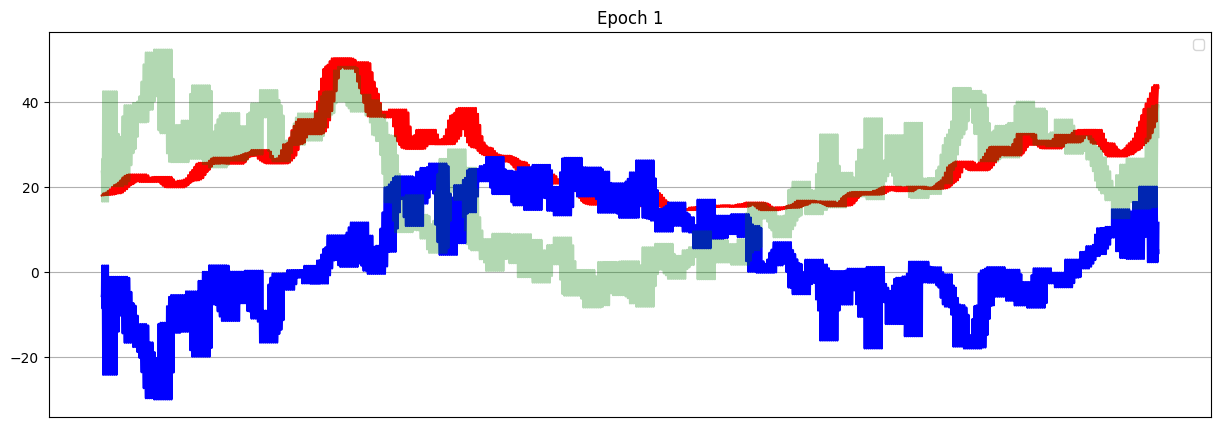

| epoch   2 |    53/  269 batches | lr 0.000490 | 234.43 ms | loss 0.14205 | ppl     1.15
| epoch   2 |   106/  269 batches | lr 0.000490 | 200.03 ms | loss 0.59791 | ppl     1.82
| epoch   2 |   159/  269 batches | lr 0.000490 | 200.09 ms | loss 0.29303 | ppl     1.34
| epoch   2 |   212/  269 batches | lr 0.000490 | 194.25 ms | loss 0.32672 | ppl     1.39
| epoch   2 |   265/  269 batches | lr 0.000490 | 188.99 ms | loss 0.32229 | ppl     1.38
-----------------------------------------------------------------------------------------
| Epoch   2 | Time: 133.12s | Val Loss: 0.13246 | Val PPL:     1.14
-----------------------------------------------------------------------------------------
Forecast - red | Fact - blue | Error - green


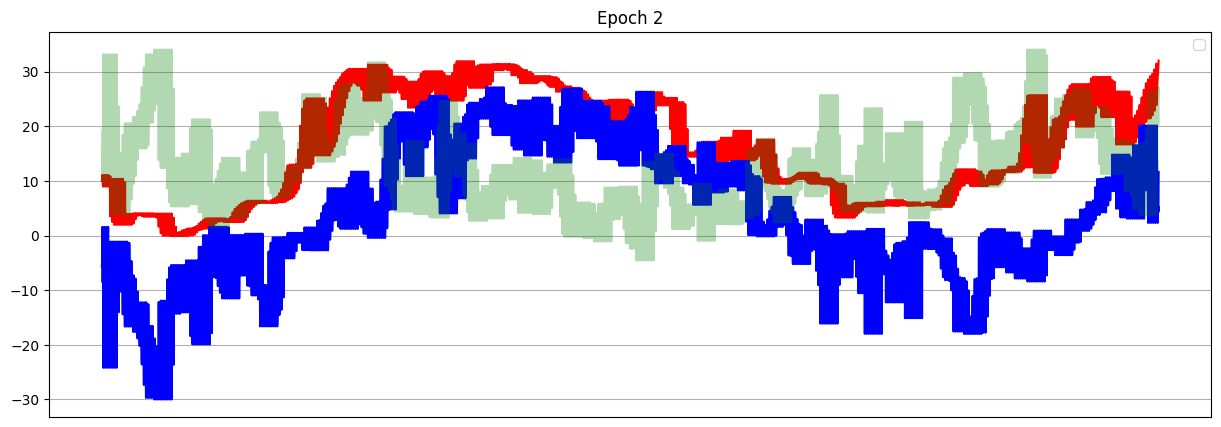

| epoch   3 |    53/  269 batches | lr 0.000480 | 205.30 ms | loss 0.06136 | ppl     1.06
| epoch   3 |   106/  269 batches | lr 0.000480 | 185.59 ms | loss 0.11989 | ppl     1.13
| epoch   3 |   159/  269 batches | lr 0.000480 | 200.77 ms | loss 0.23409 | ppl     1.26
| epoch   3 |   212/  269 batches | lr 0.000480 | 201.26 ms | loss 0.24458 | ppl     1.28
| epoch   3 |   265/  269 batches | lr 0.000480 | 203.06 ms | loss 0.22944 | ppl     1.26
-----------------------------------------------------------------------------------------
| Epoch   3 | Time: 131.68s | Val Loss: 0.11533 | Val PPL:     1.12
-----------------------------------------------------------------------------------------
Forecast - red | Fact - blue | Error - green


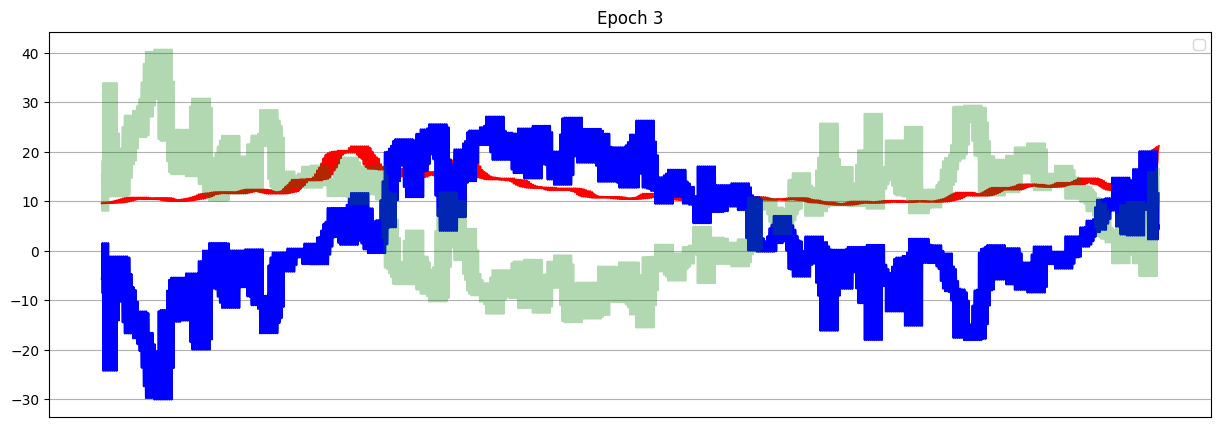

| epoch   4 |    53/  269 batches | lr 0.000471 | 209.28 ms | loss 0.21197 | ppl     1.24
| epoch   4 |   106/  269 batches | lr 0.000471 | 203.85 ms | loss 0.19120 | ppl     1.21
| epoch   4 |   159/  269 batches | lr 0.000471 | 206.27 ms | loss 0.13152 | ppl     1.14
| epoch   4 |   212/  269 batches | lr 0.000471 | 205.02 ms | loss 0.09565 | ppl     1.10
| epoch   4 |   265/  269 batches | lr 0.000471 | 192.70 ms | loss 0.22173 | ppl     1.25
-----------------------------------------------------------------------------------------
| Epoch   4 | Time: 136.98s | Val Loss: 0.26306 | Val PPL:     1.30
-----------------------------------------------------------------------------------------
| epoch   5 |    53/  269 batches | lr 0.000461 | 206.52 ms | loss 0.16223 | ppl     1.18
| epoch   5 |   106/  269 batches | lr 0.000461 | 200.93 ms | loss 0.12274 | ppl     1.13
| epoch   5 |   159/  269 batches | lr 0.000461 | 182.60 ms | loss 0.04671 | ppl     1.05
| epoch   5 |   212/  269 batche

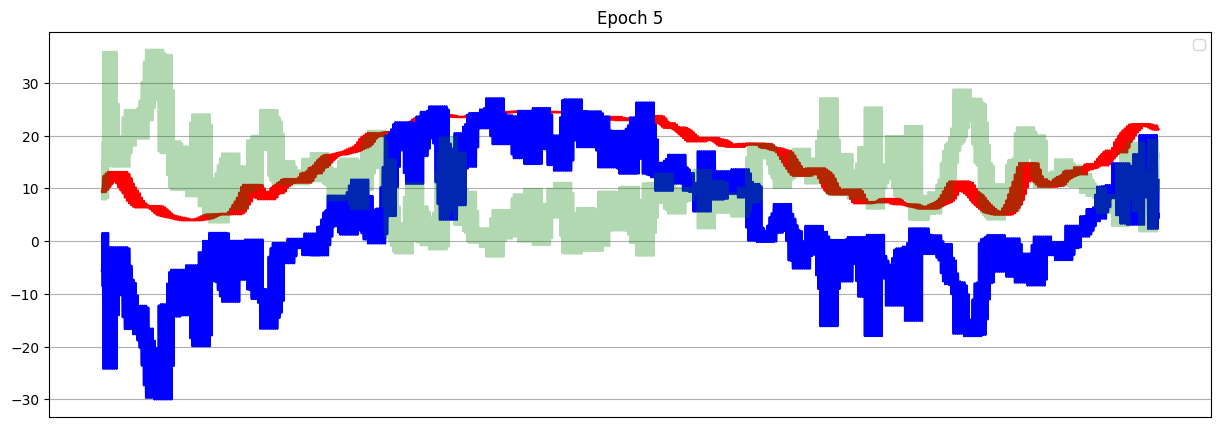

| epoch   6 |    53/  269 batches | lr 0.000452 | 194.55 ms | loss 0.07822 | ppl     1.08
| epoch   6 |   106/  269 batches | lr 0.000452 | 194.93 ms | loss 0.03588 | ppl     1.04
| epoch   6 |   159/  269 batches | lr 0.000452 | 203.69 ms | loss 0.04211 | ppl     1.04
| epoch   6 |   212/  269 batches | lr 0.000452 | 202.42 ms | loss 0.04089 | ppl     1.04
| epoch   6 |   265/  269 batches | lr 0.000452 | 201.62 ms | loss 0.03722 | ppl     1.04
-----------------------------------------------------------------------------------------
| Epoch   6 | Time: 135.50s | Val Loss: 0.06273 | Val PPL:     1.06
-----------------------------------------------------------------------------------------
Forecast - red | Fact - blue | Error - green


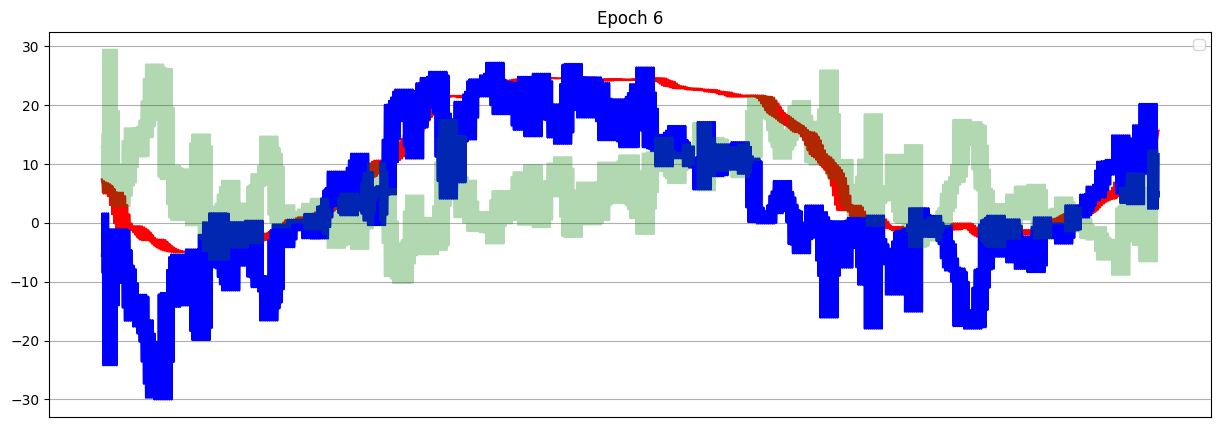

| epoch   7 |    53/  269 batches | lr 0.000443 | 205.32 ms | loss 0.06714 | ppl     1.07
| epoch   7 |   106/  269 batches | lr 0.000443 | 202.72 ms | loss 0.03123 | ppl     1.03
| epoch   7 |   159/  269 batches | lr 0.000443 | 202.08 ms | loss 0.06753 | ppl     1.07
| epoch   7 |   212/  269 batches | lr 0.000443 | 205.20 ms | loss 0.05429 | ppl     1.06
| epoch   7 |   265/  269 batches | lr 0.000443 | 203.50 ms | loss 0.04315 | ppl     1.04
-----------------------------------------------------------------------------------------
| Epoch   7 | Time: 133.42s | Val Loss: 0.06718 | Val PPL:     1.07
-----------------------------------------------------------------------------------------
| epoch   8 |    53/  269 batches | lr 0.000434 | 207.10 ms | loss 0.06781 | ppl     1.07
| epoch   8 |   106/  269 batches | lr 0.000434 | 187.03 ms | loss 0.05717 | ppl     1.06
| epoch   8 |   159/  269 batches | lr 0.000434 | 203.62 ms | loss 0.03256 | ppl     1.03
| epoch   8 |   212/  269 batche

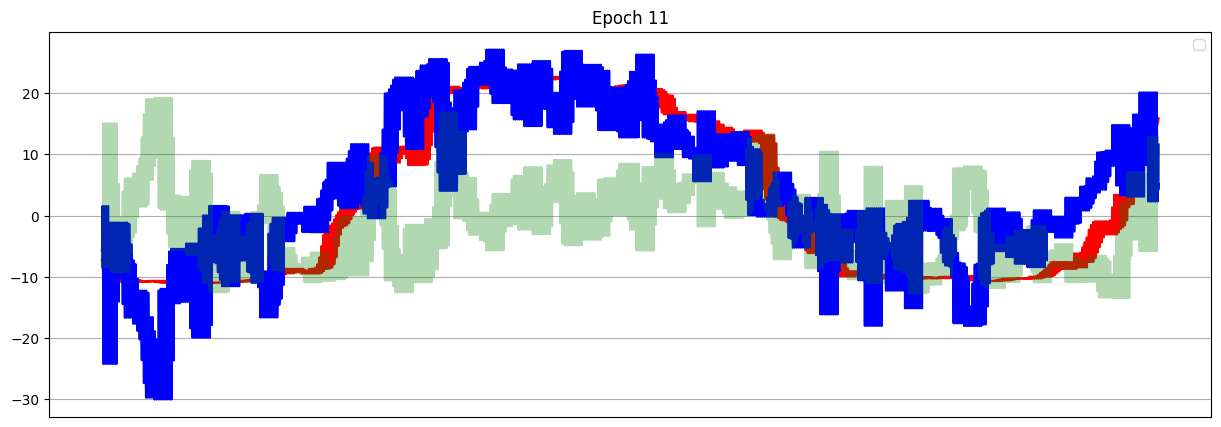

| epoch  12 |    53/  269 batches | lr 0.000400 | 201.58 ms | loss 0.07549 | ppl     1.08
| epoch  12 |   106/  269 batches | lr 0.000400 | 196.72 ms | loss 0.03141 | ppl     1.03
| epoch  12 |   159/  269 batches | lr 0.000400 | 178.79 ms | loss 0.02846 | ppl     1.03
| epoch  12 |   212/  269 batches | lr 0.000400 | 198.15 ms | loss 0.04199 | ppl     1.04
| epoch  12 |   265/  269 batches | lr 0.000400 | 197.79 ms | loss 0.04019 | ppl     1.04
-----------------------------------------------------------------------------------------
| Epoch  12 | Time: 130.50s | Val Loss: 0.05598 | Val PPL:     1.06
-----------------------------------------------------------------------------------------
| epoch  13 |    53/  269 batches | lr 0.000392 | 201.52 ms | loss 0.05341 | ppl     1.05
| epoch  13 |   106/  269 batches | lr 0.000392 | 201.17 ms | loss 0.02807 | ppl     1.03
| epoch  13 |   159/  269 batches | lr 0.000392 | 195.87 ms | loss 0.03216 | ppl     1.03
| epoch  13 |   212/  269 batche

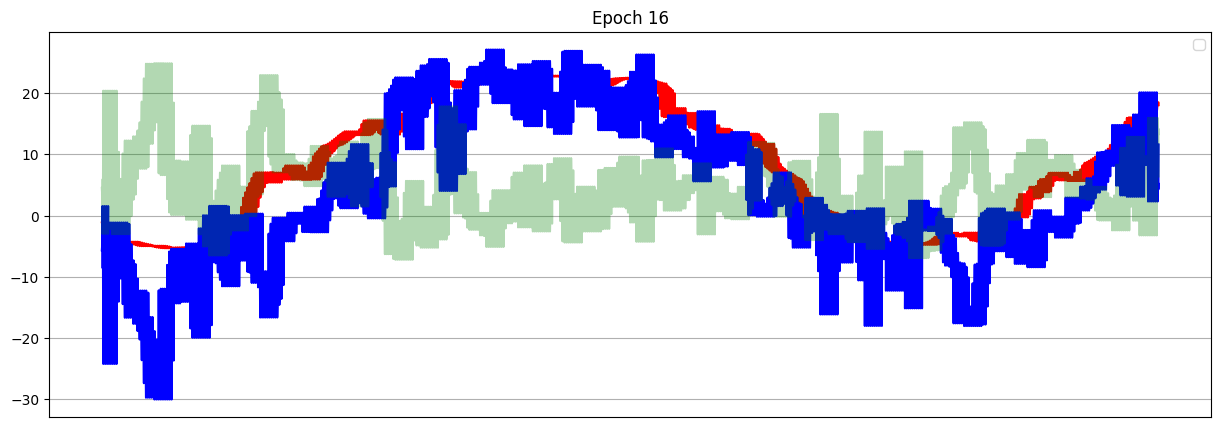

| epoch  17 |    53/  269 batches | lr 0.000362 | 208.27 ms | loss 0.02953 | ppl     1.03
| epoch  17 |   106/  269 batches | lr 0.000362 | 204.19 ms | loss 0.03496 | ppl     1.04
| epoch  17 |   159/  269 batches | lr 0.000362 | 215.02 ms | loss 0.02501 | ppl     1.03
| epoch  17 |   212/  269 batches | lr 0.000362 | 187.79 ms | loss 0.05285 | ppl     1.05
| epoch  17 |   265/  269 batches | lr 0.000362 | 202.10 ms | loss 0.02896 | ppl     1.03
-----------------------------------------------------------------------------------------
| Epoch  17 | Time: 145.74s | Val Loss: 0.04738 | Val PPL:     1.05
-----------------------------------------------------------------------------------------
| epoch  18 |    53/  269 batches | lr 0.000355 | 206.99 ms | loss 0.04036 | ppl     1.04
| epoch  18 |   106/  269 batches | lr 0.000355 | 214.55 ms | loss 0.03147 | ppl     1.03
| epoch  18 |   159/  269 batches | lr 0.000355 | 208.30 ms | loss 0.04555 | ppl     1.05
| epoch  18 |   212/  269 batche

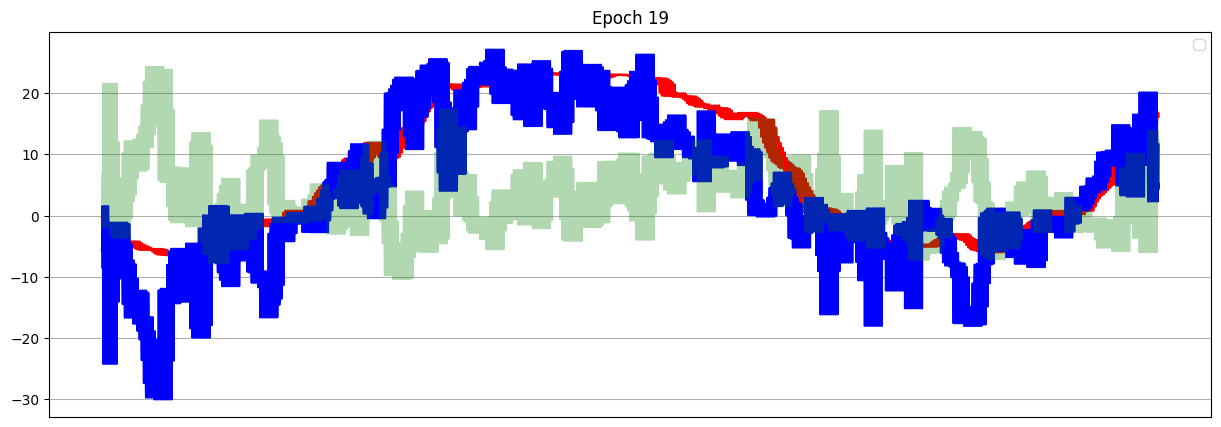

| epoch  20 |    53/  269 batches | lr 0.000341 | 220.86 ms | loss 0.03054 | ppl     1.03
| epoch  20 |   106/  269 batches | lr 0.000341 | 209.66 ms | loss 0.02510 | ppl     1.03
| epoch  20 |   159/  269 batches | lr 0.000341 | 196.94 ms | loss 0.02386 | ppl     1.02
| epoch  20 |   212/  269 batches | lr 0.000341 | 204.64 ms | loss 0.02549 | ppl     1.03
| epoch  20 |   265/  269 batches | lr 0.000341 | 206.11 ms | loss 0.02792 | ppl     1.03
-----------------------------------------------------------------------------------------
| Epoch  20 | Time: 134.25s | Val Loss: 0.02822 | Val PPL:     1.03
-----------------------------------------------------------------------------------------
Forecast - red | Fact - blue | Error - green


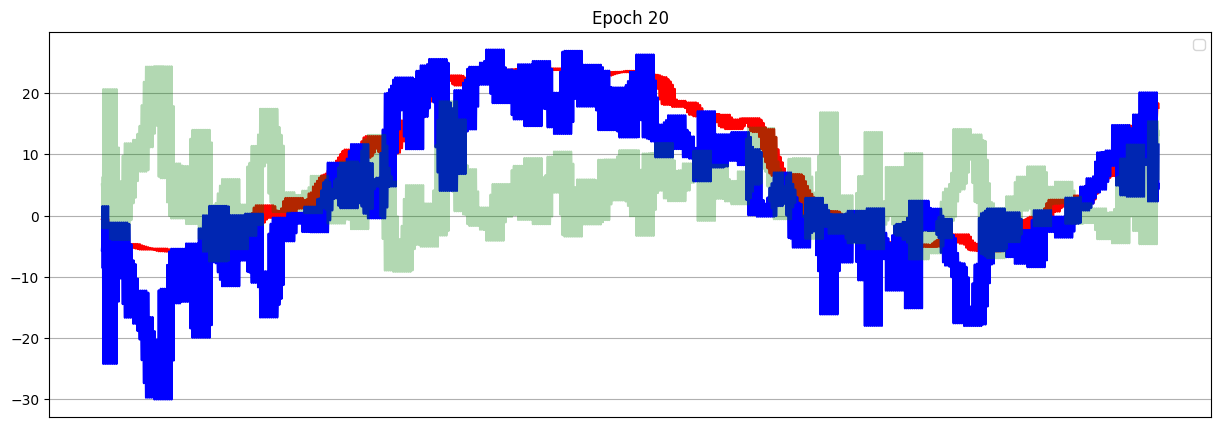

| epoch  21 |    53/  269 batches | lr 0.000334 | 212.92 ms | loss 0.02593 | ppl     1.03
| epoch  21 |   106/  269 batches | lr 0.000334 | 191.18 ms | loss 0.02328 | ppl     1.02
| epoch  21 |   159/  269 batches | lr 0.000334 | 203.81 ms | loss 0.02211 | ppl     1.02
| epoch  21 |   212/  269 batches | lr 0.000334 | 210.23 ms | loss 0.02508 | ppl     1.03
| epoch  21 |   265/  269 batches | lr 0.000334 | 210.95 ms | loss 0.03222 | ppl     1.03
-----------------------------------------------------------------------------------------
| Epoch  21 | Time: 133.30s | Val Loss: 0.02498 | Val PPL:     1.03
-----------------------------------------------------------------------------------------
Forecast - red | Fact - blue | Error - green


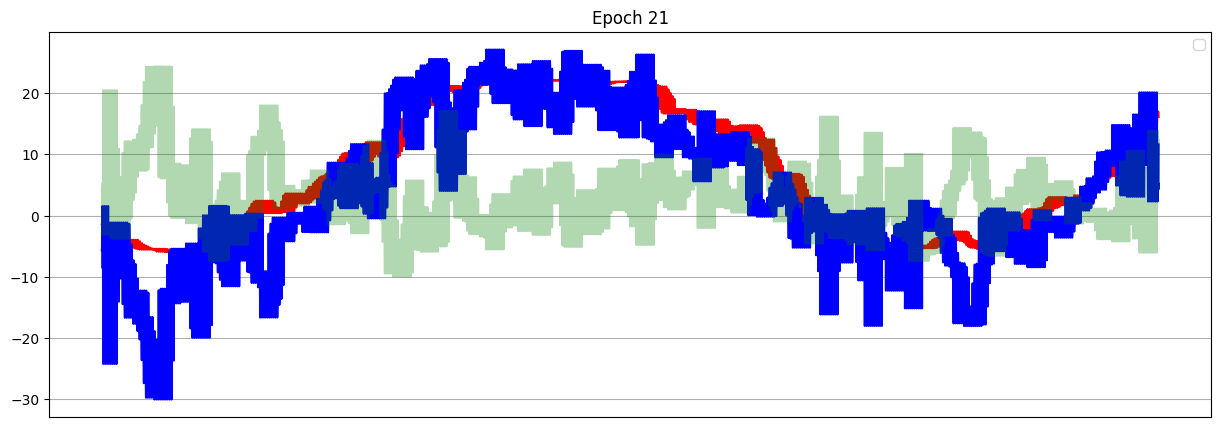

| epoch  22 |    53/  269 batches | lr 0.000327 | 213.17 ms | loss 0.02781 | ppl     1.03
| epoch  22 |   106/  269 batches | lr 0.000327 | 210.31 ms | loss 0.02698 | ppl     1.03
| epoch  22 |   159/  269 batches | lr 0.000327 | 209.45 ms | loss 0.02073 | ppl     1.02
| epoch  22 |   212/  269 batches | lr 0.000327 | 213.01 ms | loss 0.02729 | ppl     1.03
| epoch  22 |   265/  269 batches | lr 0.000327 | 210.39 ms | loss 0.03351 | ppl     1.03
-----------------------------------------------------------------------------------------
| Epoch  22 | Time: 134.62s | Val Loss: 0.02465 | Val PPL:     1.02
-----------------------------------------------------------------------------------------
Forecast - red | Fact - blue | Error - green


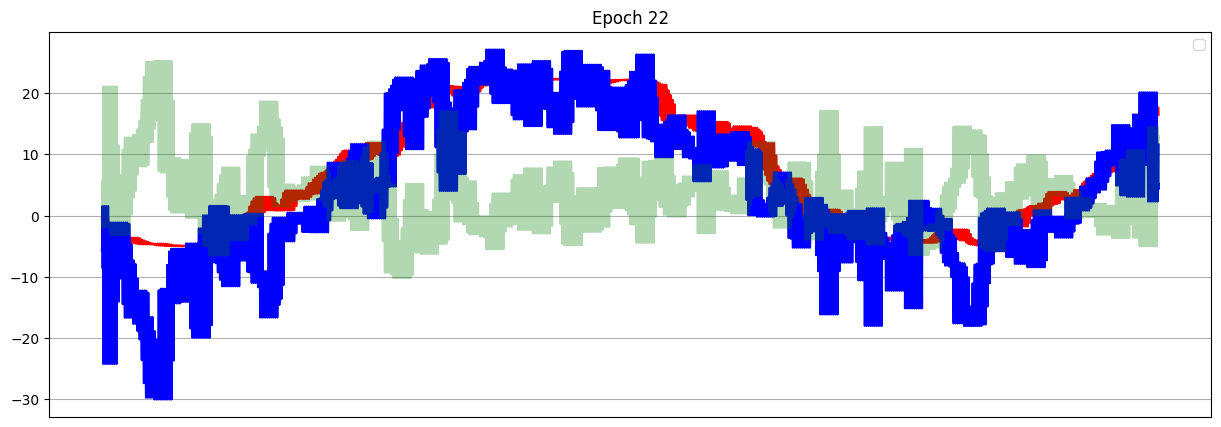

| epoch  23 |    53/  269 batches | lr 0.000321 | 210.32 ms | loss 0.02687 | ppl     1.03
| epoch  23 |   106/  269 batches | lr 0.000321 | 213.04 ms | loss 0.02709 | ppl     1.03
| epoch  23 |   159/  269 batches | lr 0.000321 | 217.59 ms | loss 0.02253 | ppl     1.02
| epoch  23 |   212/  269 batches | lr 0.000321 | 218.40 ms | loss 0.04242 | ppl     1.04
| epoch  23 |   265/  269 batches | lr 0.000321 | 221.06 ms | loss 0.02606 | ppl     1.03
-----------------------------------------------------------------------------------------
| Epoch  23 | Time: 136.38s | Val Loss: 0.03064 | Val PPL:     1.03
-----------------------------------------------------------------------------------------
| epoch  24 |    53/  269 batches | lr 0.000314 | 227.66 ms | loss 0.02616 | ppl     1.03
| epoch  24 |   106/  269 batches | lr 0.000314 | 217.50 ms | loss 0.02681 | ppl     1.03
| epoch  24 |   159/  269 batches | lr 0.000314 | 214.19 ms | loss 0.02036 | ppl     1.02
| epoch  24 |   212/  269 batche

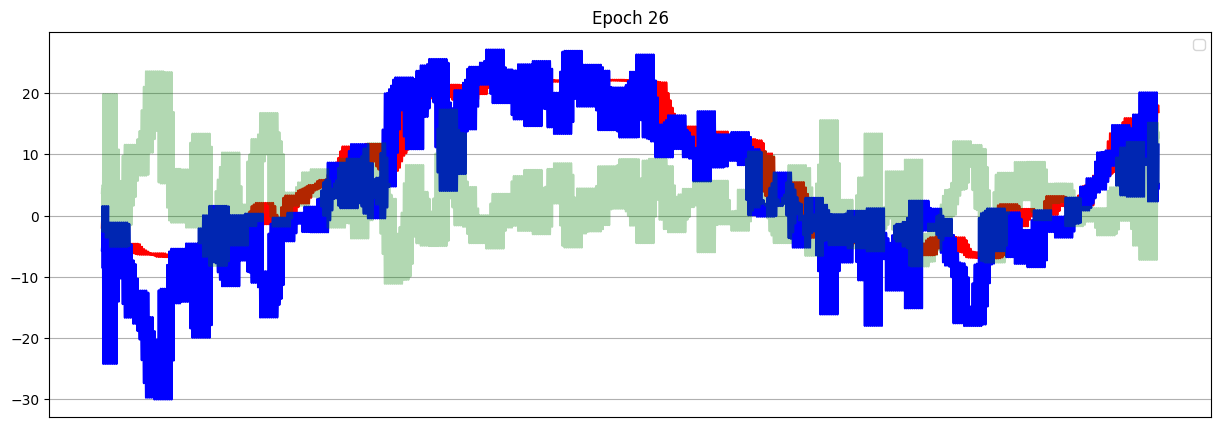

| epoch  27 |    53/  269 batches | lr 0.000296 | 229.67 ms | loss 0.02456 | ppl     1.02
| epoch  27 |   106/  269 batches | lr 0.000296 | 220.69 ms | loss 0.02317 | ppl     1.02
| epoch  27 |   159/  269 batches | lr 0.000296 | 222.39 ms | loss 0.01950 | ppl     1.02
| epoch  27 |   212/  269 batches | lr 0.000296 | 221.13 ms | loss 0.02424 | ppl     1.02
| epoch  27 |   265/  269 batches | lr 0.000296 | 225.31 ms | loss 0.02754 | ppl     1.03
-----------------------------------------------------------------------------------------
| Epoch  27 | Time: 138.14s | Val Loss: 0.02183 | Val PPL:     1.02
-----------------------------------------------------------------------------------------
Forecast - red | Fact - blue | Error - green


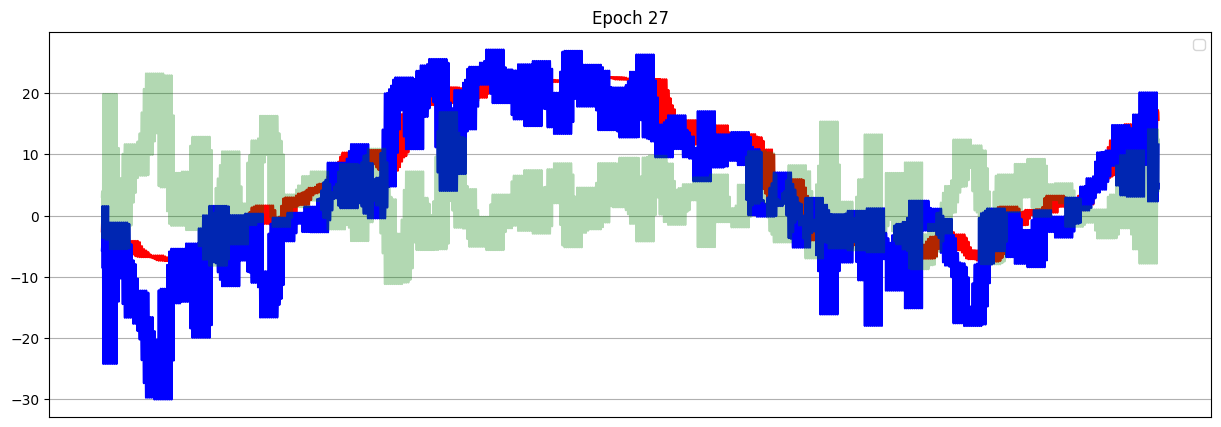

| epoch  28 |    53/  269 batches | lr 0.000290 | 231.22 ms | loss 0.02455 | ppl     1.02
| epoch  28 |   106/  269 batches | lr 0.000290 | 222.65 ms | loss 0.02378 | ppl     1.02
| epoch  28 |   159/  269 batches | lr 0.000290 | 230.04 ms | loss 0.01879 | ppl     1.02
| epoch  28 |   212/  269 batches | lr 0.000290 | 219.48 ms | loss 0.02414 | ppl     1.02
| epoch  28 |   265/  269 batches | lr 0.000290 | 226.18 ms | loss 0.02849 | ppl     1.03
-----------------------------------------------------------------------------------------
| Epoch  28 | Time: 141.06s | Val Loss: 0.02194 | Val PPL:     1.02
-----------------------------------------------------------------------------------------
| epoch  29 |    53/  269 batches | lr 0.000284 | 232.15 ms | loss 0.02425 | ppl     1.02
| epoch  29 |   106/  269 batches | lr 0.000284 | 229.33 ms | loss 0.02247 | ppl     1.02
| epoch  29 |   159/  269 batches | lr 0.000284 | 230.43 ms | loss 0.01811 | ppl     1.02
| epoch  29 |   212/  269 batche

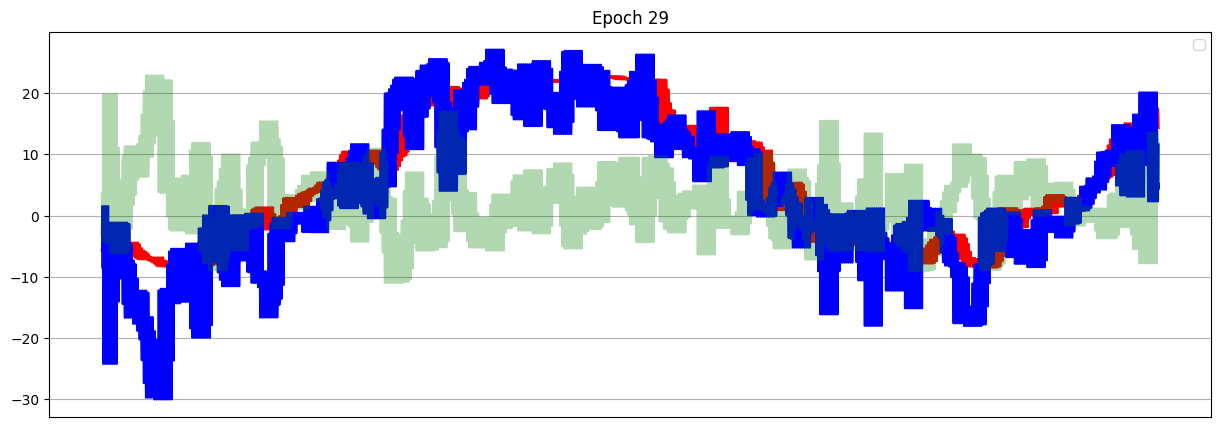

| epoch  30 |    53/  269 batches | lr 0.000278 | 233.43 ms | loss 0.02356 | ppl     1.02
| epoch  30 |   106/  269 batches | lr 0.000278 | 225.00 ms | loss 0.02222 | ppl     1.02
| epoch  30 |   159/  269 batches | lr 0.000278 | 226.66 ms | loss 0.01813 | ppl     1.02
| epoch  30 |   212/  269 batches | lr 0.000278 | 220.17 ms | loss 0.02302 | ppl     1.02
| epoch  30 |   265/  269 batches | lr 0.000278 | 227.09 ms | loss 0.02681 | ppl     1.03
-----------------------------------------------------------------------------------------
| Epoch  30 | Time: 143.18s | Val Loss: 0.02239 | Val PPL:     1.02
-----------------------------------------------------------------------------------------
| epoch  31 |    53/  269 batches | lr 0.000273 | 233.95 ms | loss 0.02391 | ppl     1.02
| epoch  31 |   106/  269 batches | lr 0.000273 | 232.08 ms | loss 0.02241 | ppl     1.02
| epoch  31 |   159/  269 batches | lr 0.000273 | 231.75 ms | loss 0.01793 | ppl     1.02
| epoch  31 |   212/  269 batche

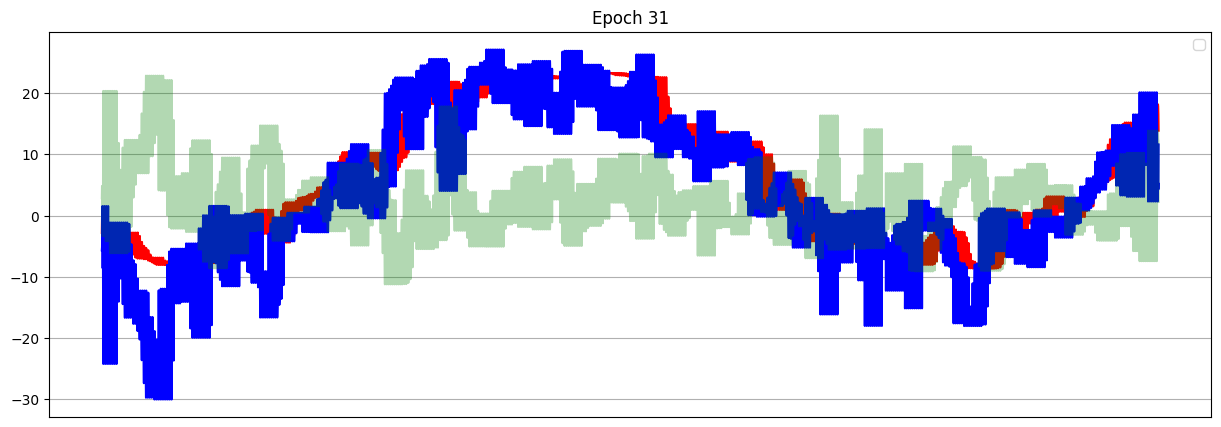

| epoch  32 |    53/  269 batches | lr 0.000267 | 247.98 ms | loss 0.02234 | ppl     1.02
| epoch  32 |   106/  269 batches | lr 0.000267 | 229.76 ms | loss 0.02089 | ppl     1.02
| epoch  32 |   159/  269 batches | lr 0.000267 | 231.63 ms | loss 0.01965 | ppl     1.02
| epoch  32 |   212/  269 batches | lr 0.000267 | 228.86 ms | loss 0.02011 | ppl     1.02
| epoch  32 |   265/  269 batches | lr 0.000267 | 231.42 ms | loss 0.02255 | ppl     1.02
-----------------------------------------------------------------------------------------
| Epoch  32 | Time: 142.97s | Val Loss: 0.02119 | Val PPL:     1.02
-----------------------------------------------------------------------------------------
Forecast - red | Fact - blue | Error - green


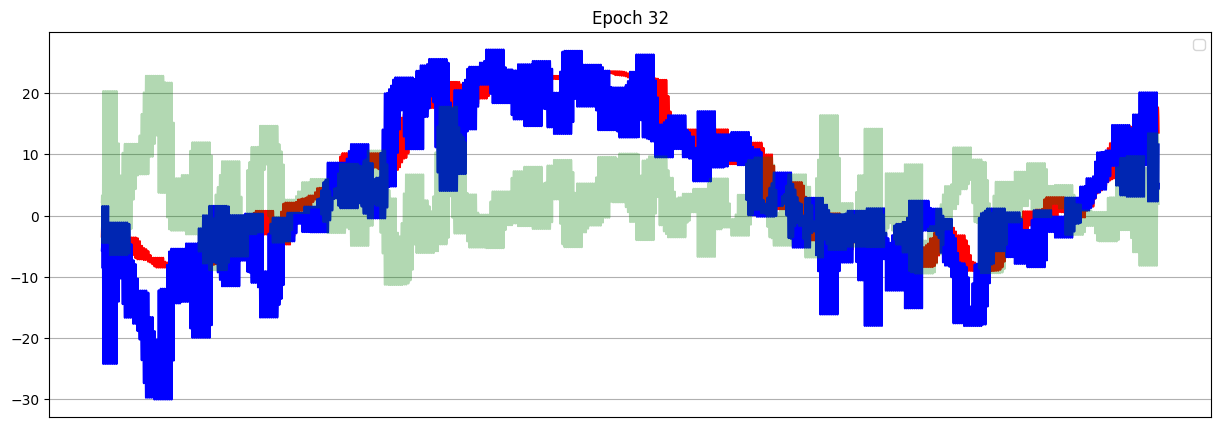

| epoch  33 |    53/  269 batches | lr 0.000262 | 226.75 ms | loss 0.02196 | ppl     1.02
| epoch  33 |   106/  269 batches | lr 0.000262 | 219.03 ms | loss 0.02124 | ppl     1.02
| epoch  33 |   159/  269 batches | lr 0.000262 | 218.70 ms | loss 0.01942 | ppl     1.02
| epoch  33 |   212/  269 batches | lr 0.000262 | 213.77 ms | loss 0.02036 | ppl     1.02
| epoch  33 |   265/  269 batches | lr 0.000262 | 224.41 ms | loss 0.02406 | ppl     1.02
-----------------------------------------------------------------------------------------
| Epoch  33 | Time: 138.22s | Val Loss: 0.02156 | Val PPL:     1.02
-----------------------------------------------------------------------------------------
| epoch  34 |    53/  269 batches | lr 0.000257 | 232.76 ms | loss 0.02219 | ppl     1.02
| epoch  34 |   106/  269 batches | lr 0.000257 | 222.28 ms | loss 0.02087 | ppl     1.02
| epoch  34 |   159/  269 batches | lr 0.000257 | 227.10 ms | loss 0.01861 | ppl     1.02
| epoch  34 |   212/  269 batche

In [ ]:
import torch
import torch.nn as nn
import math
import numpy as np
import pandas as pd
import time
from matplotlib import pyplot
from sklearn.preprocessing import MinMaxScaler
from torch.nn.init import uniform_

class Config:
    input_window = 100
    output_window = 5
    batch_size = 10
    feature_size = 250
    num_layers = 1
    dropout = 0.1
    lr = 0.0005
    epochs = 100
    calculate_loss_over_all_values = False

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
config = Config()

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super().__init__()
        position = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))
        pe = torch.zeros(max_len, 1, d_model)
        pe[:, 0, 0::2] = torch.sin(position * div_term)
        pe[:, 0, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe)

    def forward(self, x):
        return x + self.pe[:x.size(0)]

class TransAm(nn.Module):
    def __init__(self, feature_size=250, num_layers=1, dropout=0.1):
        super().__init__()
        self.model_type = 'Transformer'
        self.pos_encoder = PositionalEncoding(feature_size)
        self.encoder_layer = nn.TransformerEncoderLayer(
            d_model=feature_size, nhead=10, dropout=dropout, batch_first=False
        )
        self.transformer_encoder = nn.TransformerEncoder(
            self.encoder_layer, num_layers=num_layers
        )
        self.decoder = nn.Linear(feature_size, 1)
        self.init_weights()
        self.src_mask = None

    def init_weights(self):
        initrange = 0.1
        self.decoder.bias.data.zero_()
        uniform_(self.decoder.weight.data, -initrange, initrange)

    def forward(self, src):
        if self.src_mask is None or self.src_mask.size(0) != len(src):
            self.src_mask = self._generate_square_subsequent_mask(len(src)).to(src.device)

        src = self.pos_encoder(src)
        output = self.transformer_encoder(src, self.src_mask)
        return self.decoder(output)

    def _generate_square_subsequent_mask(self, sz):
        return torch.triu(torch.full((sz, sz), float('-inf')), diagonal=1)

def create_inout_sequences(input_data, window_size):
    L = len(input_data)
    sequences = []
    for i in range(L - window_size):
        seq = np.append(
            input_data[i:i+window_size][:-config.output_window],
            config.output_window * [0]
        )
        label = input_data[i:i+window_size]
        sequences.append((seq, label))
    return torch.FloatTensor(sequences)

def load_and_preprocess_data():
    df = pd.read_csv('./data/tes_osnova.csv')
    df.rename(columns={'dt': 'Date', 'temp': 'Temp'}, inplace=True)
    df['Date'] = pd.to_datetime(df['Date']).dt.date

    df = df.groupby('Date')['Temp'].max().reset_index()
    df = df.set_index('Date')

    scaler = MinMaxScaler(feature_range=(-1, 1))
    amplitude = scaler.fit_transform(df['Temp'].values.reshape(-1, 1)).flatten()

    train_data = amplitude[:2800]
    test_data = amplitude[2800:]

    train_sequence = create_inout_sequences(train_data, config.input_window)
    train_sequence = train_sequence[:-config.output_window]

    test_data = create_inout_sequences(test_data, config.input_window)
    test_data = test_data[:-config.output_window]

    return train_sequence.to(device), test_data.to(device), scaler


def get_batch(source, i):
    seq_len = min(config.batch_size, len(source) - 1 - i)
    data = source[i:i+seq_len]
    inputs = torch.stack([item[0] for item in data]).unsqueeze(-1)
    targets = torch.stack([item[1] for item in data]).unsqueeze(-1)
    return inputs.transpose(0, 1), targets.transpose(0, 1)

def train_epoch(model, train_data, optimizer, criterion, scheduler):
    model.train()
    total_loss = 0.
    log_interval = max(1, len(train_data) // config.batch_size // 5)
    start_time = time.time()

    for batch, i in enumerate(range(0, len(train_data) - 1, config.batch_size)):
        data, targets = get_batch(train_data, i)
        optimizer.zero_grad()

        output = model(data)
        loss = criterion(
            output[-config.output_window:],
            targets[-config.output_window:]
        ) if not config.calculate_loss_over_all_values else criterion(output, targets)

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 0.5)
        optimizer.step()

        total_loss += loss.item()

        if batch % log_interval == 0 and batch > 0:
            avg_loss = total_loss / log_interval
            elapsed = time.time() - start_time
            print(f'| epoch {epoch:3d} | {batch:5d}/{len(train_data)//config.batch_size:5d} batches | '
                  f'lr {scheduler.get_last_lr()[0]:02.6f} | {elapsed*1000/log_interval:5.2f} ms | '
                  f'loss {avg_loss:5.5f} | ppl {math.exp(avg_loss):8.2f}')
            total_loss = 0
            start_time = time.time()

def evaluate_model(model, data_source, criterion):
    model.eval()
    total_loss = 0.
    eval_batch_size = config.batch_size
    with torch.no_grad():
        for i in range(0, len(data_source) - 1, eval_batch_size):
            data, targets = get_batch(data_source, i)
            output = model(data)
            if config.calculate_loss_over_all_values:
                total_loss += len(data[0])* criterion(config.output, targets).cpu().item()
            else:
                total_loss += len(data[0])* criterion(output[-config.output_window:], targets[-config.output_window:]).cpu().item()
    return total_loss / len(data_source)

def plot_results(model, data_source, epoch, scaler):
    model.eval()
    predictions = []
    actuals = []

    with torch.no_grad():
        for i in range(0, min(500, len(data_source) - 1)):
            data, target = get_batch(data_source, i)
            output = model(data)
            predictions.append(output[-1].squeeze().cpu().numpy())
            actuals.append(target[-1].squeeze().cpu().numpy())

    if scaler is not None:
      predictions = scaler.inverse_transform(np.array(predictions).reshape(-1, 1)).flatten()
      actuals = scaler.inverse_transform(np.array(actuals).reshape(-1, 1)).flatten()

    print('Forecast - red | Fact - blue | Error - green')
    plt.figure(figsize=(15, 5))
    plt.plot(predictions, color="red")
    plt.plot(actuals, color="blue")
    plt.plot(np.array(predictions) - np.array(actuals), color="green", alpha=0.3)
    plt.grid(True)
    plt.legend()
    plt.title(f'Epoch {epoch}')
    plt.xticks([])
    plt.show()

train_data, val_data, scaler = load_and_preprocess_data()

model = TransAm(
    feature_size=config.feature_size,
    num_layers=config.num_layers,
    dropout=config.dropout
).to(device)

criterion = nn.MSELoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=config.lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1.0, gamma=0.98)

best_val_loss = float('inf')
best_model = None

for epoch in range(1, config.epochs + 1):
    epoch_start_time = time.time()
    train_epoch(model, train_data, optimizer, criterion, scheduler)

    val_loss = evaluate_model(model, val_data, criterion)

    print('-' * 89)
    print(f'| Epoch {epoch:3d} | Time: {time.time()-epoch_start_time:5.2f}s | '
          f'Val Loss: {val_loss:5.5f} | Val PPL: {math.exp(val_loss):8.2f}')
    print('-' * 89)

    if val_loss < best_val_loss:
        plot_results(model, val_data, epoch, scaler)
        best_val_loss = val_loss
        best_model = model.state_dict()
        torch.save({
            'epoch': epoch,
            'model_state_dict': best_model,
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': val_loss,
            'scaler_state': {
              'scale_': scaler.scale_,
              'min_': scaler.min_,
              'data_min_': scaler.data_min_,
              'data_max_': scaler.data_max_,
              'data_range_': scaler.data_range_}
        }, './model/best_model_max.pth')

    scheduler.step()

In [ ]:
# def load_model_and_scaler(path):
#     checkpoint = torch.load(path)
#     model = TransAm(
#         feature_size=config.feature_size,
#         num_layers=config.num_layers,
#         dropout=config.dropout
#     ).to(device)
#     model.load_state_dict(checkpoint['model_state_dict'])

#     scaler = MinMaxScaler(feature_range=(-1, 1))
#     scaler.scale_ = checkpoint['scaler_state']['scale_']
#     scaler.min_ = checkpoint['scaler_state']['min_']
#     scaler.data_min_ = checkpoint['scaler_state']['data_min_']
#     scaler.data_max_ = checkpoint['scaler_state']['data_max_']
#     scaler.data_range_ = checkpoint['scaler_state']['data_range_']

#     return model, scaler

In [ ]:
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # #

Temporal Fusion Transformer

Предполагалось на основе статьи https://habr.com/ru/companies/X5Tech/articles/869750/ но в итоге полностью обновленный

In [ ]:
!pip install darts

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.0/56.0 kB 5.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.3/46.3 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 60.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.6/200.6 kB 18.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.1/823.1 kB 52.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 354.4/354.4 kB 28.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.7/101.7 kB 12.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 115.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 92.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 57.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd

import time
from tqdm import tqdm

import math
import os

from matplotlib import pyplot
import matplotlib.pyplot as plt

from typing import List, Tuple
from tqdm import tqdm

import torchmetrics

from darts import TimeSeries
from darts.models import TFTModel
from darts.utils.likelihood_models import QuantileRegression
from darts.dataprocessing.transformers import Scaler, StaticCovariatesTransformer

from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from pytorch_lightning.callbacks.lr_monitor import LearningRateMonitor
from pytorch_lightning.loggers import TensorBoardLogger

from sklearn.preprocessing import MinMaxScaler, StandardScaler, OrdinalEncoder
from sklearn.feature_selection import SelectKBest, mutual_info_regression

os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"  # Борется с фрагментацией
torch.cuda.empty_cache()  # Очистка кеша CUDA

torch.manual_seed(0)
np.random.seed(0)

In [ ]:
osnova = pd.read_csv('./data/Custom_location (2).csv')
ss = pd.read_csv('./data/sunrise_sunset_2026_update.csv').iloc[:,1:]
ss['date'] = ss['date'] + ' 00:00:00'
ss['date'] = pd.to_datetime(ss['date'])
ss.rename(columns={'date':'dt'}, inplace=True)
ss = ss[['dt','diff_rise_set']]

In [ ]:
df = osnova.copy()
df = df.dropna(axis=1)
df = df.drop(['lat','lon','dt_iso','timezone','city_name','weather_id','weather_icon','weather_description'], axis=1)
df['dt'] = pd.to_datetime(df['dt'], unit='s')
df = df.merge(ss, on='dt' ,how='left')
df = df.interpolate(method='linear')
df.head(1)

<ipython-input-39-a2e93ad33b53>:6: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  df = df.interpolate(method='linear')


dt   temp  dew_point  feels_like  temp_min  temp_max  pressure  \
0 1979-01-01 -36.38     -39.09      -43.38    -36.62    -36.23      1022   

   humidity  wind_speed  wind_deg  clouds_all weather_main  diff_rise_set  
0        74        1.79       125         100       Clouds          427.0

In [ ]:
df['date'] = df['dt'].dt.date

# idx = df.groupby('date')['temp'].idxmax()
df = df[df['dt'].dt.hour == 13].reset_index(drop=True)

df = df.drop(columns=['dt']).rename(columns={'date':'dt'})
df.head(1)

temp  dew_point  feels_like  temp_min  temp_max  pressure  humidity  \
0 -26.71     -29.78      -33.71    -26.99    -26.44      1015        73   

   wind_speed  wind_deg  clouds_all weather_main  diff_rise_set          dt  
0        5.26        94         100       Clouds     427.541667  1979-01-01

Было в датафрейме признаков : 23
SelectKBest : Отобранные признаки 15:
	 dew_point
	 feels_like
	 temp_min
	 temp_max
	 humidity
	 weather_main
	 diff_rise_set
	 dayofyear_sin
	 dayofyear_cos
	 temp_3day_avg
	 temp_7day_avg
	 temp_14day_avg
	 temp_31day_avg
	 temp_min_7day
	 temp_max_7day


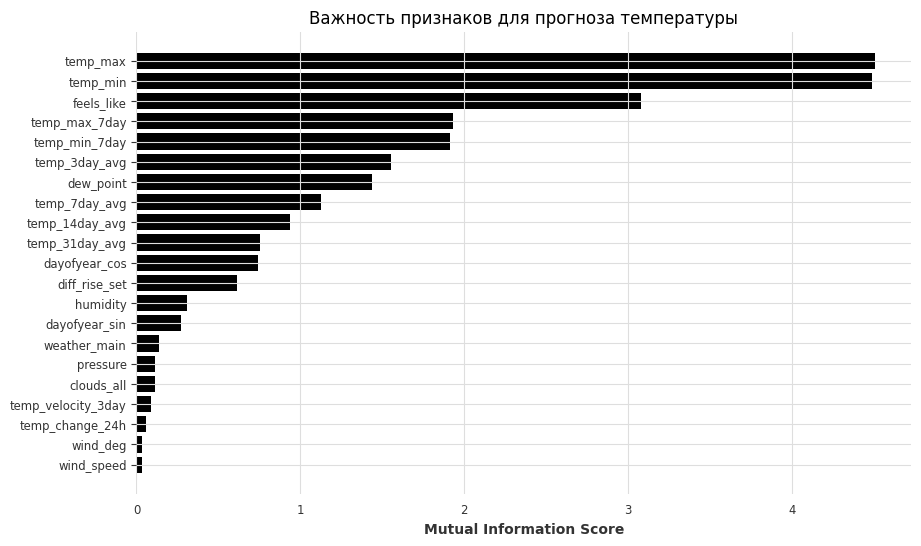

               Feature  MI_Score
3             temp_max  4.504072
2             temp_min  4.489848
1           feels_like  3.076659
20       temp_max_7day  1.933632
19       temp_min_7day  1.912967
13       temp_3day_avg  1.550277
0            dew_point  1.439066
14       temp_7day_avg  1.123717
15      temp_14day_avg  0.934324
16      temp_31day_avg  0.751642
12       dayofyear_cos  0.741184
10       diff_rise_set  0.611123
5             humidity  0.306317
11       dayofyear_sin  0.269648
9         weather_main  0.137057
4             pressure  0.114480
8           clouds_all  0.113115
18  temp_velocity_3day  0.086318
17     temp_change_24h  0.056814
7             wind_deg  0.036261
6           wind_speed  0.031992


dt   temp  feels_like  humidity  dew_point  temp_7day_avg  temp_max  \
0 1979-01-01 -26.71      -33.71        73     -29.78         -26.71    -26.44   

   temp_max_7day  temp_min  temp_14day_avg  diff_rise_set  temp_3day_avg  \
0         -26.71    -26.99          -26.71     427.541667         -26.71   

   temp_min_7day  dayofyear_cos  temp_31day_avg  
0         -26.71       0.999852          -26.71

In [ ]:
df['dt'] = pd.to_datetime(df['dt'])

# Создаем фичи
df["dayofyear_sin"] = np.sin(2 * np.pi * df["dt"].dt.dayofyear / 365)
df["dayofyear_cos"] = np.cos(2 * np.pi * df["dt"].dt.dayofyear / 365)
df["temp_3day_avg"] = df["temp"].rolling(3, min_periods=1).mean()
df["temp_7day_avg"] = df["temp"].rolling(7, min_periods=1).mean()
df["temp_14day_avg"] = df["temp"].rolling(14, min_periods=1).mean()
df["temp_31day_avg"] = df["temp"].rolling(31, min_periods=1).mean()
df['temp_change_24h'] = df['temp'].diff(1)
df['temp_velocity_3day'] = df['temp'].diff(3) / 3
df['temp_min_7day'] = df['temp'].rolling(7, min_periods=1).min()
df['temp_max_7day'] = df['temp'].rolling(7, min_periods=1).max()
df['weather_main'] = df['weather_main'].map({'Clouds':1, 'Snow':2, 'Clear':3, 'Rain':4}).fillna(0)
df = df.bfill()

print('Было в датафрейме признаков :', len(df.columns))

# Подготовка данных для SelectKBest
tmp = df.copy()
X = tmp.drop(columns=['temp', 'dt'])  # Удаляем целевую переменную и дату
y = tmp['temp']

# Отбор признаков метод SelectKBest
selector = SelectKBest(mutual_info_regression, k=15)
selected_features = selector.fit_transform(X, y)
selected_mask = selector.get_support()
selected_columns = list(X.columns[selected_mask])
print(f"SelectKBest : Отобранные признаки {len(selected_columns)}:")

for l in selected_columns:
  print('\t',l)
s1 = set(selected_columns)

# Отбор признаков метод mutual_info_regression
mi_scores = mutual_info_regression(X, y, random_state=42)
mi_df = pd.DataFrame({'Feature': X.columns,'MI_Score': mi_scores}).sort_values('MI_Score', ascending=False)

s2=set(mi_df.Feature.head(13))

plt.figure(figsize=(10, 6))
plt.barh(mi_df['Feature'], mi_df['MI_Score'])
plt.xlabel('Mutual Information Score')
plt.title('Важность признаков для прогноза температуры')
plt.gca().invert_yaxis()
plt.show()

print(mi_df)

df = df[['dt','temp']+list(s1.intersection(s2))]
df.head(1)

In [ ]:
df['dt'] = pd.to_datetime(df['dt'])

series_temp = TimeSeries.from_dataframe(
    df,
    time_col='dt',
    value_cols=['temp', 'temp_min', 'temp_max', 'feels_like'],
    freq='D'
)

covariates = TimeSeries.from_dataframe(
    df,
    time_col='dt',
    value_cols=[
        'dew_point','humidity','diff_rise_set',
        'dayofyear_cos','temp_3day_avg',
        'temp_7day_avg','temp_14day_avg','temp_31day_avg',
        'temp_min_7day','temp_max_7day'
    ],
    freq='D'
)

In [ ]:
# Масштабирование целевых переменных (совместное)
target_cols = ['temp', 'temp_min', 'temp_max', 'feels_like']
target_scaler = Scaler(scaler=StandardScaler(), global_fit=True)  # global_fit=True для сохранения соотношений
scaled_target = target_scaler.fit_transform(series_temp)

# Масштабирование ковариат (раздельное по группам)
covariate_cols = [
    'dew_point', 'humidity', 'diff_rise_set',
    'dayofyear_cos', 'temp_3day_avg', 'temp_7day_avg',
    'temp_14day_avg', 'temp_31day_avg', 'temp_min_7day',
    'temp_max_7day'
]

std_mask = np.array([True, True, False, False, True, True, True, True, True, True])  # Стандартизация
minmax_mask = np.array([False, False, True, True, False, False, False, False, False, False])  # MinMax

# Применяем StandardScaler к первой группе где все температурные значения имеют одинаковую физическую природу
covariates_std_scaler = Scaler(scaler=StandardScaler(), global_fit=False)
scaled_covariates = covariates_std_scaler.fit_transform(
    covariates,
    component_mask=std_mask
)

# Применяем MinMaxScaler ко второй группе (математические значения)
covariates_minmax_scaler = Scaler(scaler=MinMaxScaler(feature_range=(0, 1)), global_fit=False)
scaled_covariates = covariates_minmax_scaler.fit_transform(
    scaled_covariates,
    component_mask=minmax_mask
)

In [ ]:
window_len=7

def series_splitter(
    series_list: List[TimeSeries],
    train_min_dt: pd.Timestamp,
    train_max_dt: pd.Timestamp,
    val_min_dt: pd.Timestamp,
    val_max_dt: pd.Timestamp,
    test_min_dt: pd.Timestamp,
    test_max_dt: pd.Timestamp,
    window_len: int

) -> Tuple[List[TimeSeries], List[TimeSeries], List[TimeSeries]]:
    """
    Разбивает список временных рядов на train/val/test части

    Параметры:
        series_list: Список временных рядов для разбиения
        *_min_dt/*_max_dt: Границы временных интервалов
        window_len: Минимальная требуемая длина ряда

    Возвращает:
        Кортеж (train, val, test) списков TimeSeries
    """
    train, val, test = [], [], []

    for series in tqdm(series_list, desc="Splitting series"):

        test_series = series.slice(test_min_dt, test_max_dt)
        if test_series is not None:
            test.append(test_series)

        val_series = series.slice(val_min_dt, val_max_dt)
        if val_series is not None and len(val_series) >= window_len:
            val.append(val_series)

        train_series = series.slice(train_min_dt, train_max_dt)
        if train_series is not None and len(train_series) >= window_len:
            train.append(train_series)

    return train, val, test

In [ ]:
df.tail(1)

dt  temp  feels_like  humidity  dew_point  temp_7day_avg  \
16727 2024-10-18  7.84        6.19        60       0.57       7.451429   

       temp_max  temp_max_7day  temp_min  temp_14day_avg  diff_rise_set  \
16727      8.18          13.69      7.63       10.068571          614.0   

       temp_3day_avg  temp_min_7day  dayofyear_cos  temp_31day_avg  
16727       7.266667           0.46       0.309017       14.992903

In [ ]:
min_year='1979'
max_year='2023'

train_min_dt = pd.Timestamp(f'{min_year}-01-01')
train_max_dt = pd.Timestamp('2015-12-31')

val_min_dt = pd.Timestamp('2016-01-01')
val_max_dt = pd.Timestamp('2019-12-31')

test_min_dt = pd.Timestamp('2020-01-01')
test_max_dt = pd.Timestamp(f'{max_year}-12-31')

ts_target_train, ts_target_val, ts_target_test = series_splitter(
    [scaled_target],
    train_min_dt,
    train_max_dt,
    val_min_dt,
    val_max_dt,
    test_min_dt,
    test_max_dt,
    window_len
)

ts_covariates_train, ts_covariates_val, ts_covariates_test = series_splitter(
    [scaled_covariates],
    train_min_dt,
    train_max_dt,
    val_min_dt,
    val_max_dt,
    test_min_dt,
    test_max_dt,
    window_len
)

Splitting series: 100%|██████████| 1/1 [00:00<00:00, 214.08it/s]


In [ ]:
def encode_year_trend(index):
    # Нормализованный линейный тренд по годам
    return (index.year - index.year.min()) / 10

encoders = {
    "datetime_attribute": {
        "past": ['dayofweek', "month", "dayofyear"],  # Сезонность + годовой цикл
        "future": ["month", 'dayofweek']              # Для прогноза
    },
    "transformer": Scaler(),             # Масштабирование признаков
    "custom": {
        "past": [encode_year_trend]      # Используем именованную функцию
    }
}

Рекомендации для Kaggle:
# Оптимальные настройки для GPU T4 x2:
pl_trainer_kwargs = {
    "accelerator": "gpu",
    "devices": 2,  # Используем обе карты
    "strategy": "ddp",  # DataParallel
    "precision": "16-mixed"  # Обязательно для T4
}

# Для GPU P100:
pl_trainer_kwargs = {
    "accelerator": "gpu",
    "devices": 1,
    "precision": "32-true"  # FP32 работает быстрее
}

In [ ]:
version = 0

In [ ]:
version += 1

# adam_kwargs = {"lr": 1e-4, "weight_decay": 1e-6}
adam_kwargs = {"lr": 1e-3, "weight_decay": 1e-5}

# lr_scheduler_kwargs = {"mode": "min", "patience": 3, "factor": 0.5}
lr_scheduler_kwargs = {
    "mode": "min",
    "patience": 5,
    "factor": 0.5
}

early_stopping_kwargs = {
    "monitor": "val_loss",
    "patience": 10,
    "min_delta": 0.0001,
    "mode": "min"
}

logger = TensorBoardLogger(save_dir="./lightning_logs", name="temperature_forecast")

def get_device_config():
    if 'COLAB_TPU_ADDR' in os.environ:
        return {"accelerator": "tpu", "strategy": "xla", "devices": "auto"}
    elif torch.cuda.is_available():
        return {"accelerator": "gpu", "devices": 1, "precision": "64-true"} #GPU P100
    else:
        return {"accelerator": "cpu"}

pl_trainer_kwargs = {
    **get_device_config(),  # Добавляем конфигурацию устройства
    "logger": logger,
    "callbacks": [
        EarlyStopping(**early_stopping_kwargs),
        LearningRateMonitor(logging_interval="epoch"),
    ],
    "log_every_n_steps": 20,
    "enable_progress_bar": True,
    "max_epochs": 50  # Явно указываем максимальное количество эпох
}

tft_model = TFTModel(
    model_name=f"temperature_forecaster_colab_ver_{str(version)}",
    input_chunk_length=14,  # 2 недели (168*2 часов)
    output_chunk_length=7,  # 1 неделя прогноза
    batch_size=32,  # cpu=64 & gpu=512
    n_epochs=50,
    dropout=0.2,
    use_static_covariates=True,
    add_encoders=encoders,

    # hidden_size – основной гиперпараметр модели, задающий размерность векторов скрытого состояния
    # lstm_layers  – количество LSTM слоев
    # num_attention_heads – количество голов внимания
    # full_attention – режим полного внимания, при котором декодер обращает внимание также и на будущие значения
    # hidden_continuous_size – размерность векторов, в которые преобразуются непрерывные признаки.

    # hidden_size=64,  # Уменьшите с 128 (Увеличено для сложных временных зависимостей)
    # lstm_layers=1,   # Вместо 2
    # num_attention_heads=2,  # Вместо 4
    # hidden_continuous_size=8,  # Вместо 32
    # full_attention=False,   # стоит попробовать с True

    hidden_size=64,              # Достаточно для дневных данных
    lstm_layers=2,               # 2 слоя LSTM для улавливания сезонности
    num_attention_heads=2,       # 2 головы внимания
    hidden_continuous_size=16,   # Размер для непрерывных признаков
    full_attention=True,         # Полное внимание (лучше для долгих зависимостей)
    add_relative_index=True,     # Добавляет позиционные эмбеддинги

    # Вероятностное прогнозирование
    # likelihood=QuantileRegression(quantiles=[0.01, 0.1, 0.2, 0.5, 0.8, 0.9, 0.99]),
    # likelihood=QuantileRegression(quantiles=[0.1, 0.5, 0.9]),
    likelihood=None,  # Отключаем, если прогнозируем все 4 признака

    # Метрики и оптимизация
    torch_metrics=torchmetrics.MeanAbsoluteError(),
    optimizer_cls=torch.optim.Adam,
    optimizer_kwargs=adam_kwargs,
    lr_scheduler_cls=torch.optim.lr_scheduler.ReduceLROnPlateau,
    lr_scheduler_kwargs=lr_scheduler_kwargs,

    # Логирование и ранняя остановка
    work_dir="./tft_logs",
    save_checkpoints=True,
    pl_trainer_kwargs=pl_trainer_kwargs,
    force_reset=True  # Важно: сбрасываем предыдущие состояния модели
)

In [ ]:
# Для обучения. Пс: CPU - эпоха была 28-42ч и GPU - 15-20мин/эпоха сокращено до минуты если брать только 1 точку

tft_model.fit(
    series=ts_target_train[0],
    past_covariates=ts_covariates_train[0],  # Соответствующие ковариаты
    future_covariates=None,
    val_series=ts_target_val[0],  # Валидационные данные
    val_past_covariates=ts_covariates_val[0],
    verbose=True # - вывод прогресса обучения
)


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
   | Name                              | Type                             | Params | Mode 
------------------------------------------------------------------------------------------------
0  | train_metrics                     | MetricCollection                 | 0      | train
1  | val_metrics                       | MetricCollection                 | 0      | train
2  | input_embeddings                  | _MultiEmbedding                  | 0      | train
3  | static_covariates_vsn             | _VariableSelectionNetwork        | 0      | train
4  | encoder_vsn                       | _VariableSelectionNetwork      

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

TFTModel(output_chunk_shift=0, hidden_size=32, lstm_layers=2, num_attention_heads=2, full_attention=True, feed_forward=GatedResidualNetwork, dropout=0.2, hidden_continuous_size=8, categorical_embedding_sizes=None, add_relative_index=True, loss_fn=None, likelihood=QuantileRegression(quantiles=[0.1, 0.5, 0.9], prior_strength=1.0), norm_type=LayerNorm, use_static_covariates=True, model_name=temperature_forecaster_colab_ver_1, input_chunk_length=14, output_chunk_length=7, batch_size=32, n_epochs=50, add_encoders={'datetime_attribute': {'past': ['dayofweek', 'month', 'dayofyear'], 'future': ['month', 'dayofweek']}, 'transformer': Scaler, 'custom': {'past': [<function encode_year_trend at 0x787d03a3ed40>]}}, torch_metrics=MeanAbsoluteError(), optimizer_cls=<class 'torch.optim.adam.Adam'>, optimizer_kwargs={'lr': 0.001, 'weight_decay': 1e-05}, lr_scheduler_cls=<class 'torch.optim.lr_scheduler.ReduceLROnPlateau'>, lr_scheduler_kwargs={'mode': 'min', 'patience': 5, 'factor': 0.5}, work_dir=./tf

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

TypeError: the resolved dtypes are not compatible with add.reduce. Resolved (dtype('<U10'), dtype('<U10'), dtype('<U20'))

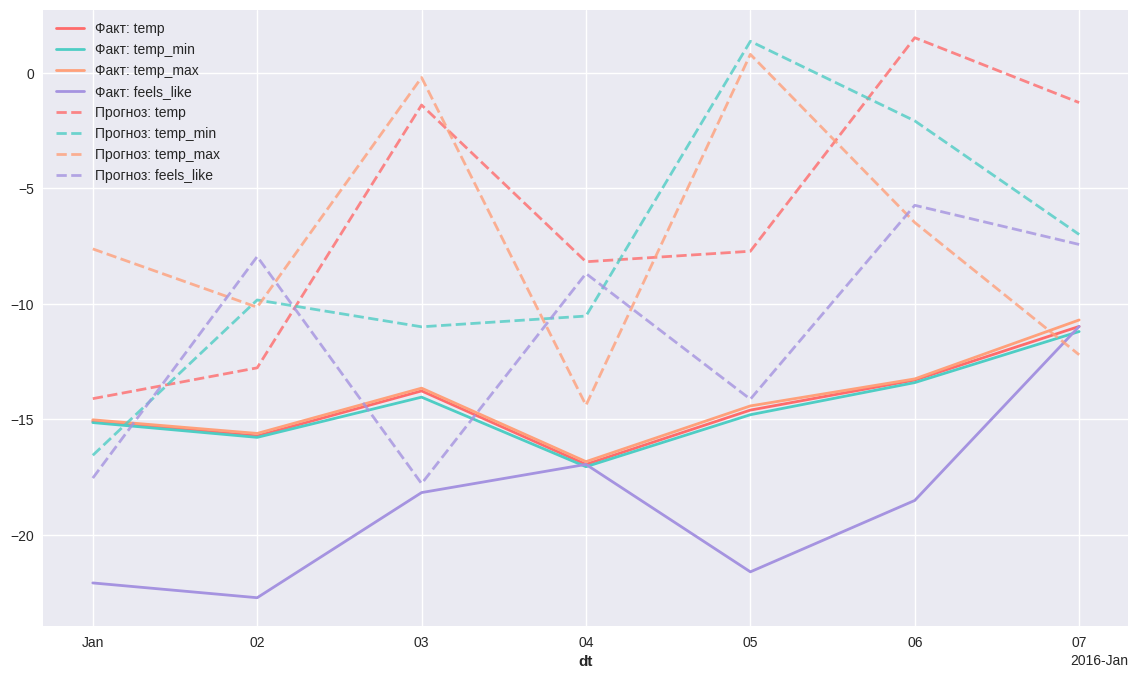

In [ ]:
import matplotlib.pyplot as plt
from darts.utils.statistics import plot_residuals_analysis
from darts import TimeSeries

forecast = tft_model.predict(n=7)

forecast_rescaled = target_scaler.inverse_transform(forecast)
actual_rescaled = target_scaler.inverse_transform(ts_target_val[0]).head(7)

plt.style.use('seaborn-v0_8')
plt.figure(figsize=(14, 8))


colors = {
    'temp': '#FF6B6B',
    'temp_min': '#4ECDC4',
    'temp_max': '#FFA07A',
    'feels_like': '#A593E0'
}

line_style_actual = '-'
line_style_forecast = '--'

for i, comp in enumerate(['temp', 'temp_min', 'temp_max', 'feels_like']):
    actual_rescaled.univariate_component(i).plot(
        label=f'Факт: {comp}',
        color=colors[comp],
        linestyle=line_style_actual,
        linewidth=2
    )

for i, comp in enumerate(['temp', 'temp_min', 'temp_max', 'feels_like']):
    forecast_rescaled.univariate_component(i).plot(
        label=f'Прогноз: {comp}',
        color=colors[comp],
        linestyle=line_style_forecast,
        linewidth=2,
        alpha=0.8
    )

if len(actual_rescaled) > len(forecast_rescaled):
    last_hist_point = actual_rescaled.time_index[-len(forecast_rescaled)-1]
    plt.axvline(x=last_hist_point, color='gray', linestyle=':', linewidth=1)

plt.title('Сравнение фактических и прогнозируемых температурных показателей', pad=20)
plt.xlabel('Дата')
plt.ylabel('Температура (°C)')
plt.grid(True, alpha=0.3)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.gcf().autofmt_xdate()
plt.tight_layout()
plt.show()

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

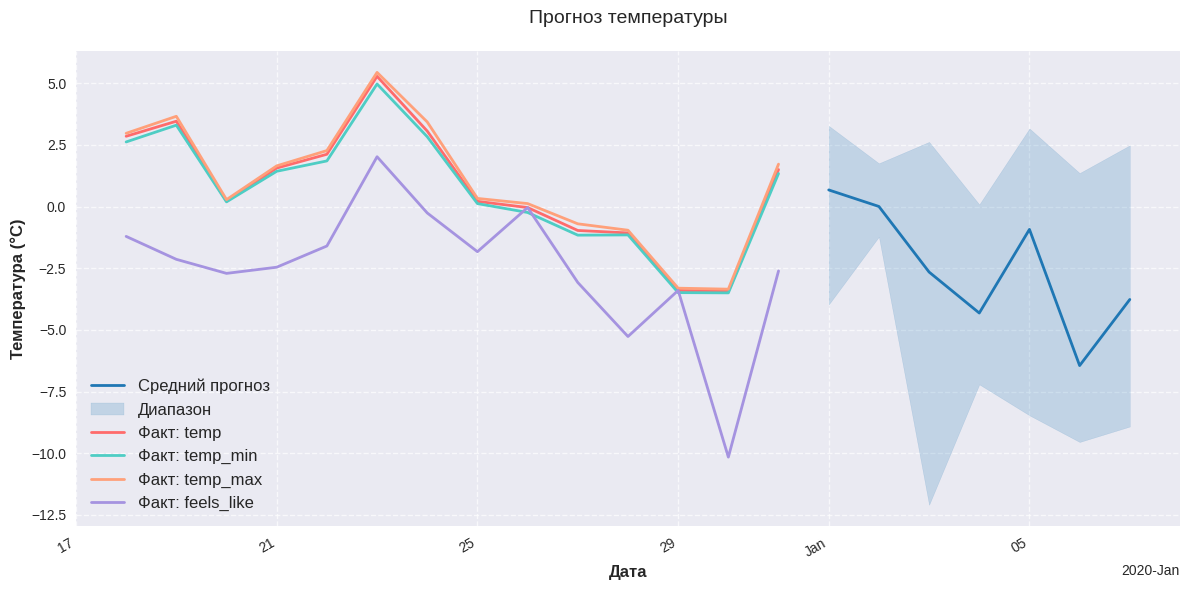

In [ ]:
def make_advanced_forecast(input_data, n_steps=7, past_covariates=None):
    if isinstance(input_data, pd.DataFrame):
        input_series = TimeSeries.from_dataframe(input_data)
    else:
        input_series = input_data

    forecast = tft_model.predict(
        n=n_steps,
        series=input_series,
        past_covariates=past_covariates
    )
    if hasattr(target_scaler, 'inverse_transform'):
        forecast = target_scaler.inverse_transform(forecast)

    return forecast

input_data = ts_target_val[0][-14:]
forecast = make_forecast(input_data)
forecast_df = ts_to_df(forecast)

plt.figure(figsize=(12, 6))

forecast_s = forecast_df.mean(axis=1)
plt.plot(forecast_s.index, forecast_s.values,
         color='#1f77b4', linewidth=2, label='Средний прогноз')

plt.fill_between(forecast_df.index,
                 forecast_df.min(axis=1),
                 forecast_df.max(axis=1),
                 color='#1f77b4', alpha=0.2, label='Диапазон')

fact = target_scaler.inverse_transform(input_data)
for i, comp in enumerate(['temp', 'temp_min', 'temp_max', 'feels_like']):
    fact.univariate_component(i).plot(
        label=f'Факт: {comp}',
        color=colors[comp],
        linestyle=line_style_actual,
        linewidth=2
    )
plt.title('Прогноз температуры', fontsize=14, pad=20)
plt.xlabel('Дата', fontsize=12)
plt.ylabel('Температура (°C)', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(fontsize=12)
plt.gcf().autofmt_xdate()
plt.tight_layout()
plt.show()

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

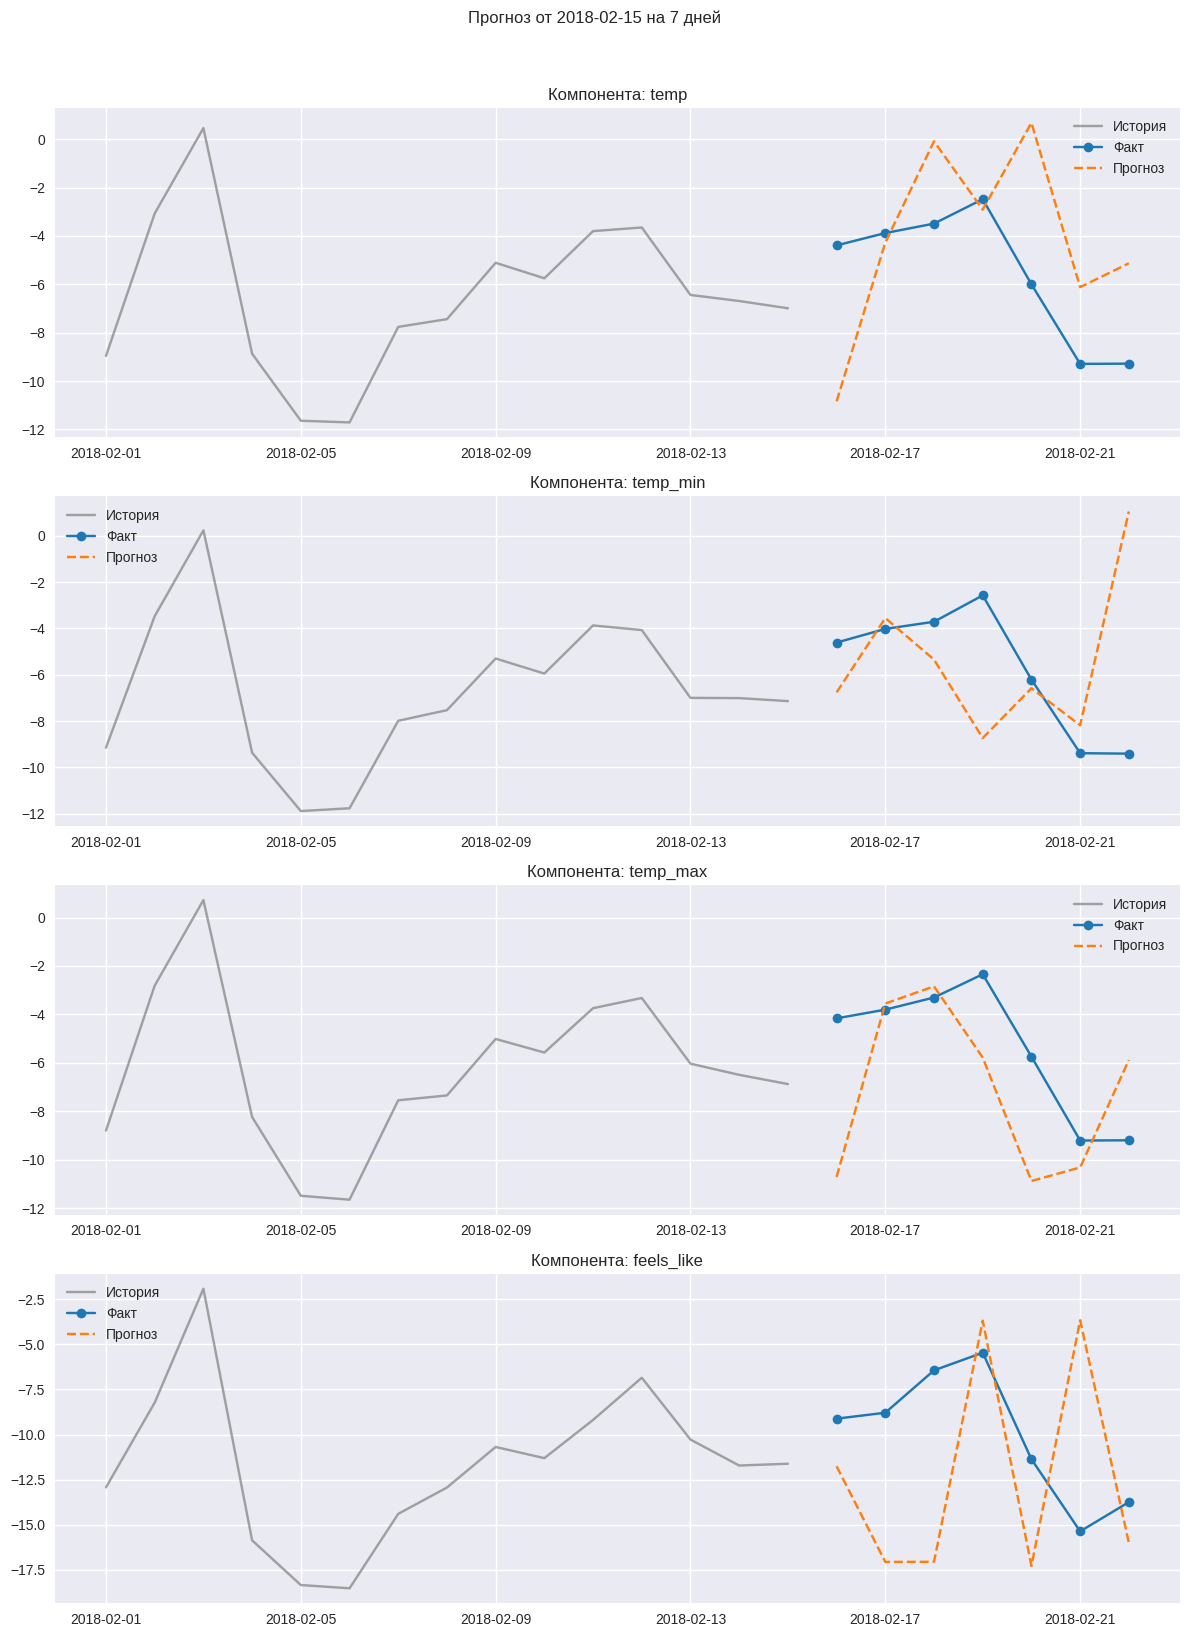

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

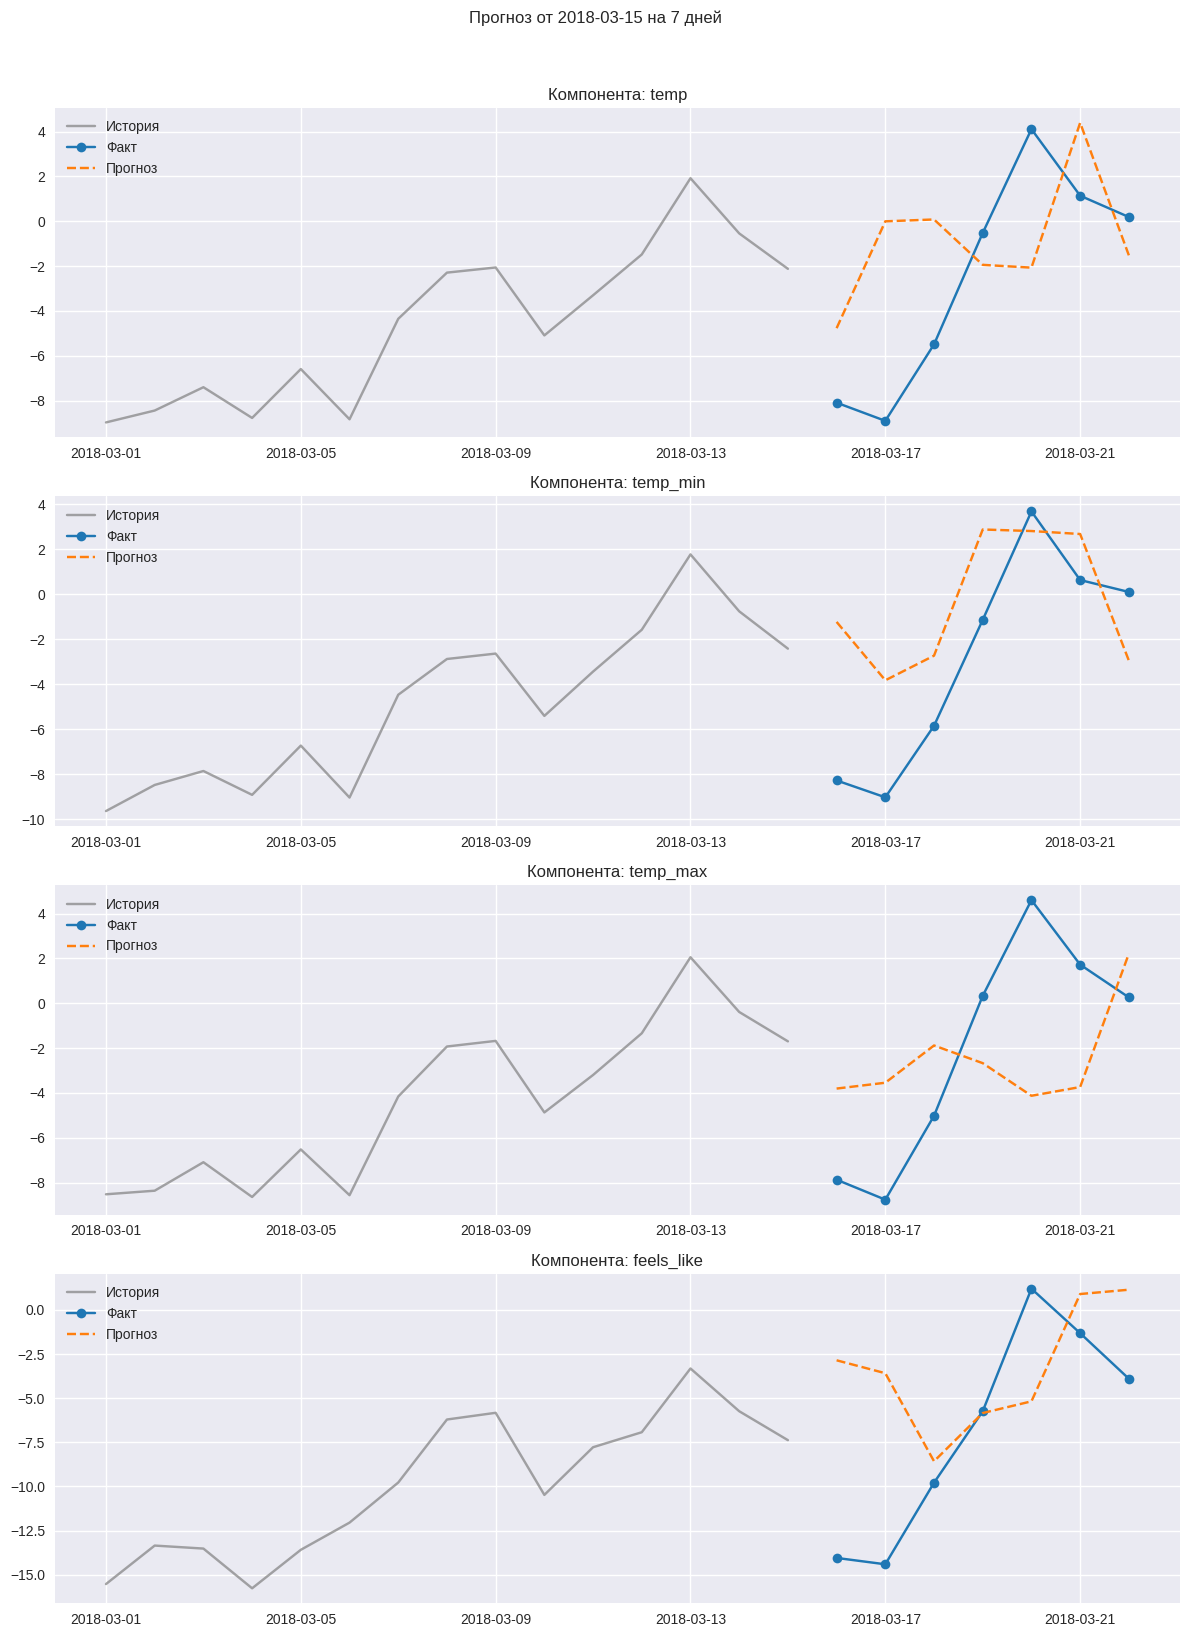

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

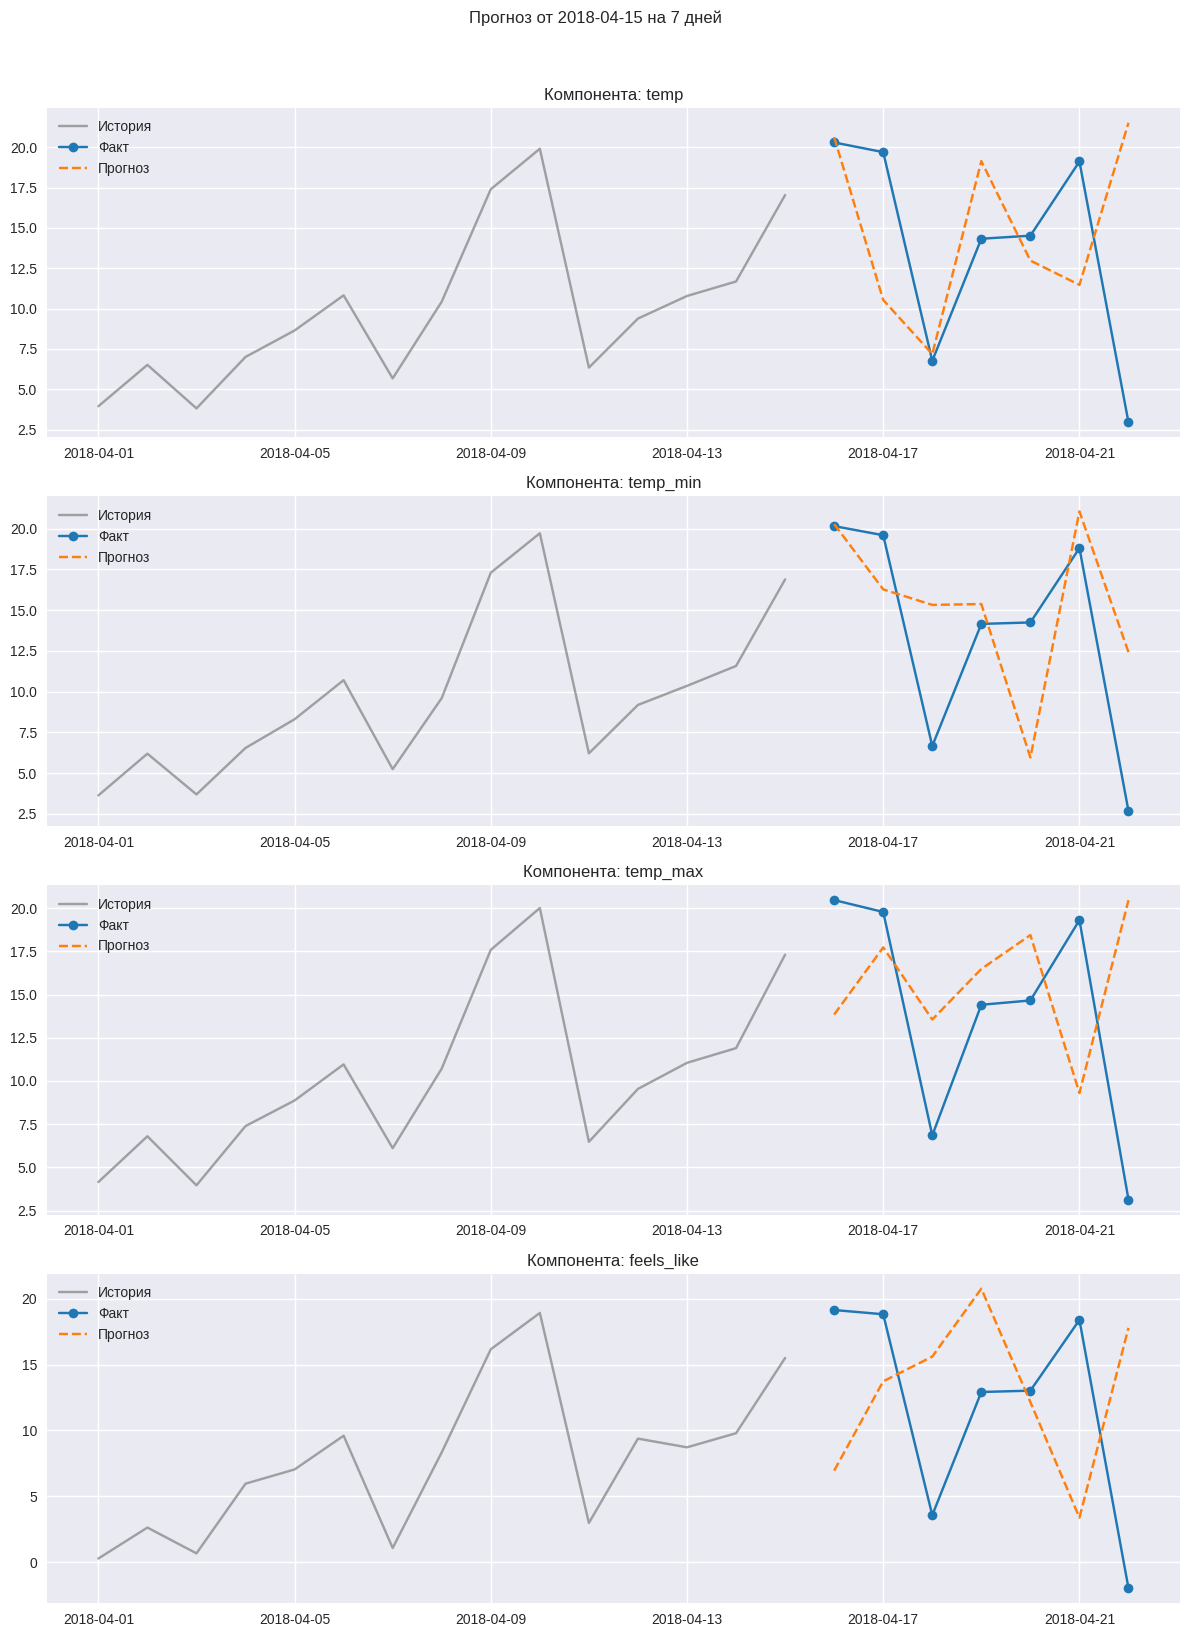

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

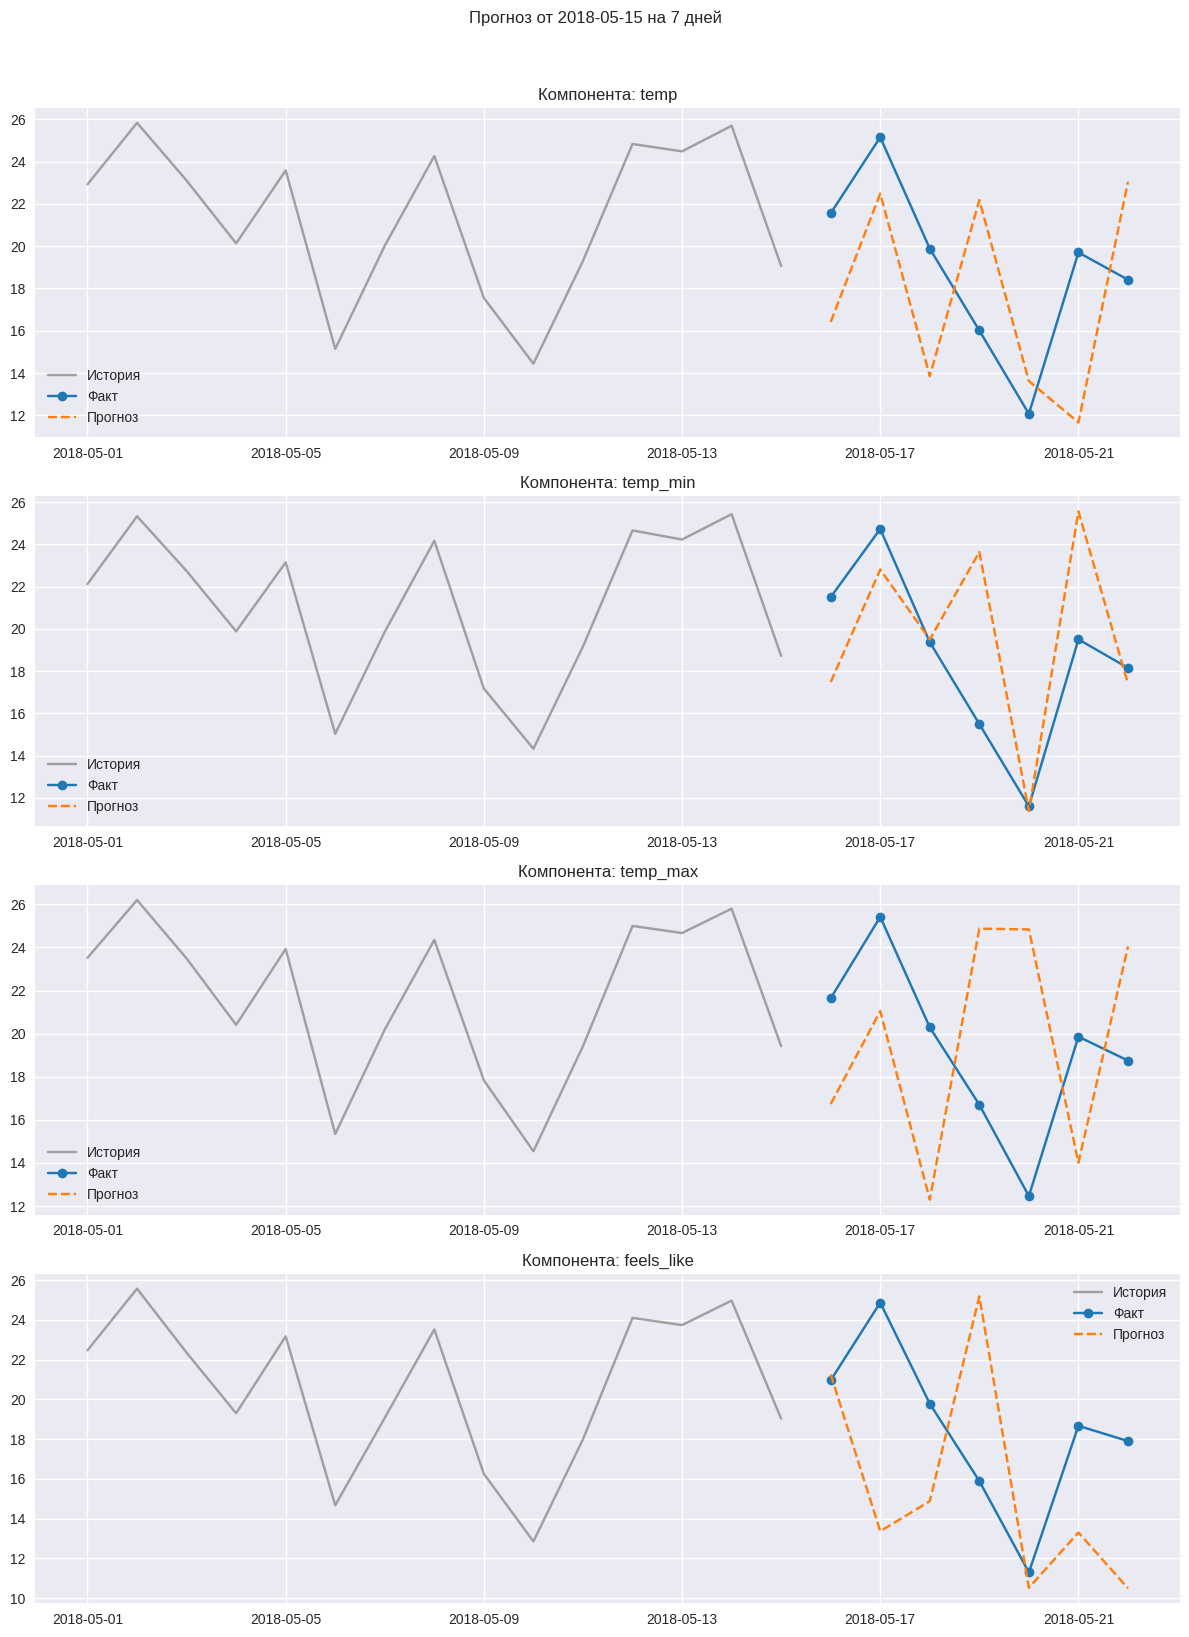

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

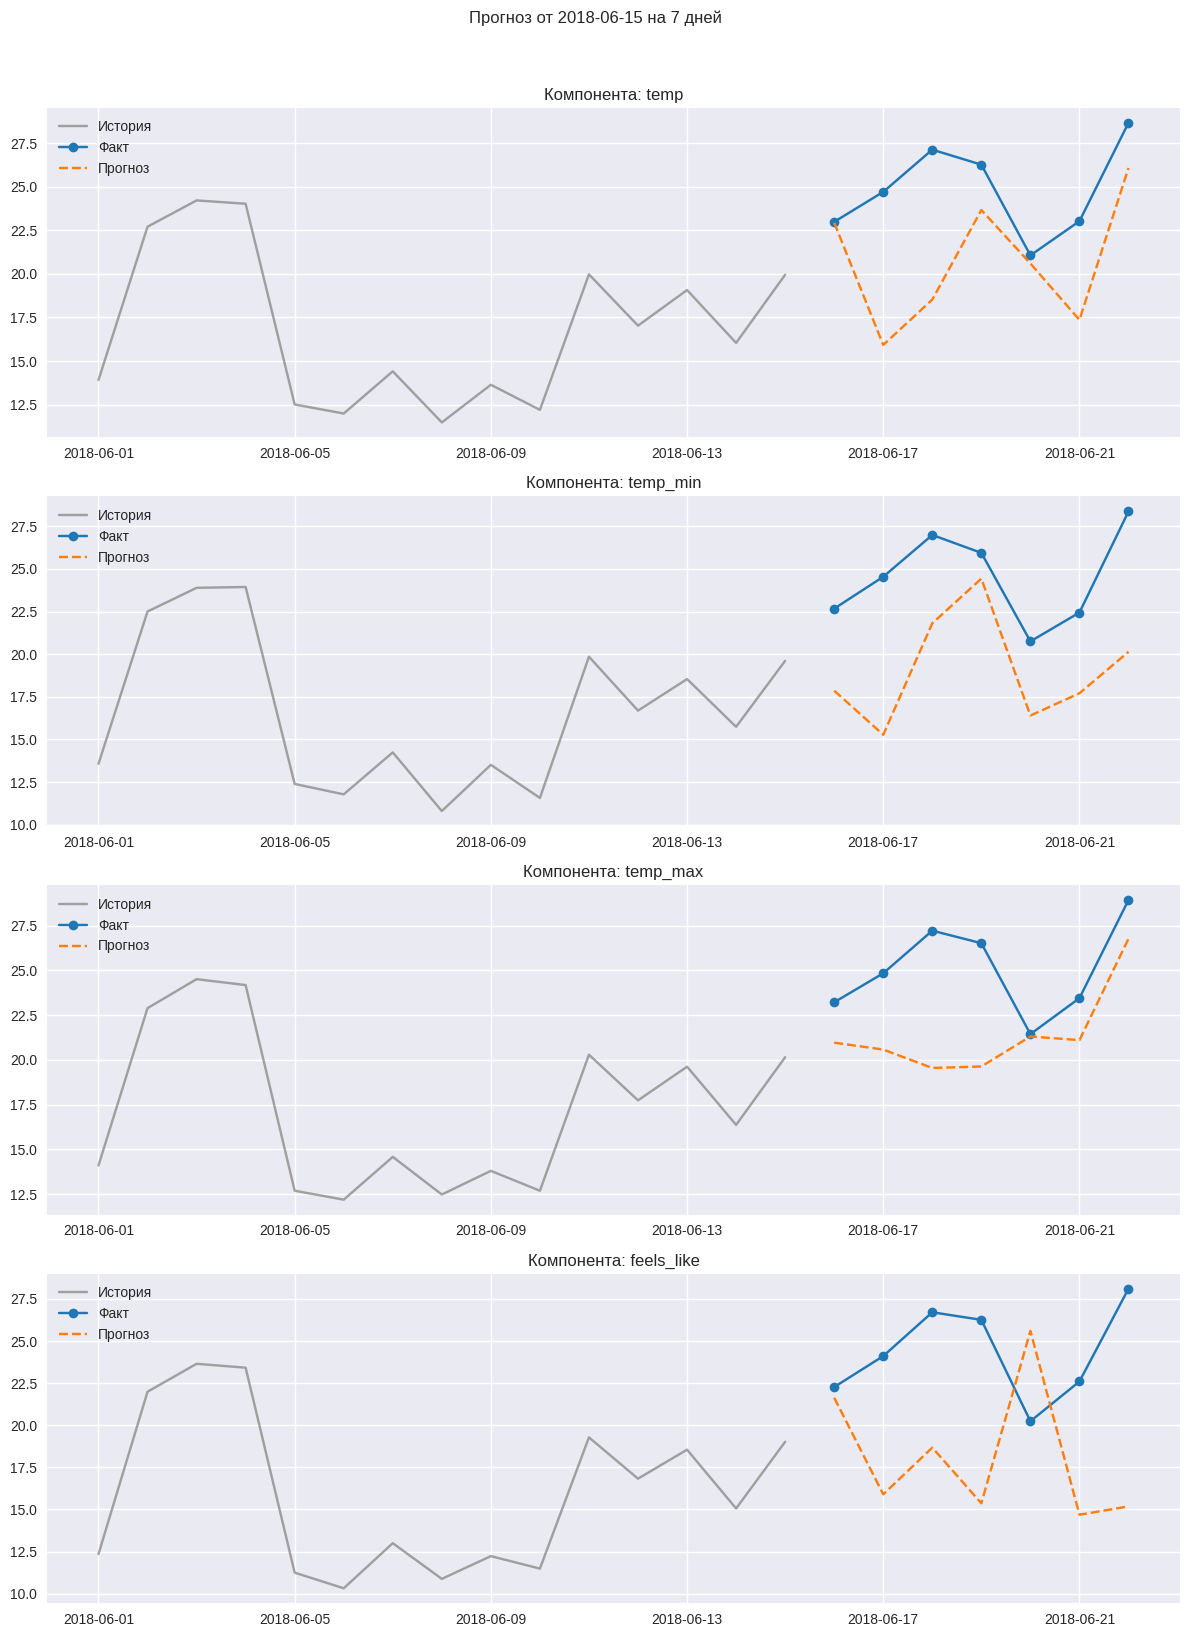

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

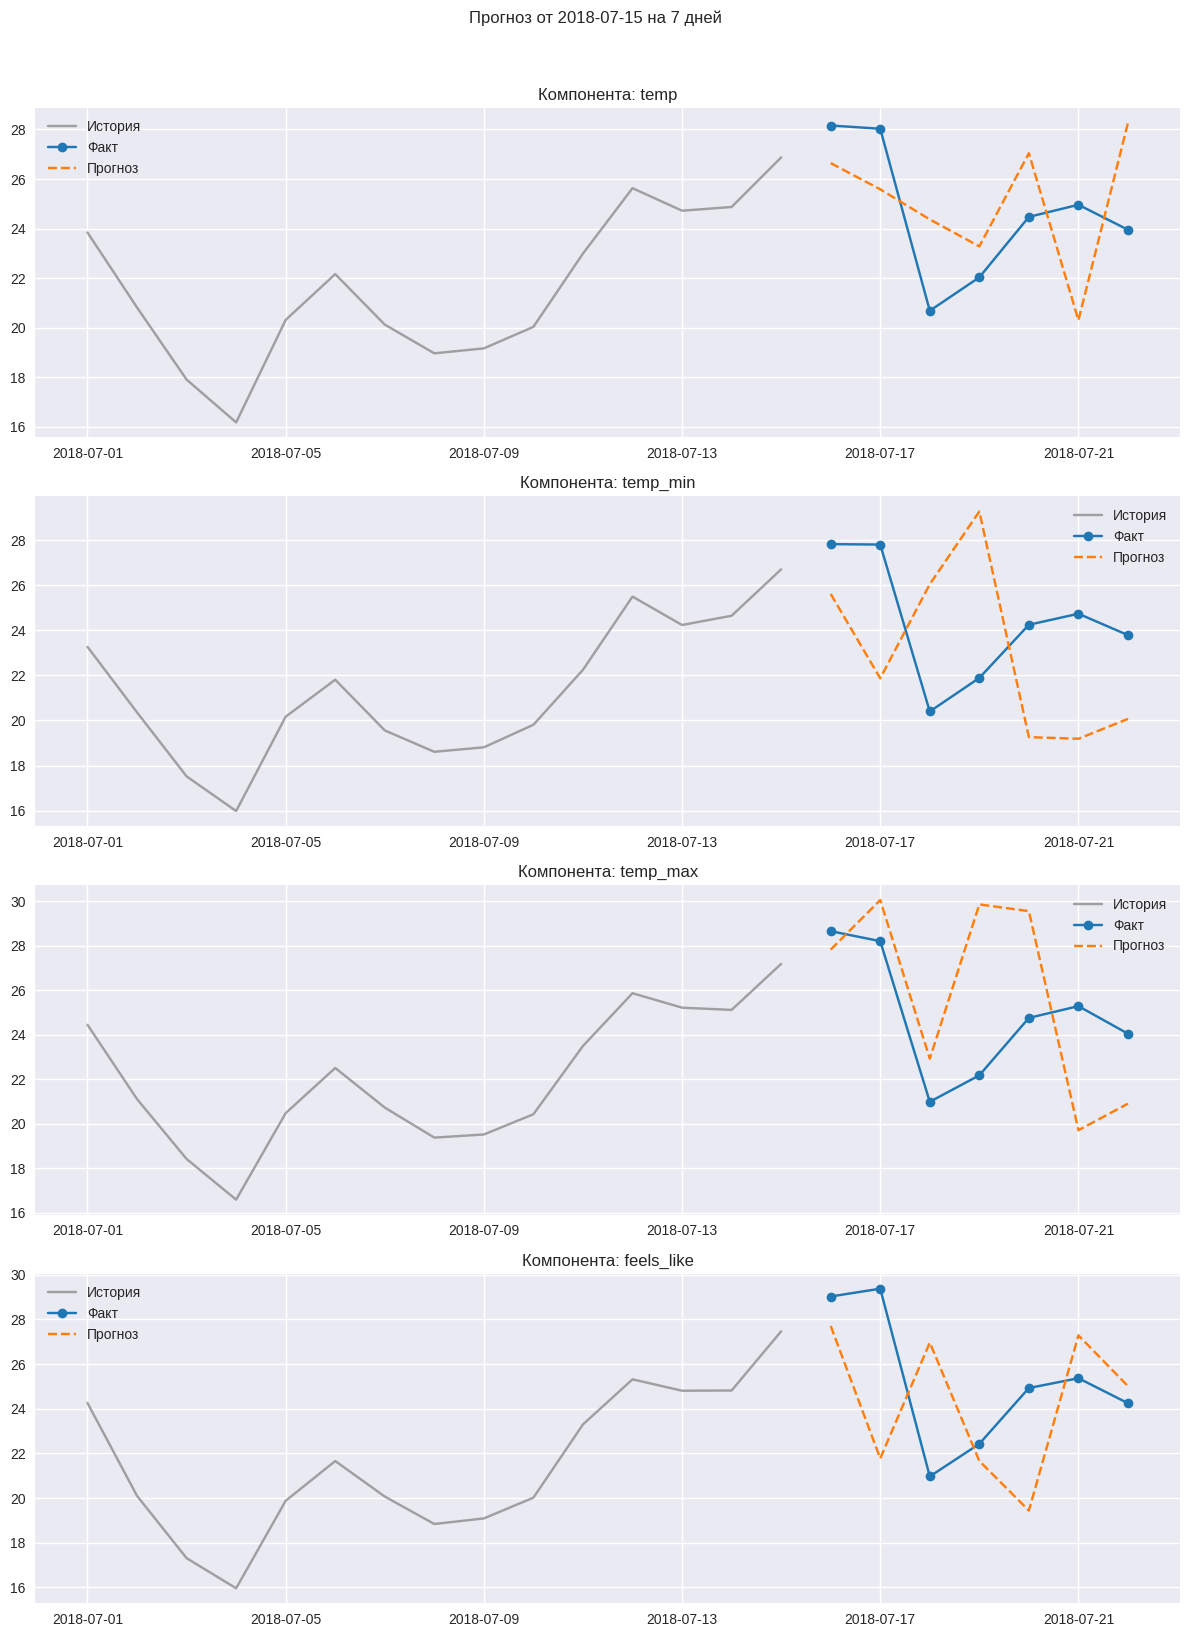

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

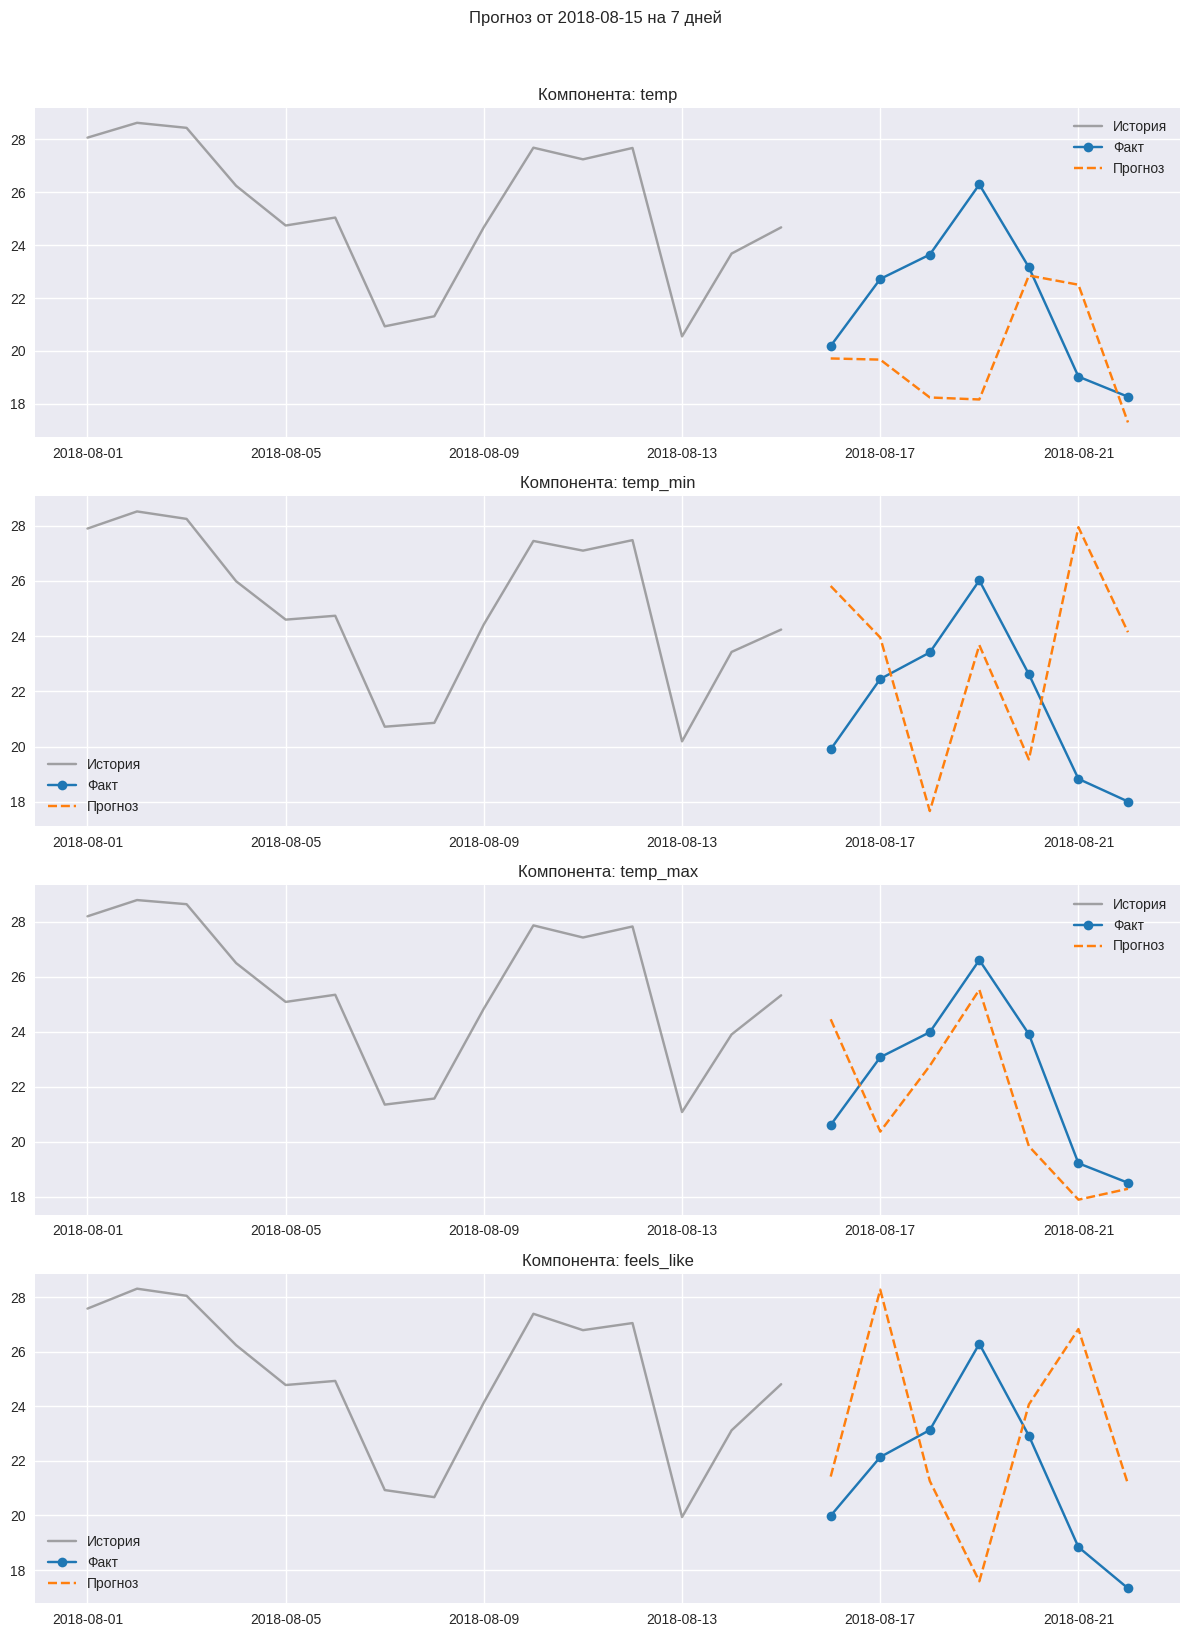

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

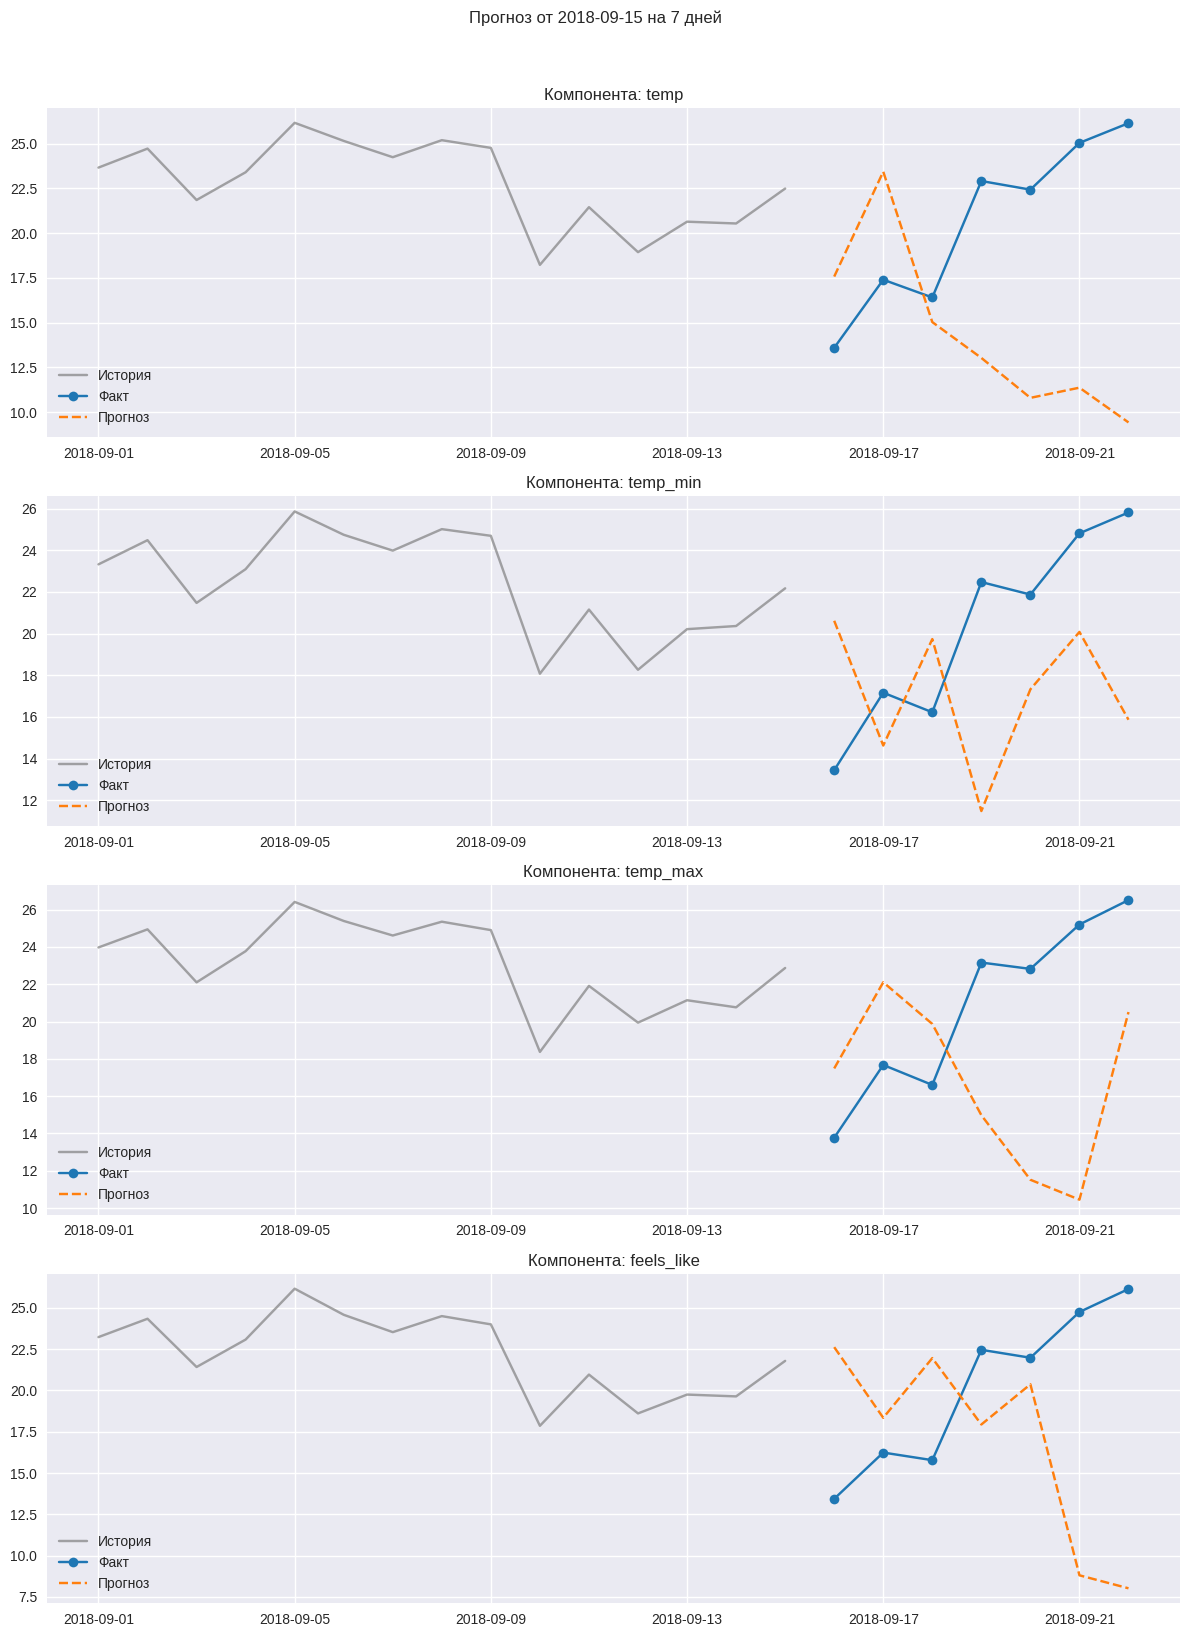

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

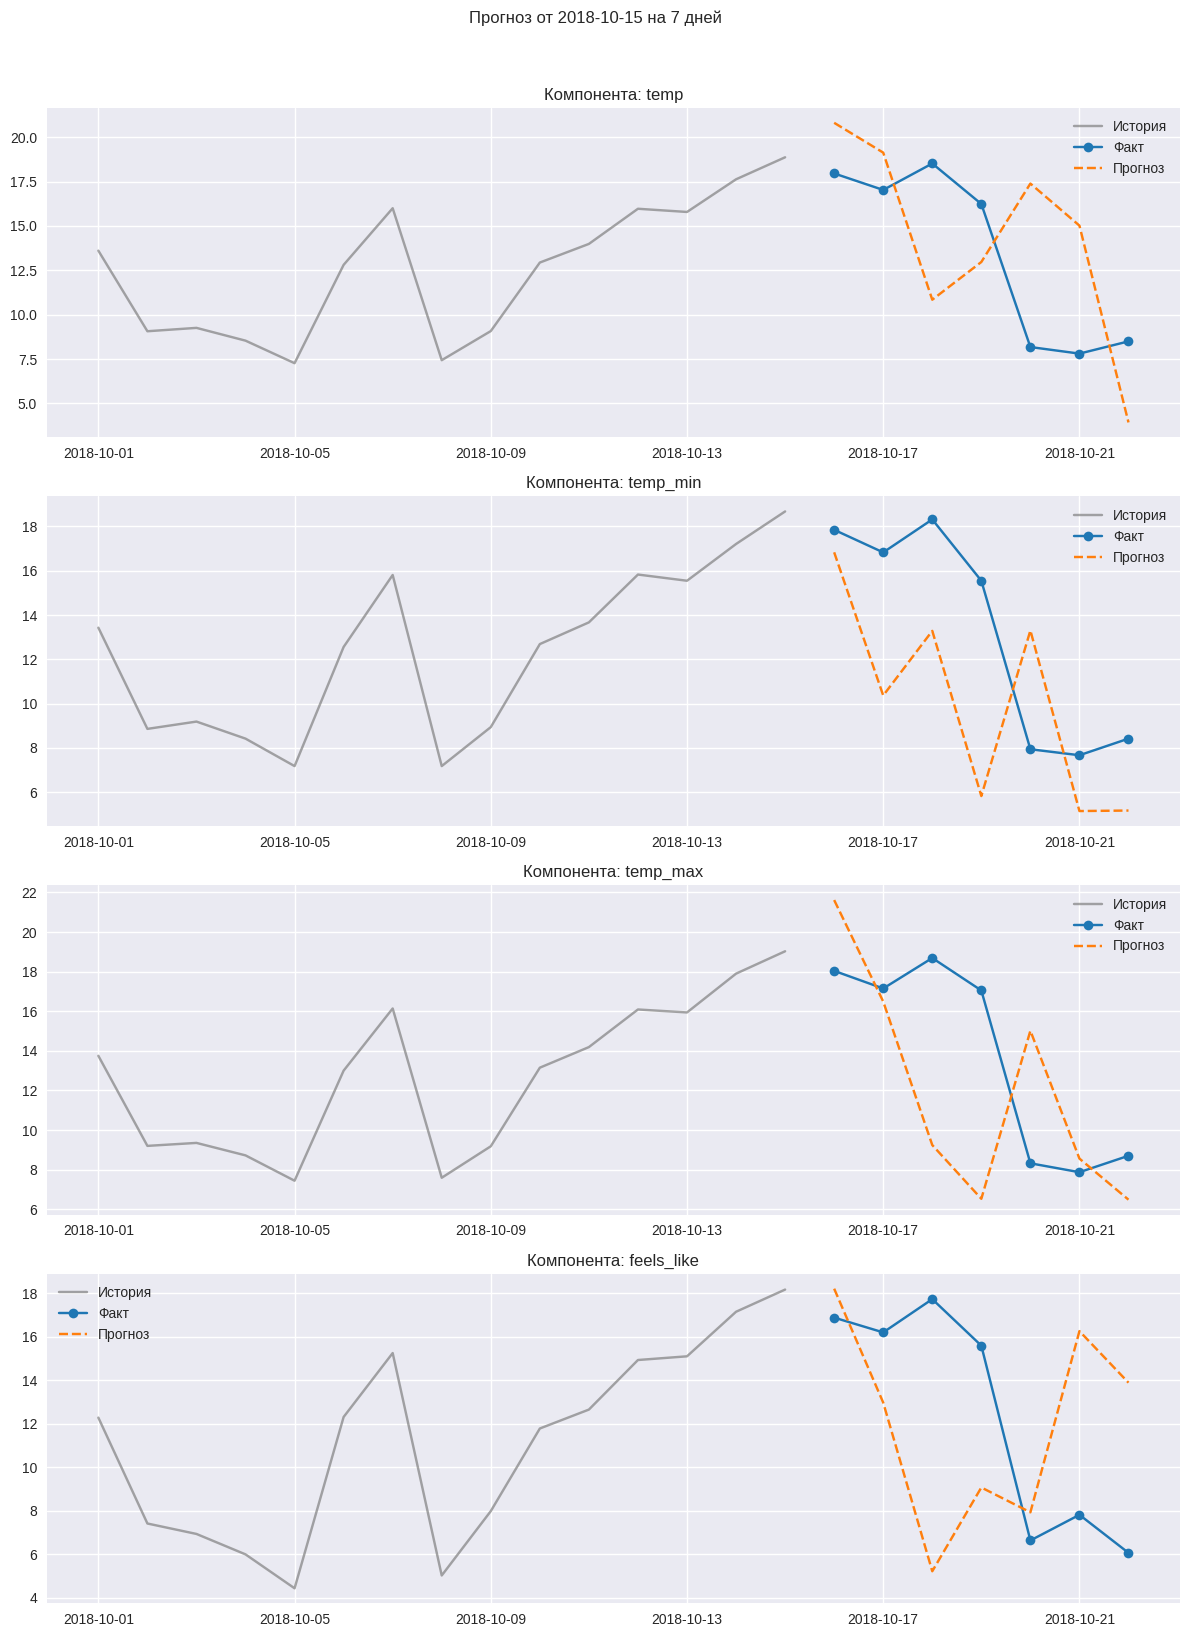

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

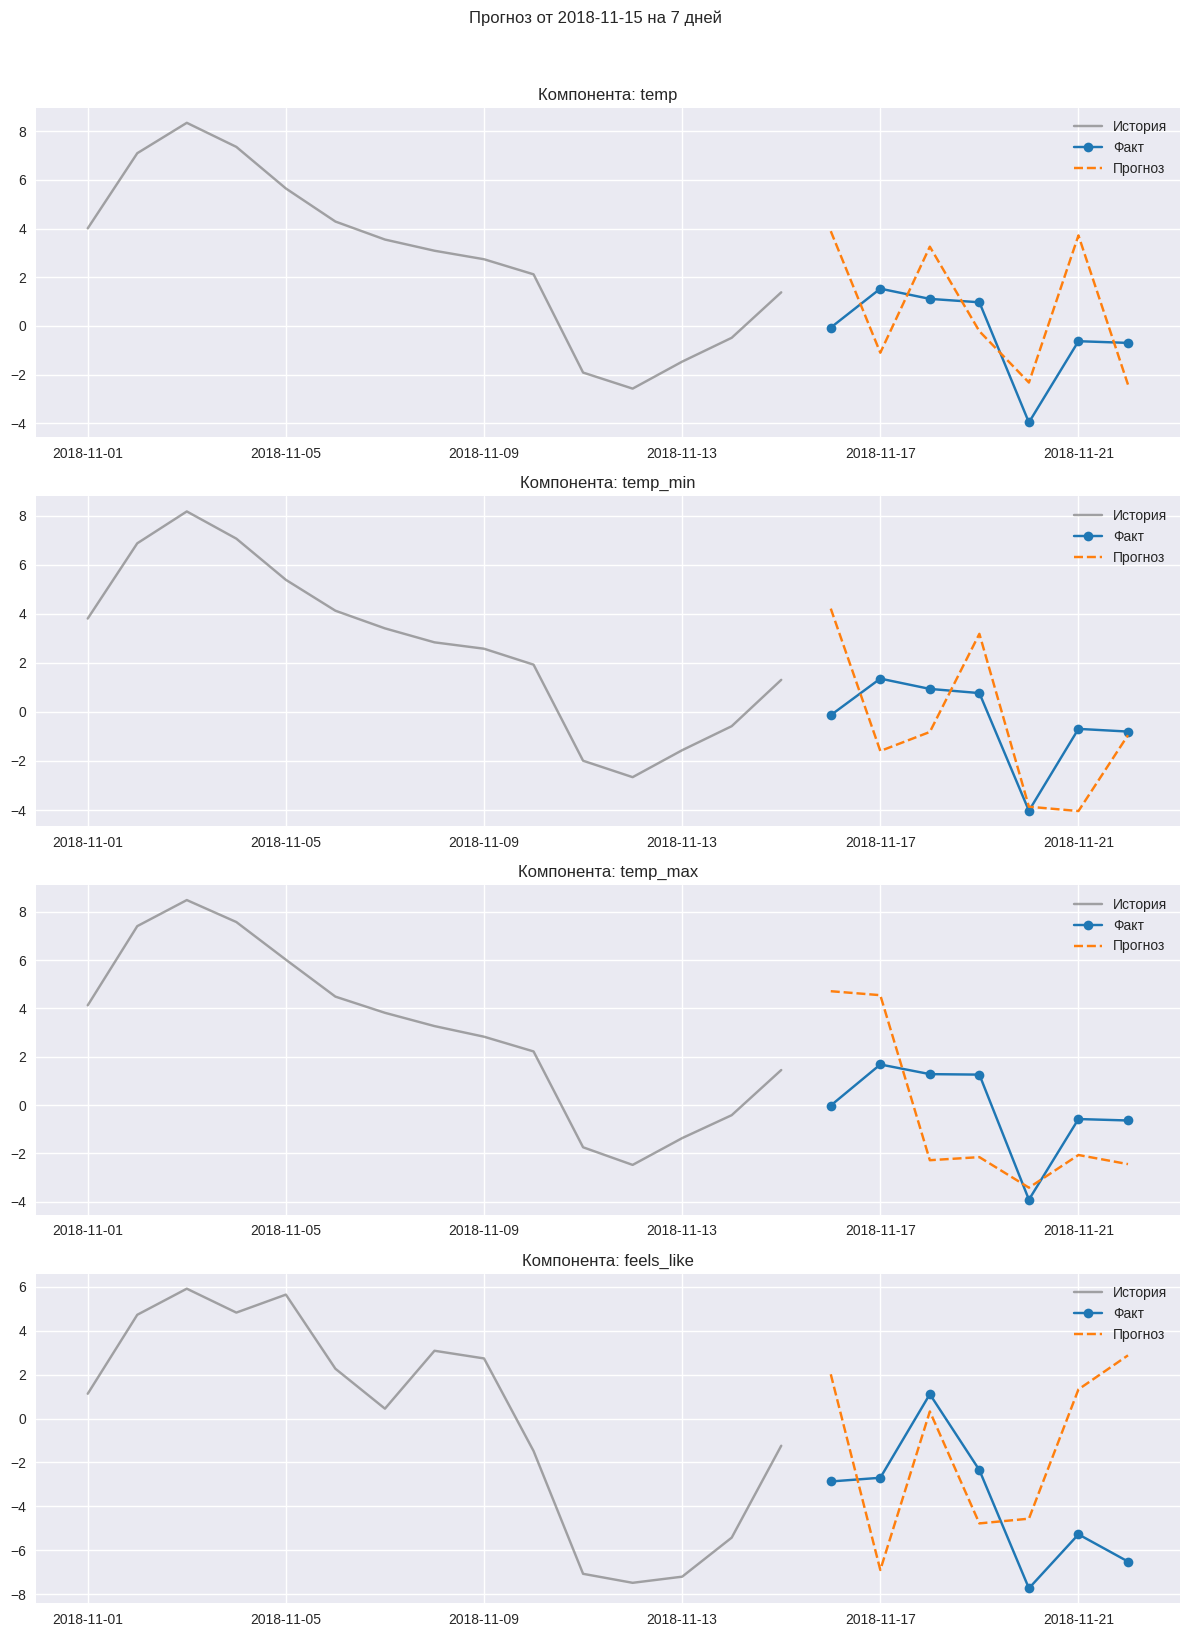

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

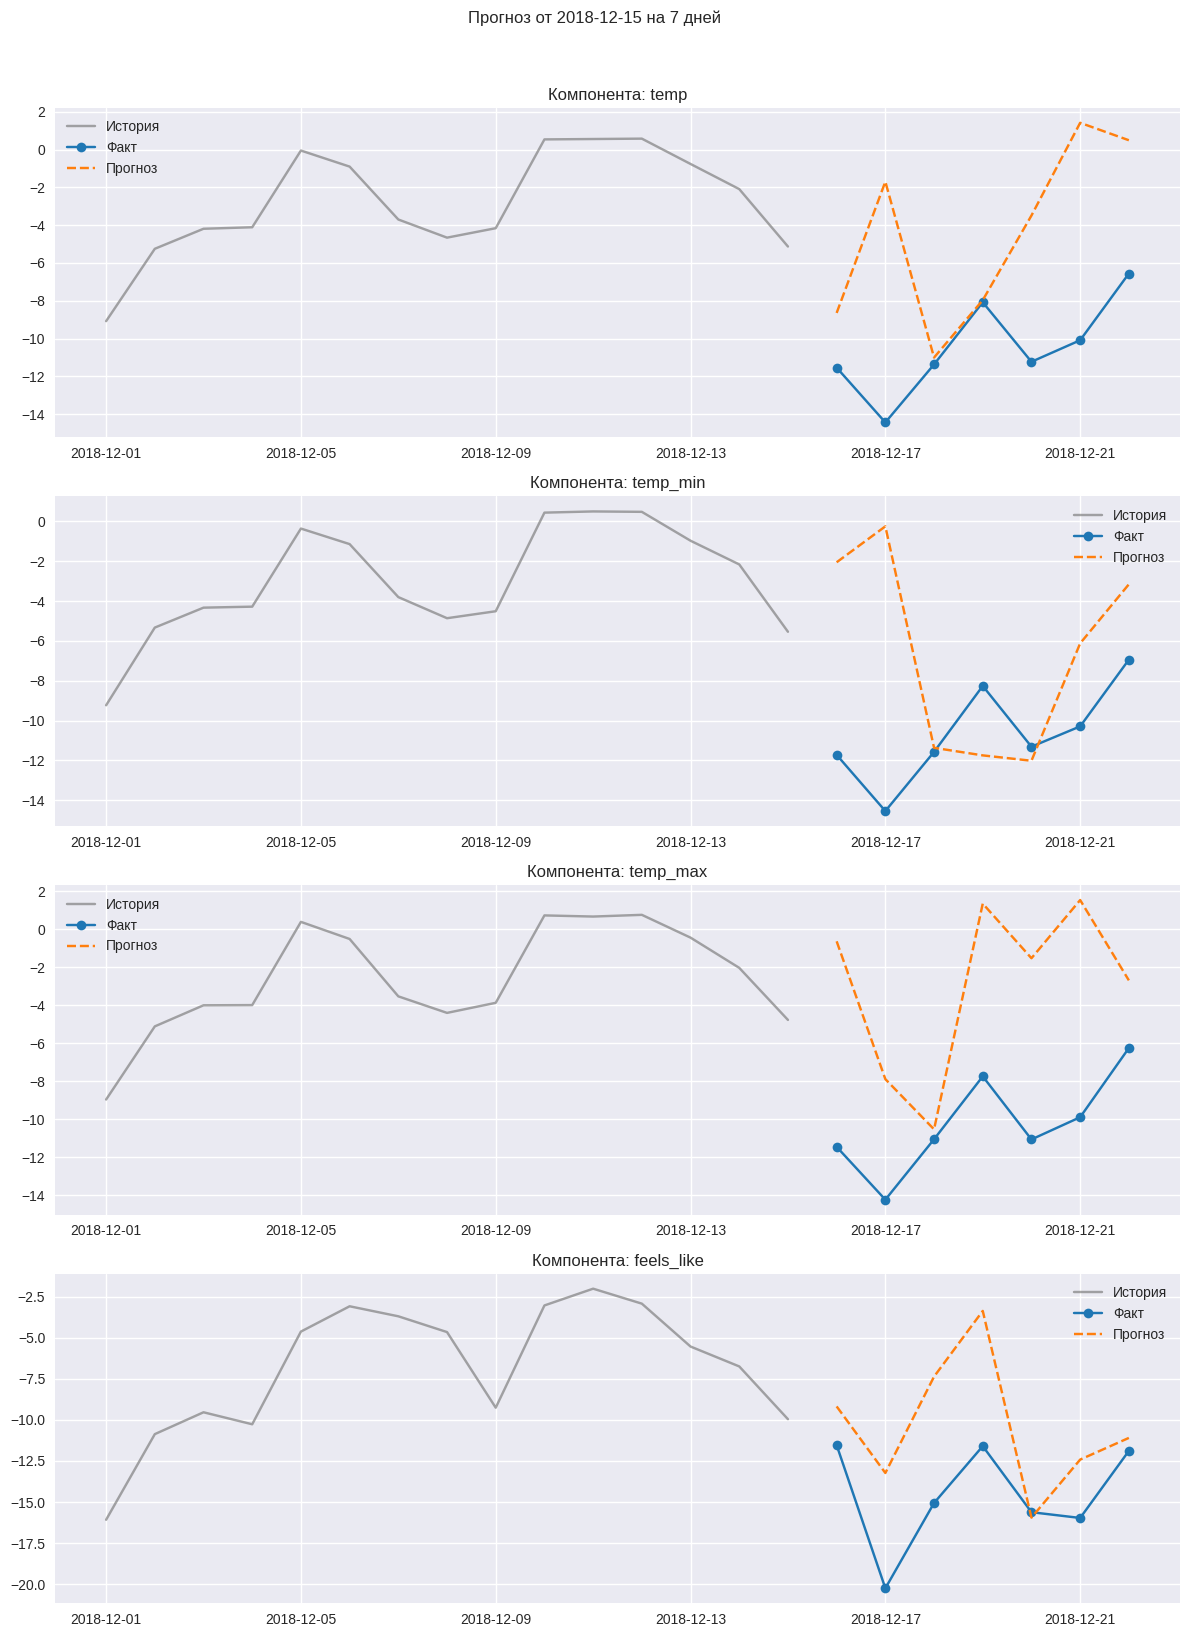

In [ ]:
def make_forecast_from_date(series, start_date, n_steps=7):
    start_date = pd.Timestamp(start_date)

    try:
        start_idx = series.time_index.get_loc(start_date)
    except KeyError:
        start_idx = series.time_index.get_indexer([start_date], method='backfill')[0]
        if start_idx == -1:
            raise ValueError(f"Дата {start_date} выходит за пределы временного ряда")

    input_chunk_length = tft_model.input_chunk_length
    input_data = series[max(0, start_idx-input_chunk_length+1) : start_idx+1]

    forecast = tft_model.predict(
        n=n_steps,
        series=input_data,
        past_covariates=scaled_covariates
    )

    end_idx = min(start_idx + n_steps, len(series)-1)
    actual = series[start_idx+1 : end_idx+1]

    # Обратное масштабирование
    if hasattr(target_scaler, 'inverse_transform'):
        forecast = target_scaler.inverse_transform(forecast)
        actual = target_scaler.inverse_transform(actual)

    return forecast, actual

start_year='2018'

date_list = pd.date_range(start=f'{start_year}-01-15', end=f'{start_year}-12-15', freq='MS') + pd.Timedelta(days=14)

for start_date in date_list:
    forecast, actual = make_forecast_from_date(
        series=ts_target_val[0],
        start_date=start_date,
        n_steps=7
    )

    fig, axes = plt.subplots(4, 1, figsize=(12, 16))
    components = forecast.components

    for i, (comp, ax) in enumerate(zip(components, axes)):

        history = ts_target_val[0].slice(
            start_date - pd.Timedelta(days=14),
            start_date
        )
        ax.plot(
            history.time_index,
            target_scaler.inverse_transform(history).univariate_component(i).values(),
            label='История', color='gray', alpha=0.7
        )

        ax.plot(
            actual.time_index,
            actual.univariate_component(i).values(),
            label='Факт', color='#1f77b4', marker='o'
        )

        ax.plot(
            forecast.time_index,
            forecast.univariate_component(i).values(),
            label='Прогноз', color='#ff7f0e', linestyle='--', marker='x'
        )

        ax.set_title(f'Компонента: {comp}')
        ax.legend()
        ax.grid()

    plt.suptitle(f'Прогноз от {start_date.date()} на 7 дней', y=1.02)
    plt.tight_layout()
    plt.show()

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

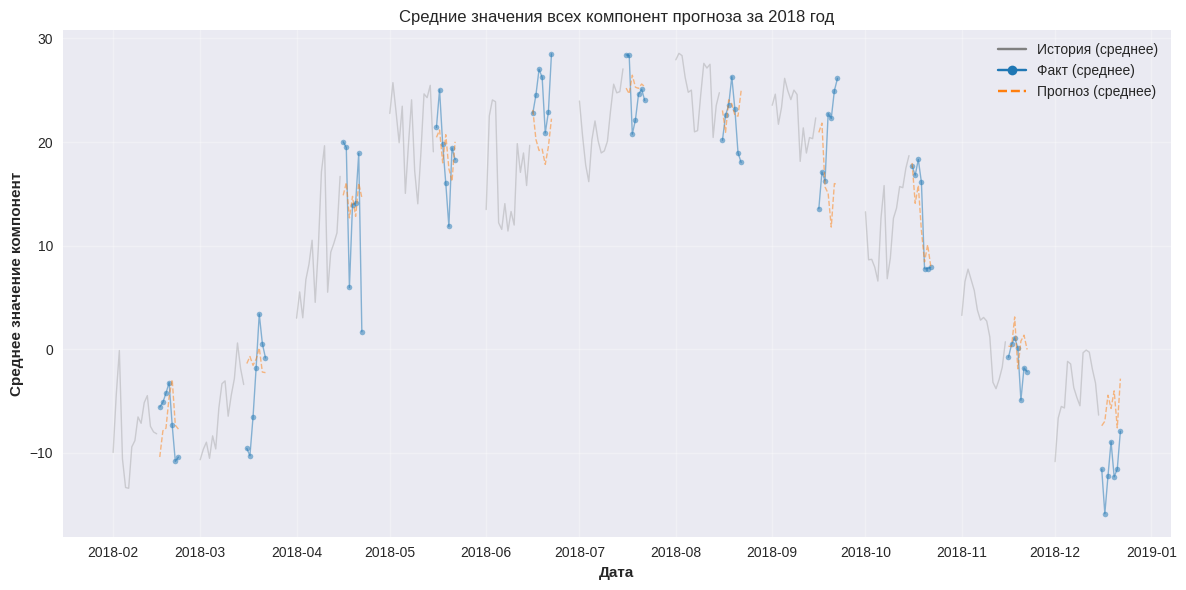

In [ ]:
start_year = '2018'
date_list = pd.date_range(start=f'{start_year}-01-15', end=f'{start_year}-12-15', freq='MS') + pd.Timedelta(days=14)

plt.figure(figsize=(12, 6))

for start_date in date_list:
    forecast, actual = make_forecast_from_date(
        series=ts_target_val[0],
        start_date=start_date,
        n_steps=7
    )

    forecast_values = np.mean([forecast.univariate_component(i).values() for i in range(len(forecast.components))], axis=0)
    actual_values = np.mean([actual.univariate_component(i).values() for i in range(len(actual.components))], axis=0)

    history = ts_target_val[0].slice(
        start_date - pd.Timedelta(days=14),
        start_date
    )
    history_values = np.mean([target_scaler.inverse_transform(history).univariate_component(i).values()
                            for i in range(len(history.components))], axis=0)

    plt.plot(
        history.time_index,
        history_values,
        color='gray', alpha=0.3, linewidth=1
    )

    plt.plot(
        actual.time_index,
        actual_values,
        color='#1f77b4', alpha=0.5, marker='o', markersize=4, linewidth=1
    )

    plt.plot(
        forecast.time_index,
        forecast_values,
        color='#ff7f0e', alpha=0.5, linestyle='--', marker='x', markersize=4, linewidth=1
    )

plt.plot([], [], color='gray', label='История (среднее)')
plt.plot([], [], color='#1f77b4', marker='o', label='Факт (среднее)')
plt.plot([], [], color='#ff7f0e', linestyle='--', marker='x', label='Прогноз (среднее)')
plt.title(f'Средние значения всех компонент прогноза за {start_year} год')
plt.xlabel('Дата')
plt.ylabel('Среднее значение компонент')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()